In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/exam-1/data.csv


In [36]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib
import optuna

In [11]:
import pandas as pd

data = pd.read_csv('/kaggle/input/exam-1/data.csv')

data.head()

Unnamed: 0  case_id  Hospital_code Hospital_type_code  City_Code_Hospital  \
0           0        1              8                  c                   3   
1           1        2              2                  c                   5   
2           2        3             10                  e                   1   
3           3        4             26                  b                   2   
4           4        5             26                  b                   2   

  Hospital_region_code  Available Extra Rooms in Hospital    Department  \
0                    Z                                  3  radiotherapy   
1                    Z                                  2  radiotherapy   
2                    X                                  2    anesthesia   
3                    Y                                  2  radiotherapy   
4                    Y                                  2  radiotherapy   

  Ward_Type Ward_Facility_Code  ...  patientid  City_Code_Patient  \
0         R                  F  ...      31397                7.0   
1         S                  F  ...      31397                7.0   
2         S                  E  ...      31397                7.0   
3         R                  D  ...      31397                7.0   
4         S                  D  ...      31397                7.0   

   Type of Admission Severity of Illness Visitors with Patient    Age  \
0          Emergency             Extreme                     2  51-60   
1             Trauma             Extreme                     2  51-60   
2             Trauma             Extreme                     2  51-60   
3             Trauma             Extreme                     2  51-60   
4             Trauma             Extreme                     2  51-60   

  Admission_Deposit   Stay doctorid  country_code  
0            4911.0   0-10      NaN             1  
1            5954.0  41-50      NaN             1  
2            4745.0  31-40      NaN             1  
3            7272.0  41-50      NaN             1  
4            5558.0  41-50      NaN             1  

[5 rows x 21 columns]

In [8]:
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318438 entries, 0 to 318437
Data columns (total 21 columns):
 #   Column                             Non-Null Count   Dtype  
---  ------                             --------------   -----  
 0   Unnamed: 0                         318438 non-null  int64  
 1   case_id                            318438 non-null  int64  
 2   Hospital_code                      318438 non-null  int64  
 3   Hospital_type_code                 318438 non-null  object 
 4   City_Code_Hospital                 318438 non-null  int64  
 5   Hospital_region_code               318438 non-null  object 
 6   Available Extra Rooms in Hospital  318438 non-null  int64  
 7   Department                         318438 non-null  object 
 8   Ward_Type                          318438 non-null  object 
 9   Ward_Facility_Code                 318438 non-null  object 
 10  Bed Grade                          318325 non-null  float64
 11  patientid                          3184

In [9]:
categorical_features = data.select_dtypes(include=['object']).columns.tolist()
numerical_features = data.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"Категоріальні ознаки: {categorical_features}")
print(f"Числові ознаки: {numerical_features}")

Категоріальні ознаки: ['Hospital_type_code', 'Hospital_region_code', 'Department', 'Ward_Type', 'Ward_Facility_Code', 'Type of Admission', 'Severity of Illness', 'Age', 'Stay']
Числові ознаки: ['Unnamed: 0', 'case_id', 'Hospital_code', 'City_Code_Hospital', 'Available Extra Rooms in Hospital', 'Bed Grade', 'patientid', 'City_Code_Patient', 'Visitors with Patient', 'Admission_Deposit', 'doctorid', 'country_code']


In [14]:
missing_values = data.isnull().sum()

print(missing_values[missing_values > 0])

Bed Grade               113
City_Code_Patient      4532
doctorid             316012
dtype: int64


In [16]:
data['Bed Grade'] = data['Bed Grade'].fillna(data['Bed Grade'].mode()[0])

In [18]:
data['City_Code_Patient'].fillna('Unknown', inplace=True)

In [19]:
data.drop(columns=['doctorid'], inplace=True)

In [20]:
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

Series([], dtype: int64)


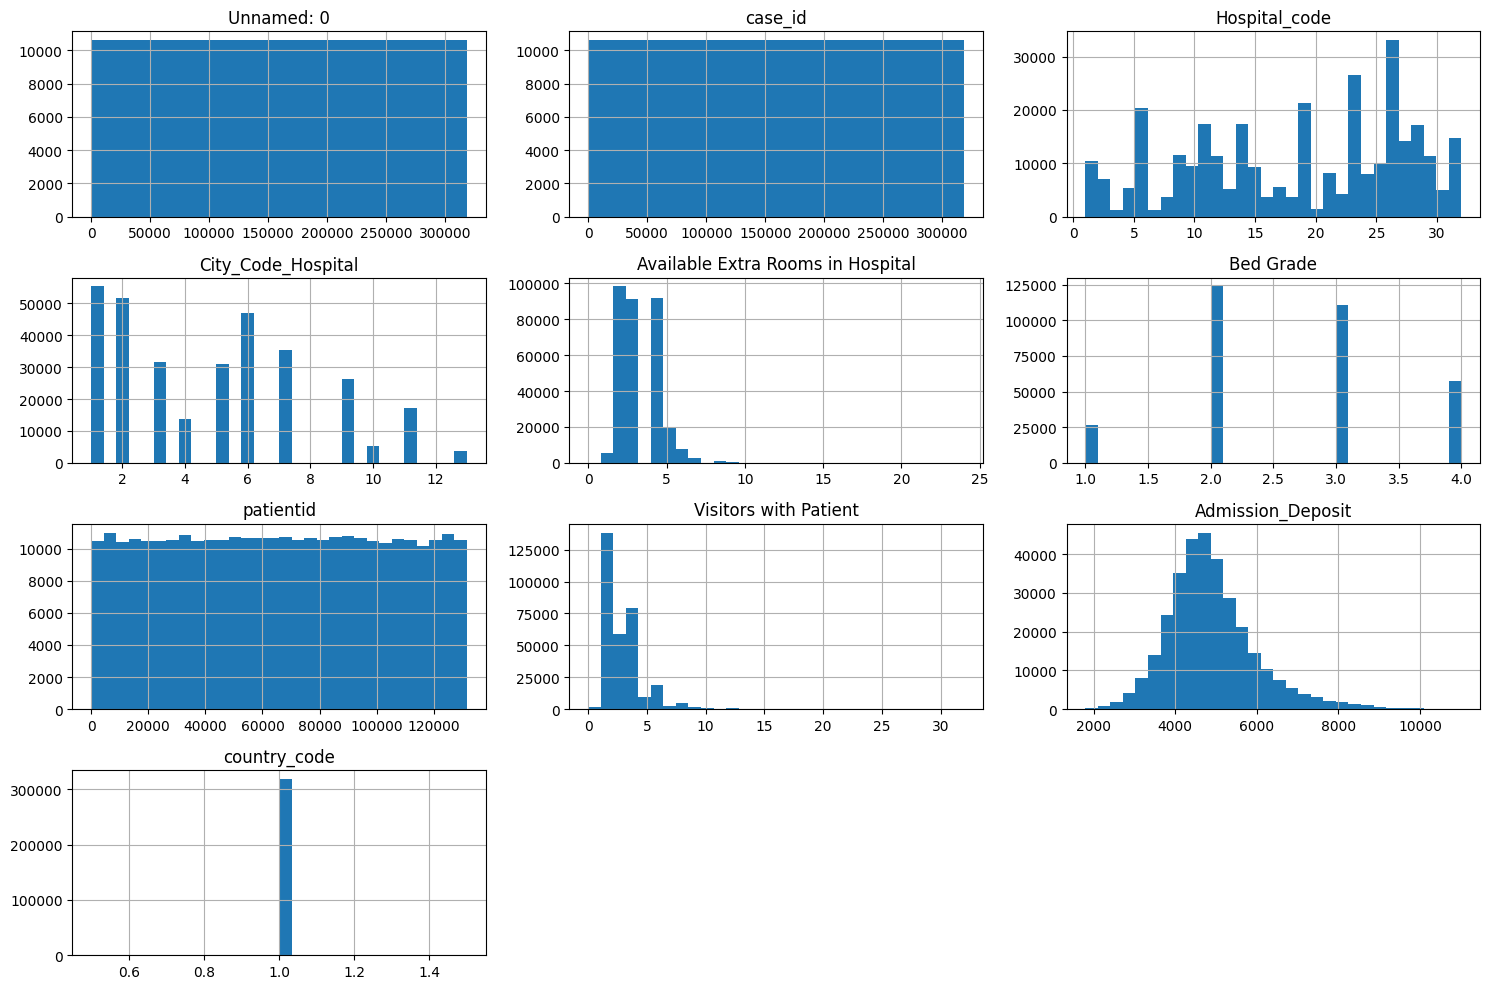

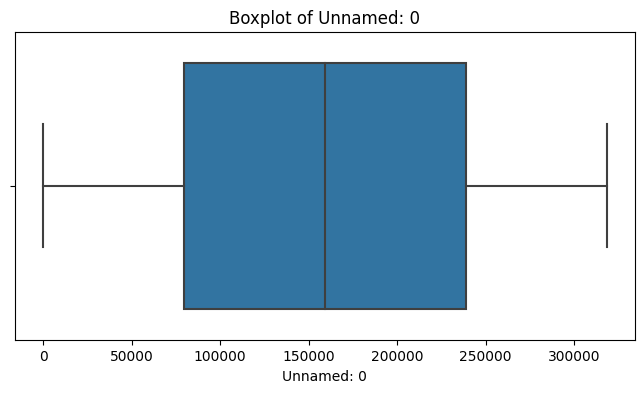

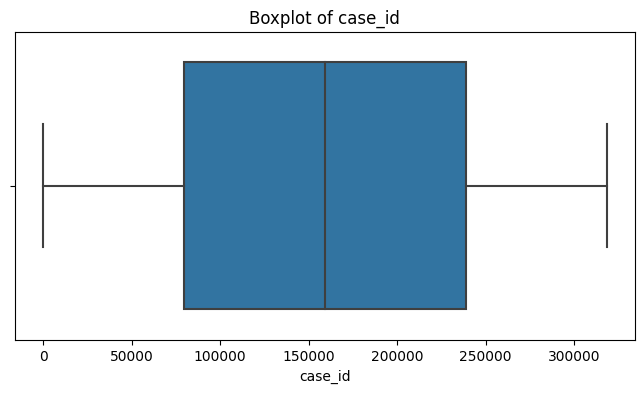

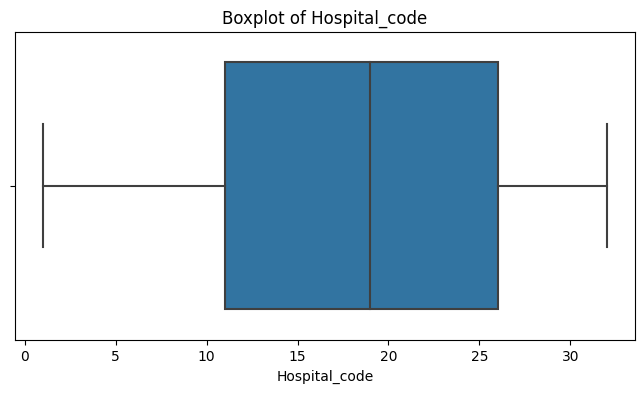

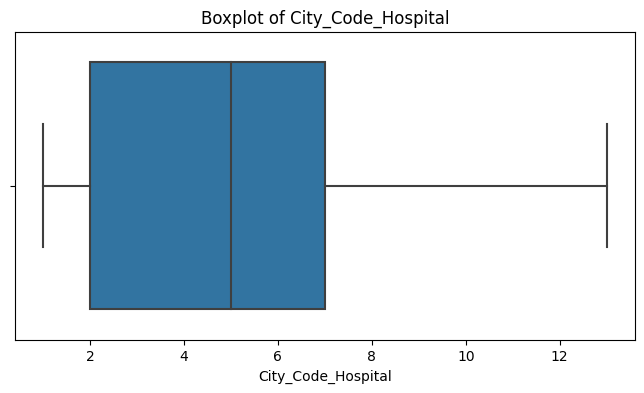

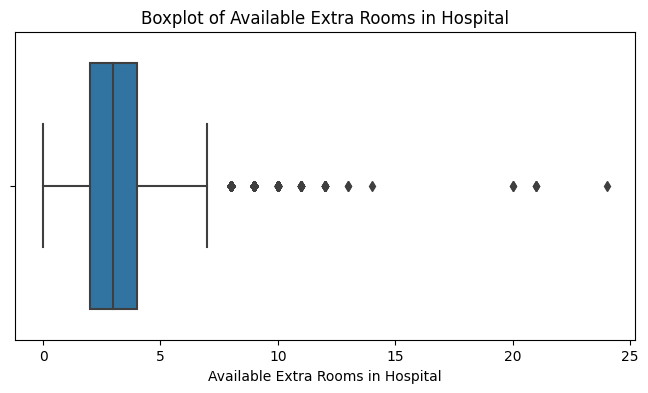

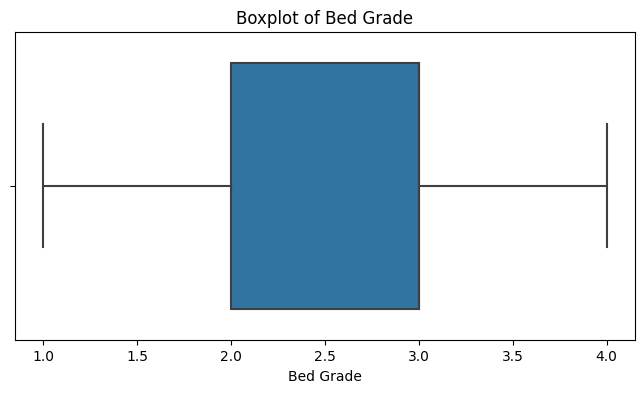

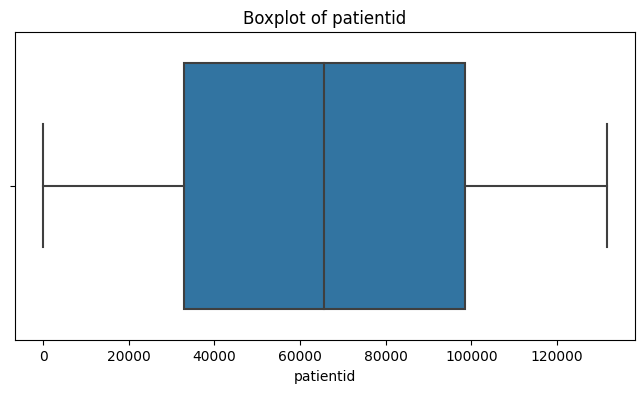

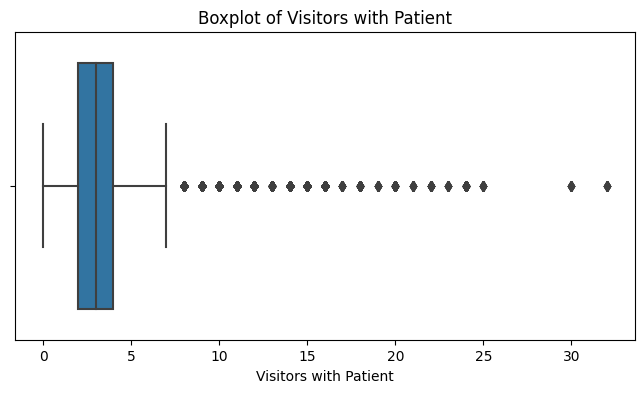

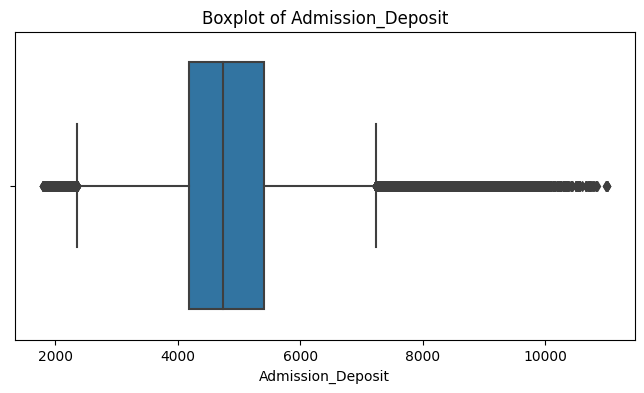

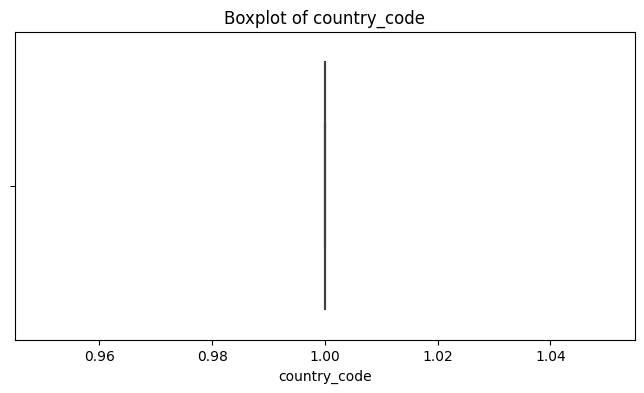

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
data[numerical_cols].hist(figsize=(15, 10), bins=30)
plt.tight_layout()
plt.show()

for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.boxplot(x=data[col])
    plt.title(f'Boxplot of {col}')
    plt.show()

In [22]:
print(data['Available Extra Rooms in Hospital'].describe())

#максимальне значення для Available Extra Rooms in Hospital дорівнює 24, що значно перевищує більшість значень у стовпці (75% значень менше або дорівнюють 4). Це може свідчити про наявність викидів.

count    318438.000000
mean          3.197627
std           1.168171
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          24.000000
Name: Available Extra Rooms in Hospital, dtype: float64


In [23]:
Q1 = data['Available Extra Rooms in Hospital'].quantile(0.25)
Q3 = data['Available Extra Rooms in Hospital'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

print(f'Lower bound: {lower_bound}')
print(f'Upper bound: {upper_bound}')


Lower bound: -1.0
Upper bound: 7.0


In [24]:
data_cleaned = data[(data['Available Extra Rooms in Hospital'] >= lower_bound) & 
                     (data['Available Extra Rooms in Hospital'] <= upper_bound)]

print(data_cleaned['Available Extra Rooms in Hospital'].describe())

count    317087.000000
mean          3.175431
std           1.117482
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           7.000000
Name: Available Extra Rooms in Hospital, dtype: float64


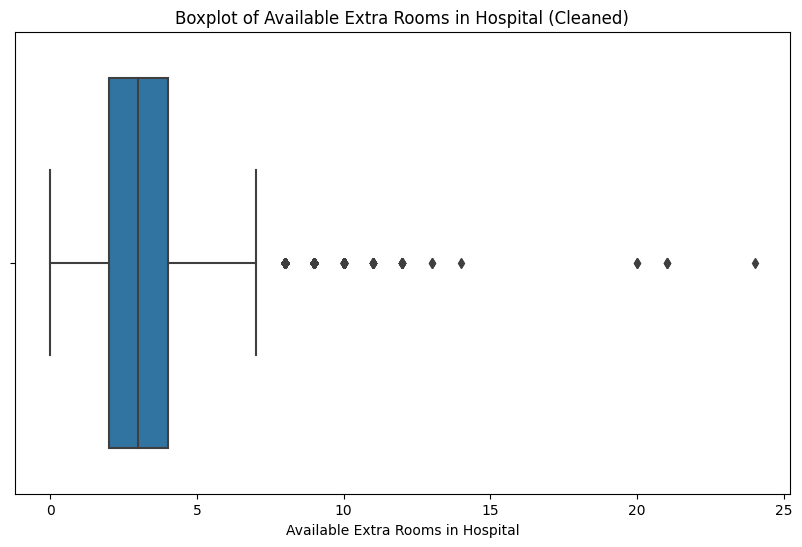

In [25]:
plt.figure(figsize=(10, 6))
sns.boxplot(x=data['Available Extra Rooms in Hospital'])
plt.title('Boxplot of Available Extra Rooms in Hospital (Cleaned)')
plt.show()

In [26]:
print(data['Visitors with Patient'].describe())

count    318438.000000
mean          3.284099
std           1.764061
min           0.000000
25%           2.000000
50%           3.000000
75%           4.000000
max          32.000000
Name: Visitors with Patient, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


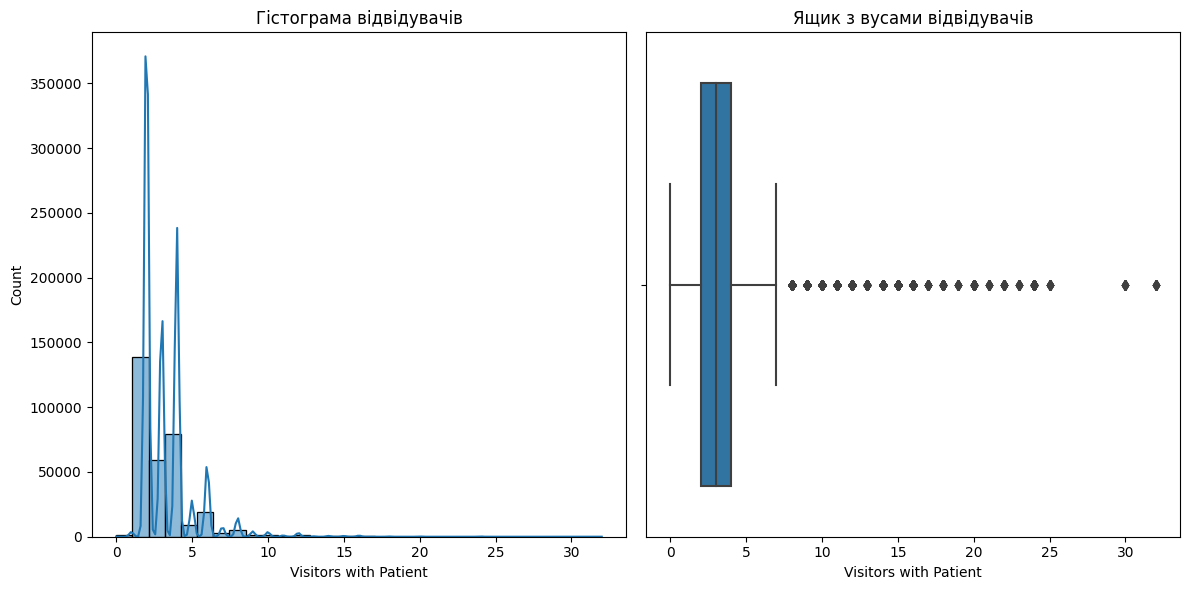

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['Visitors with Patient'], bins=30, kde=True)
plt.title('Гістограма відвідувачів')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Visitors with Patient'])
plt.title('Ящик з вусами відвідувачів')

plt.tight_layout()
plt.show()

In [28]:
print(data['Admission_Deposit'].describe())

count    318438.000000
mean       4880.749392
std        1086.776254
min        1800.000000
25%        4186.000000
50%        4741.000000
75%        5409.000000
max       11008.000000
Name: Admission_Deposit, dtype: float64


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


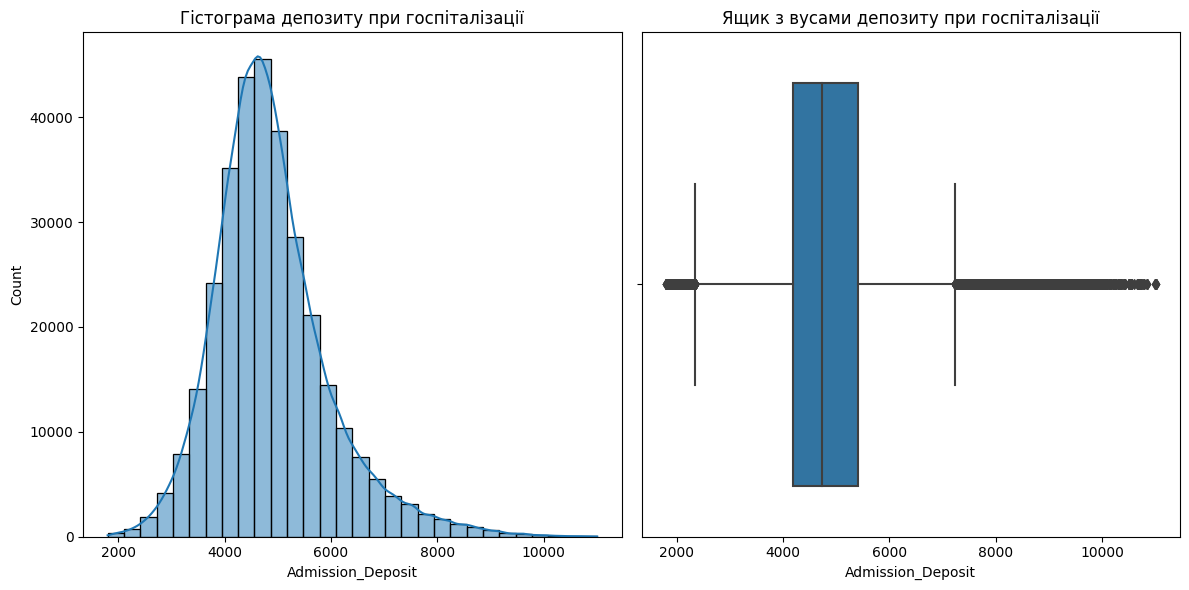

In [29]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.histplot(data['Admission_Deposit'], bins=30, kde=True)
plt.title('Гістограма депозиту при госпіталізації')

plt.subplot(1, 2, 2)
sns.boxplot(x=data['Admission_Deposit'])
plt.title('Ящик з вусами депозиту при госпіталізації')

plt.tight_layout()
plt.show()

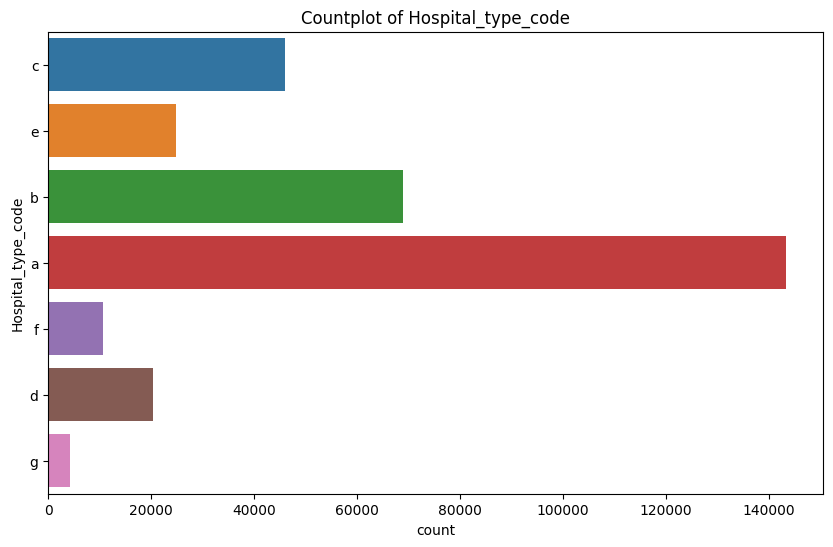

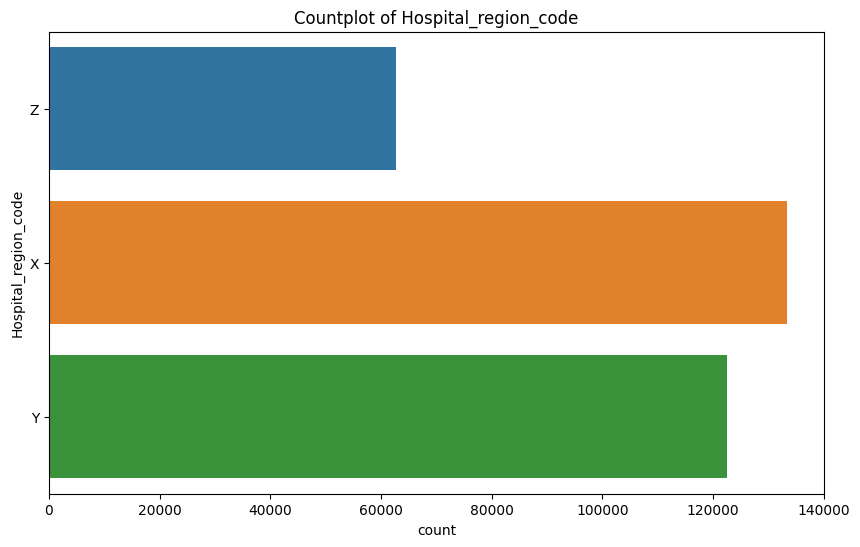

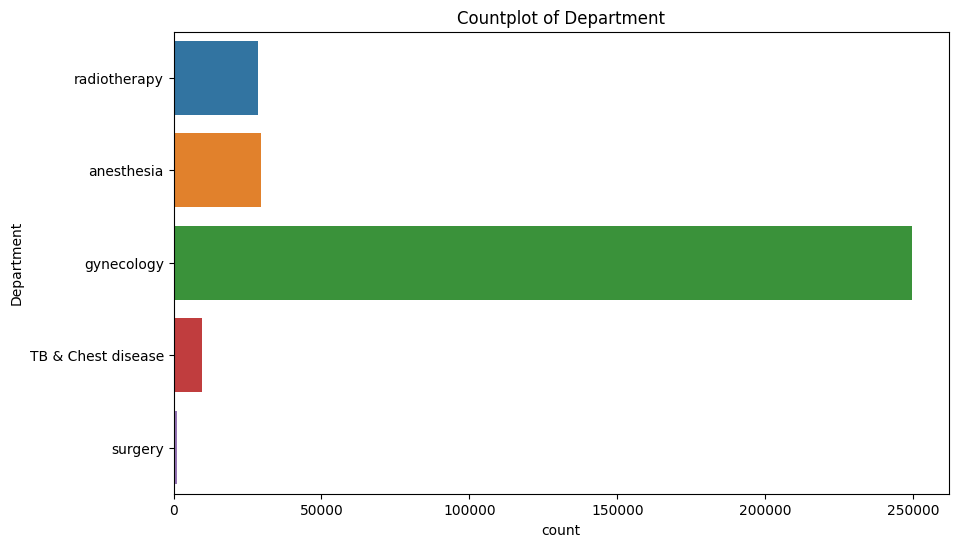

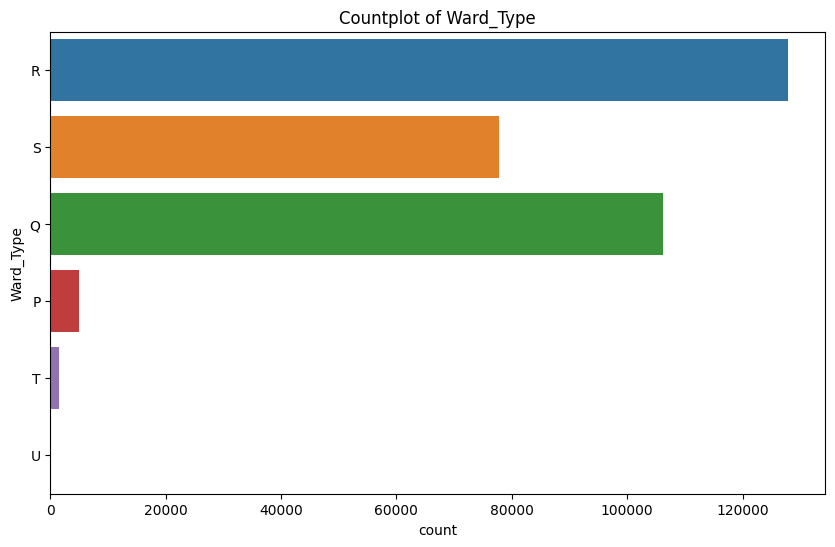

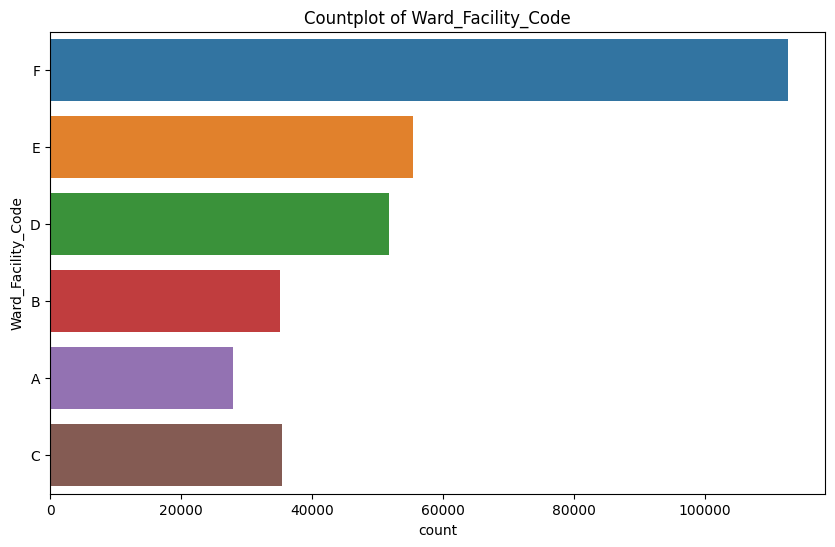

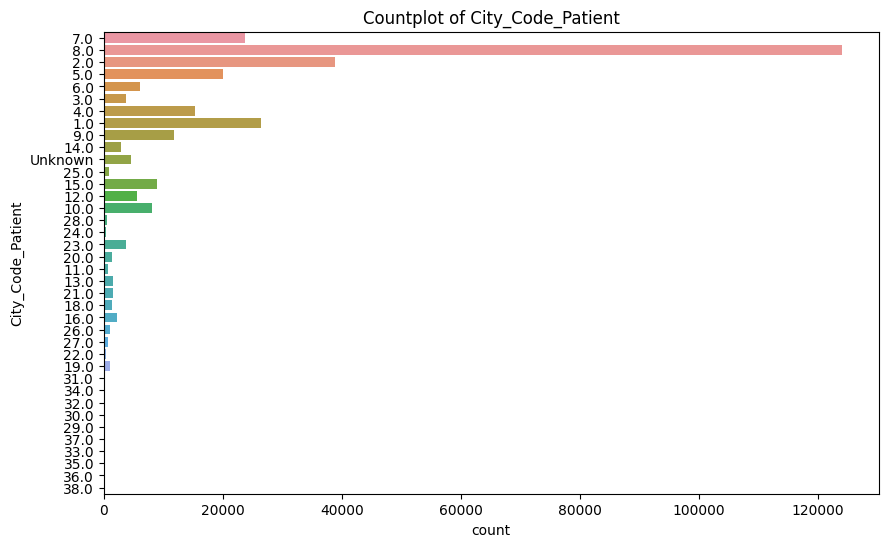

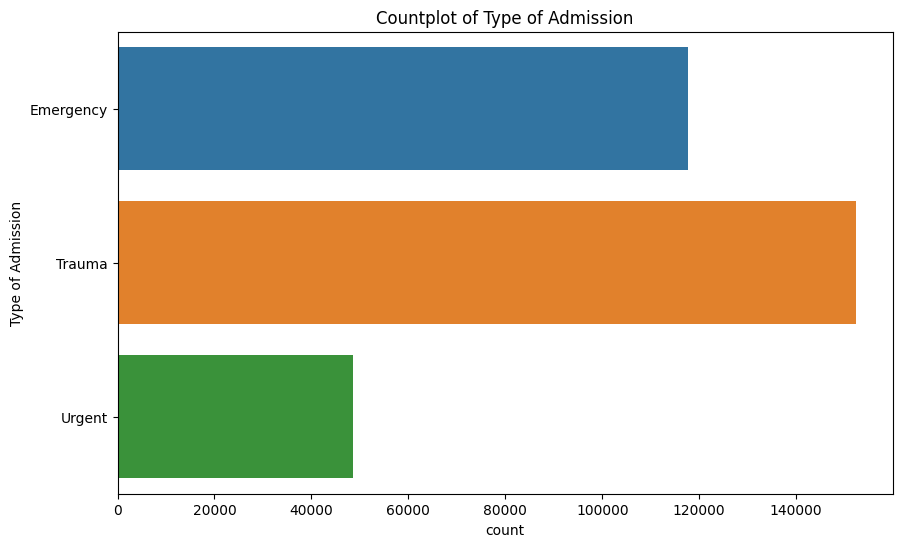

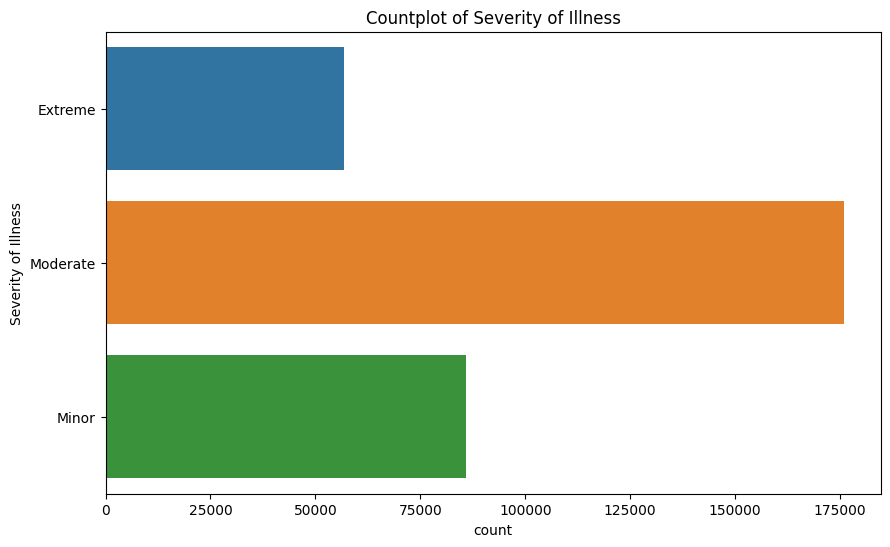

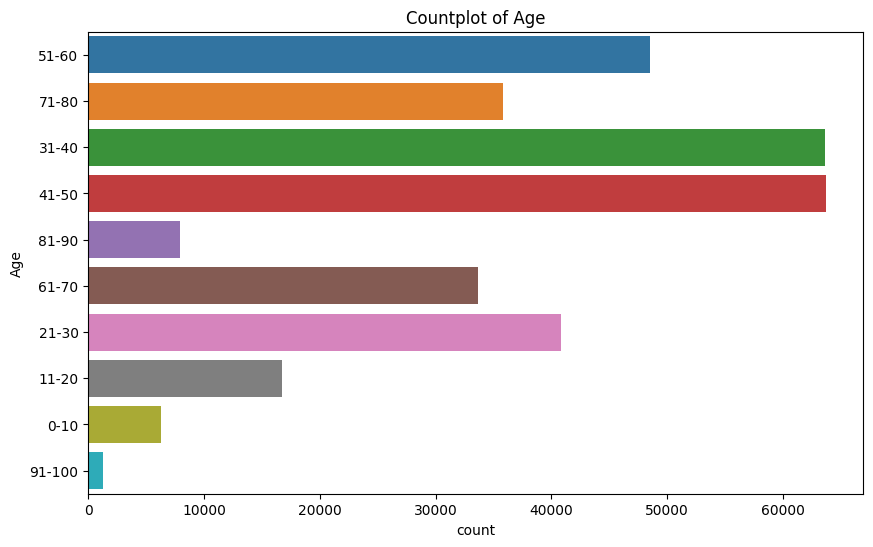

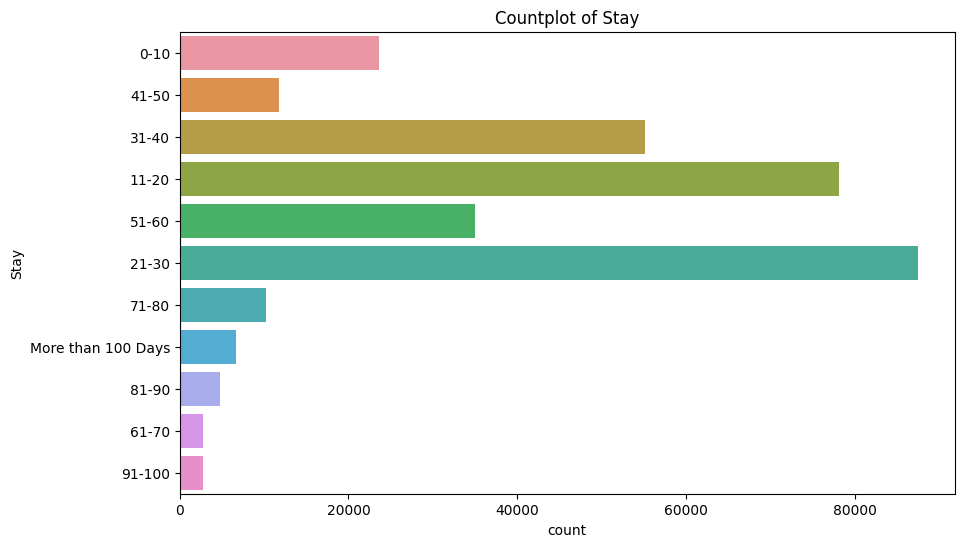

In [30]:
categorical_cols = data.select_dtypes(include=['object']).columns
for col in categorical_cols:
    plt.figure(figsize=(10, 6))
    sns.countplot(y=data[col])
    plt.title(f'Countplot of {col}')
    plt.show()

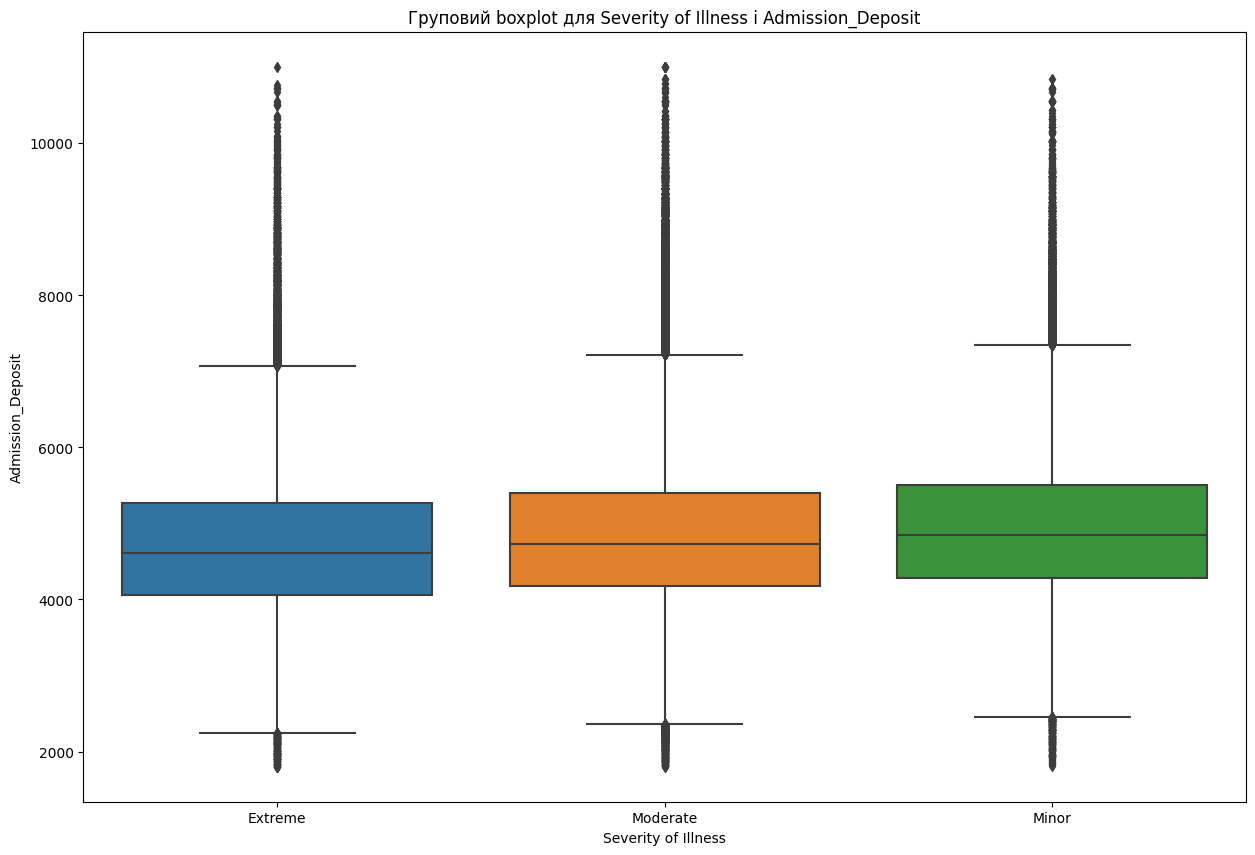

In [31]:
plt.figure(figsize=(15, 10))
sns.boxplot(x='Severity of Illness', y='Admission_Deposit', data=data)
plt.title('Груповий boxplot для Severity of Illness і Admission_Deposit')
plt.show()

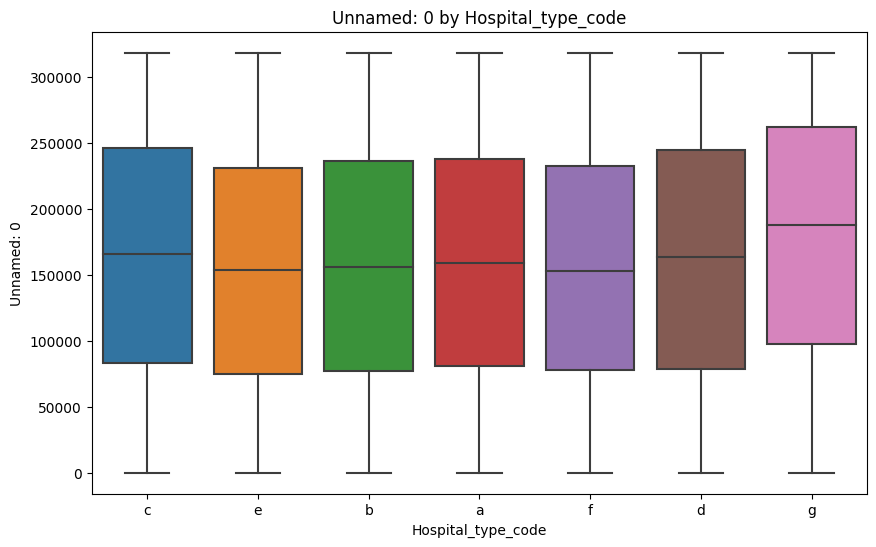

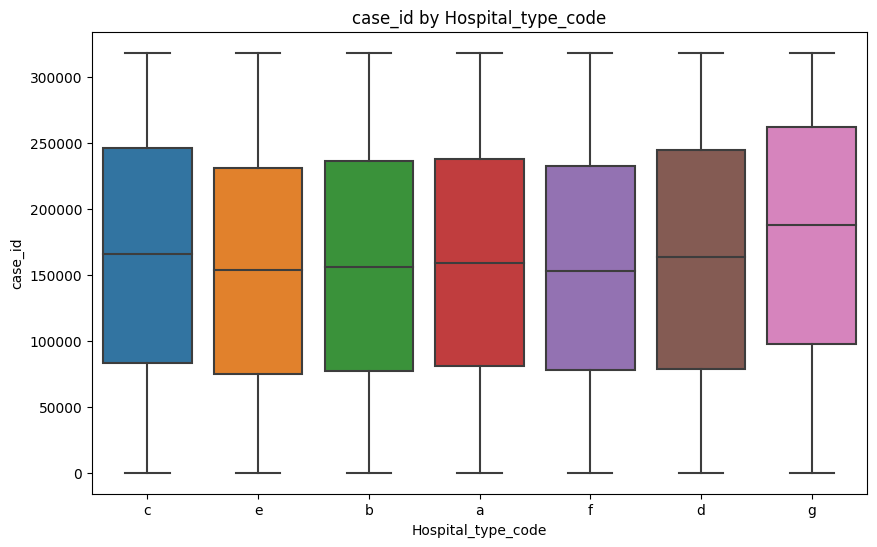

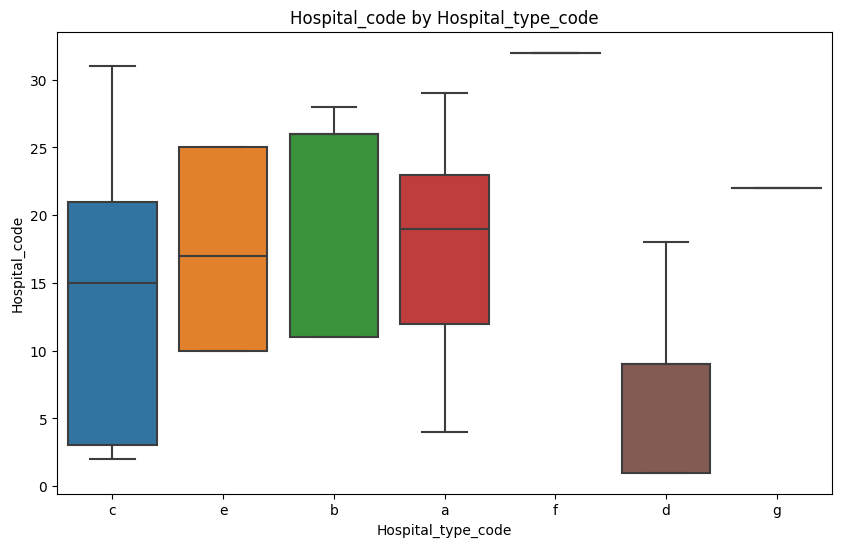

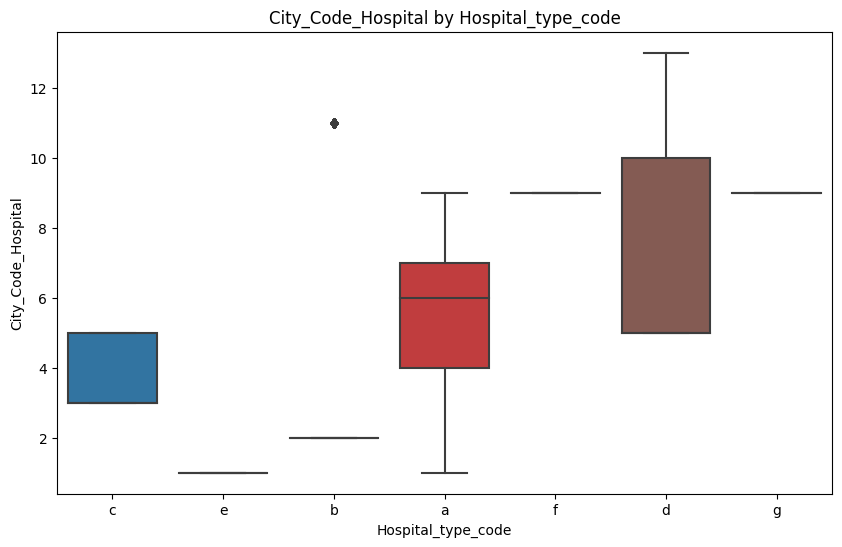

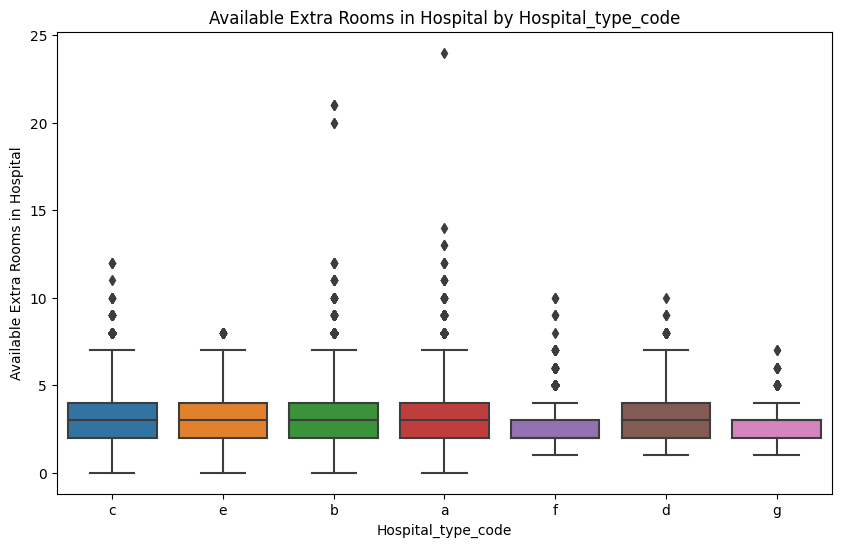

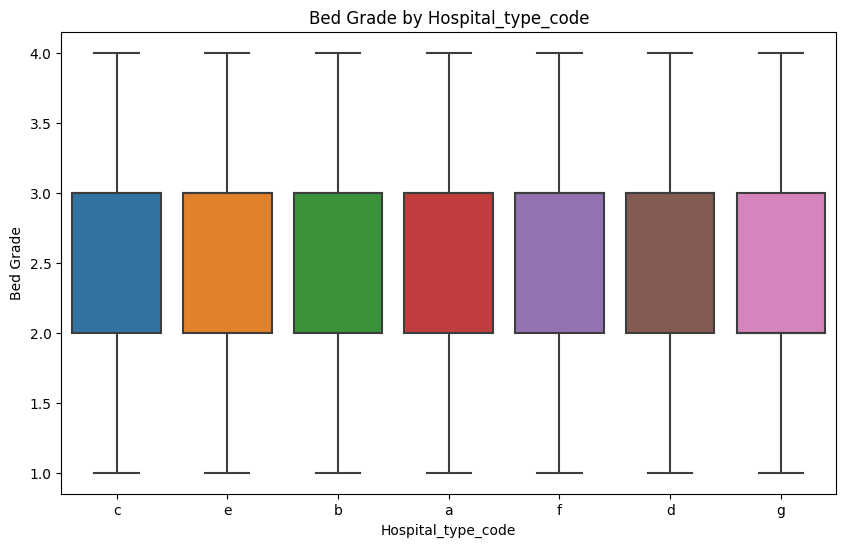

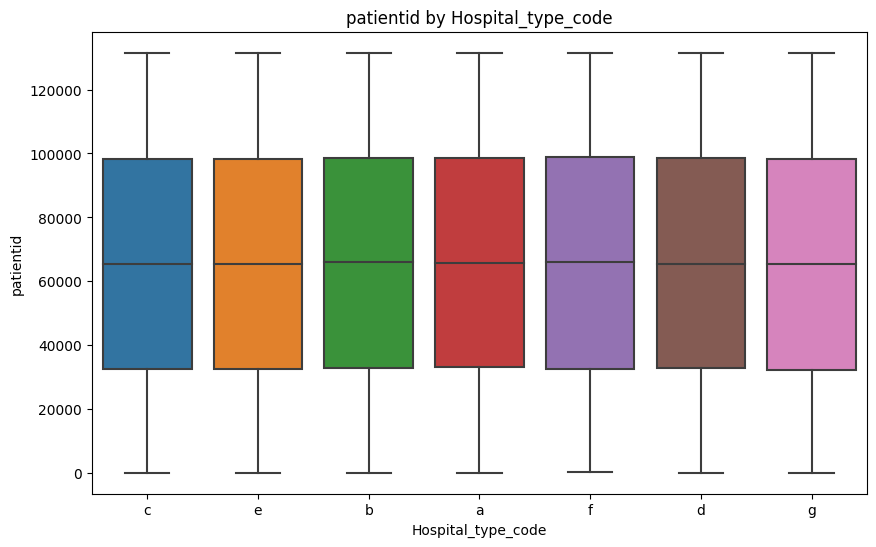

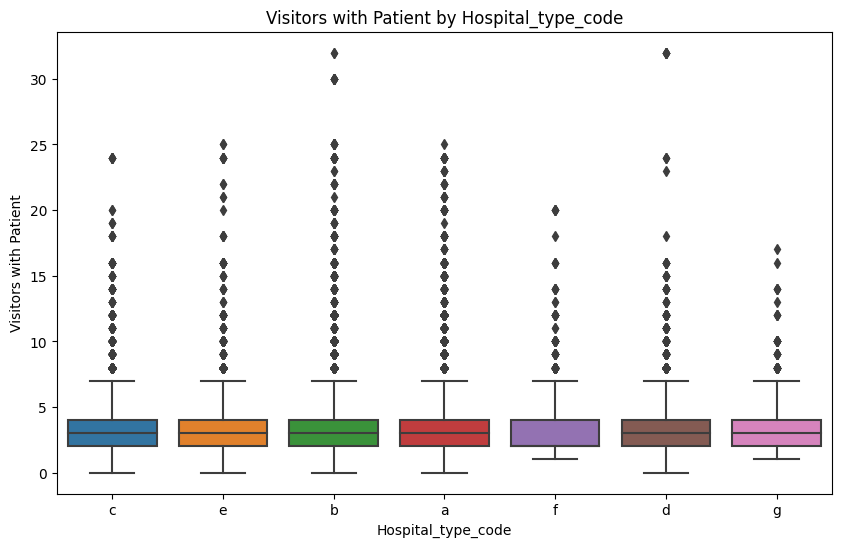

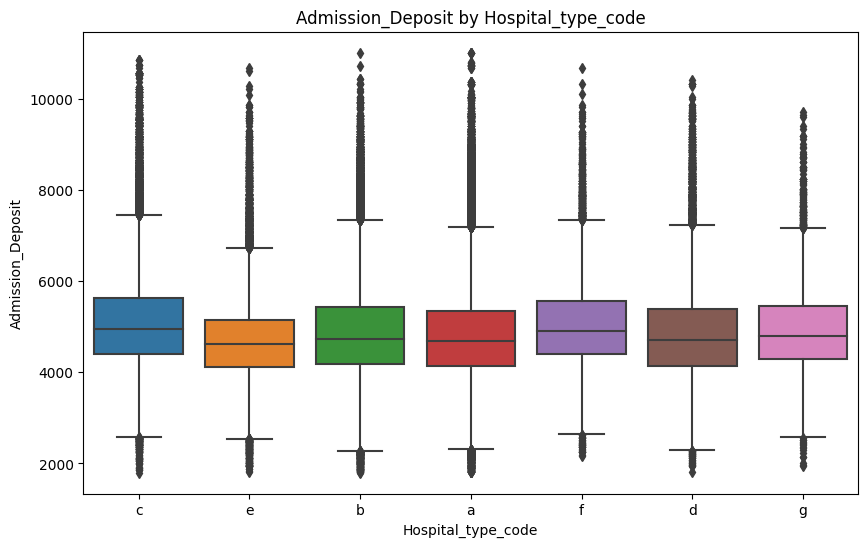

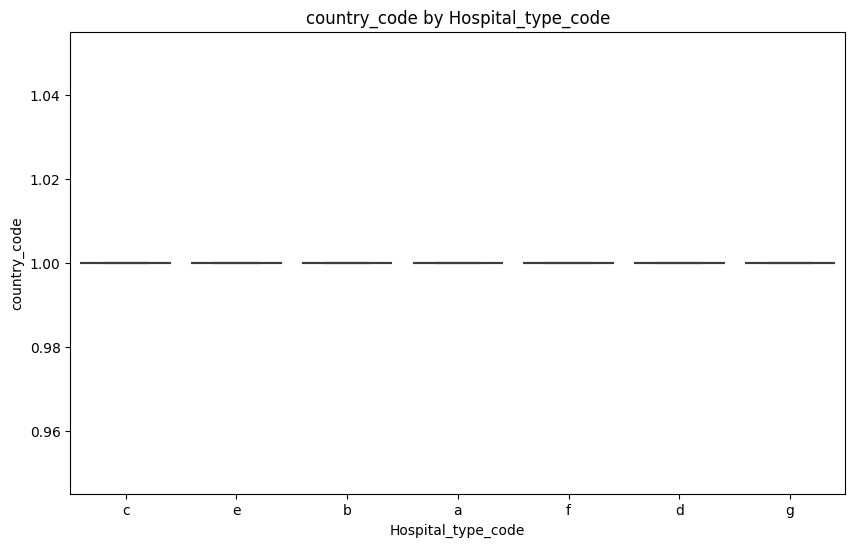

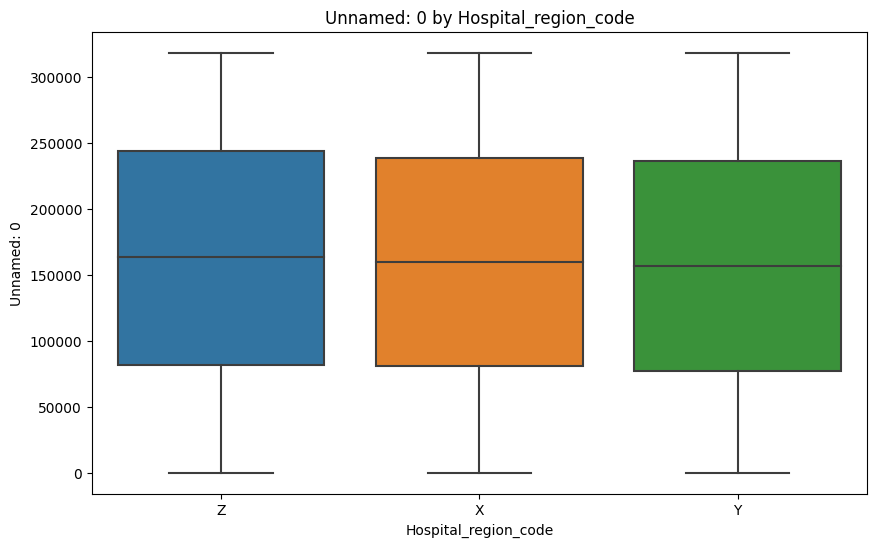

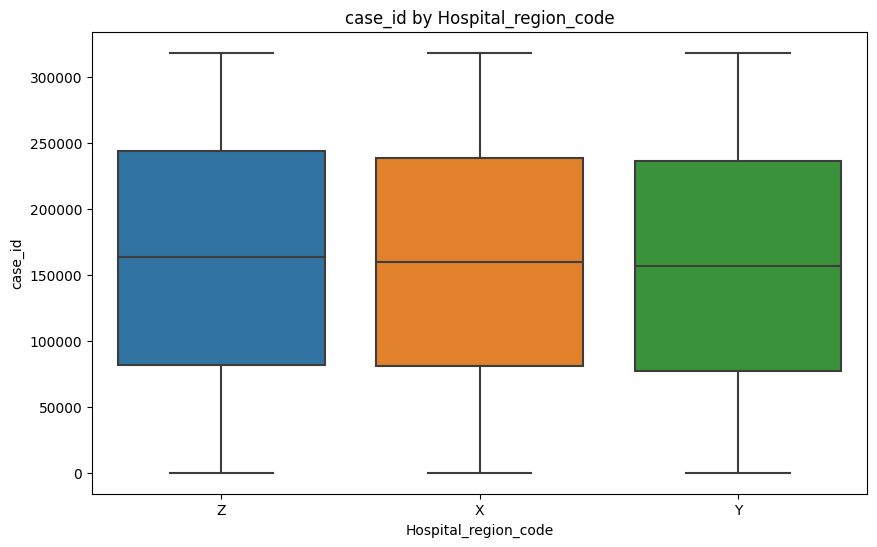

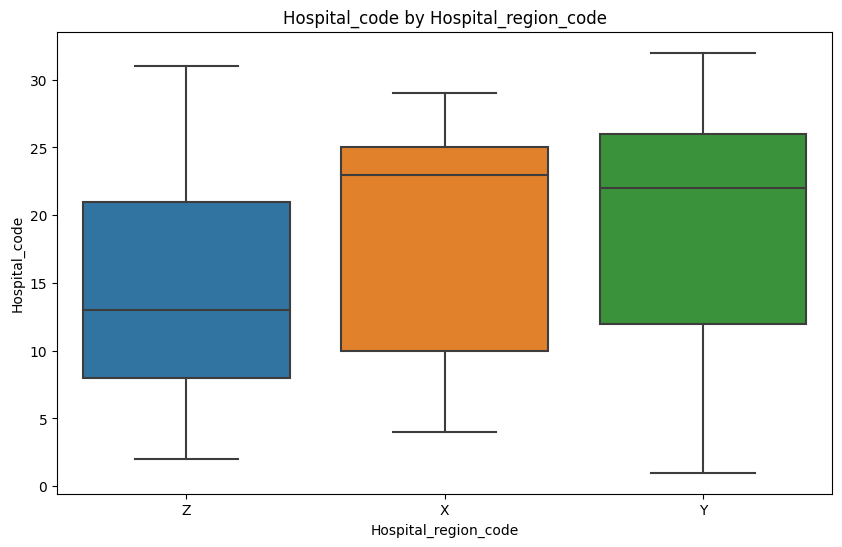

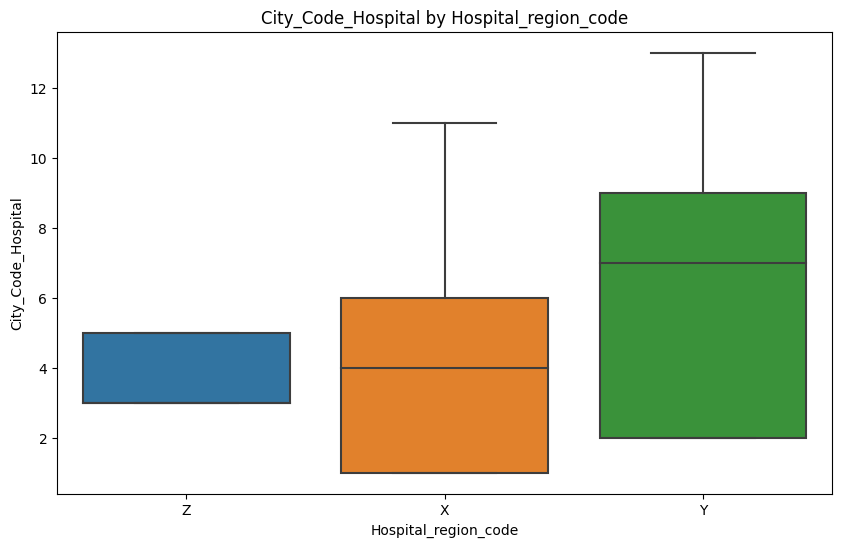

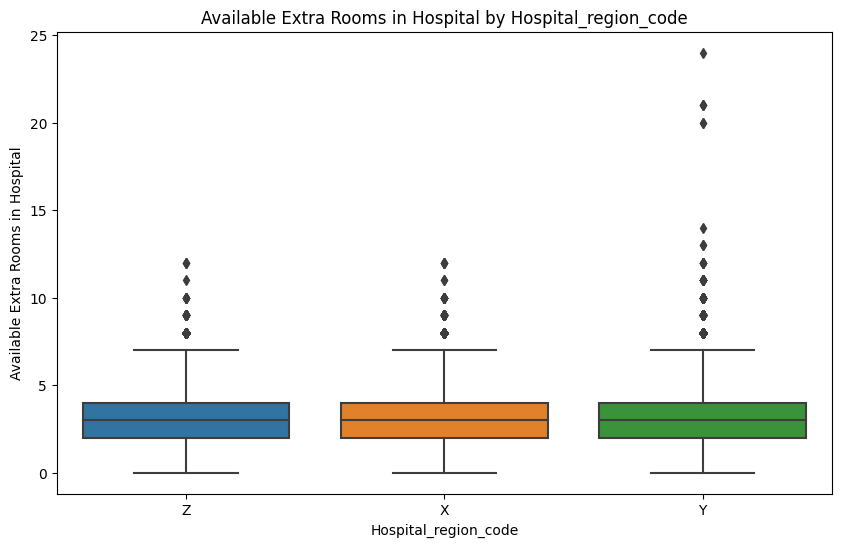

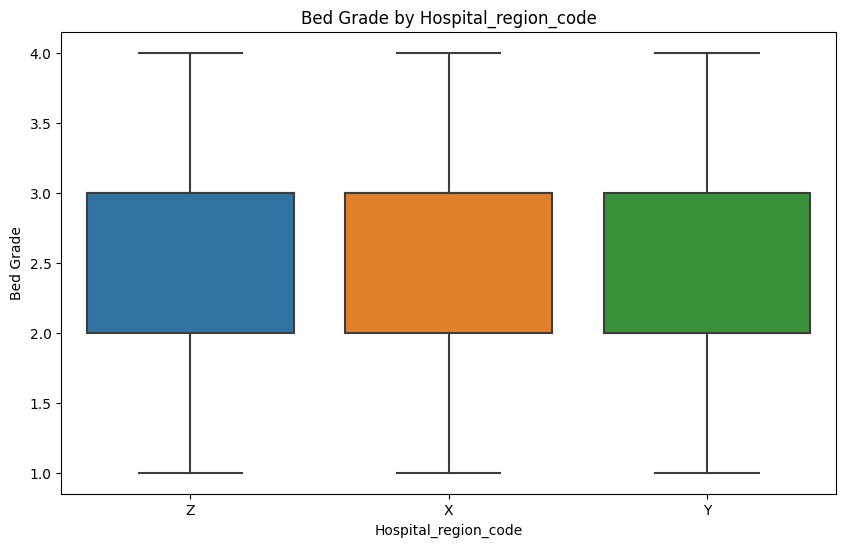

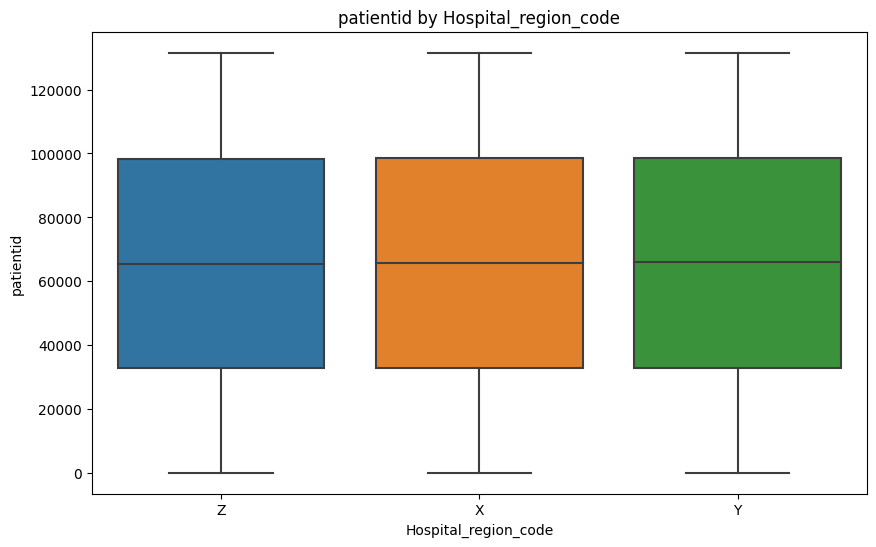

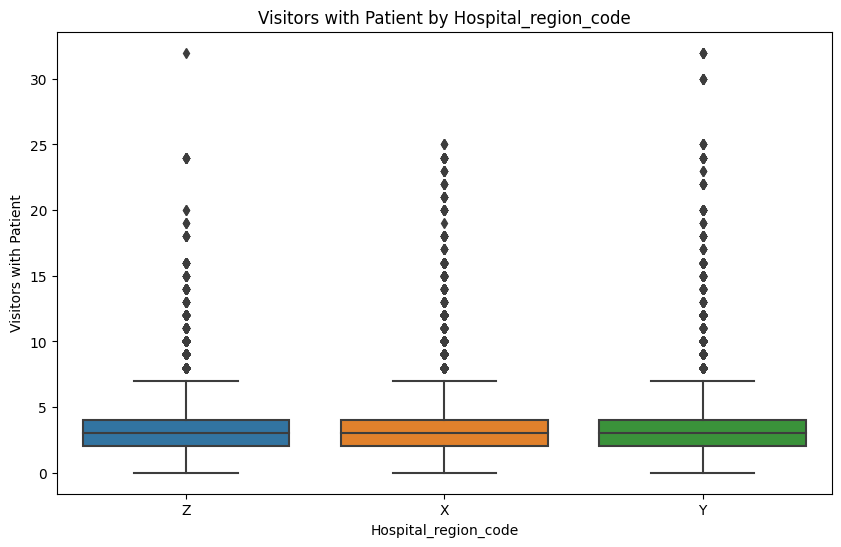

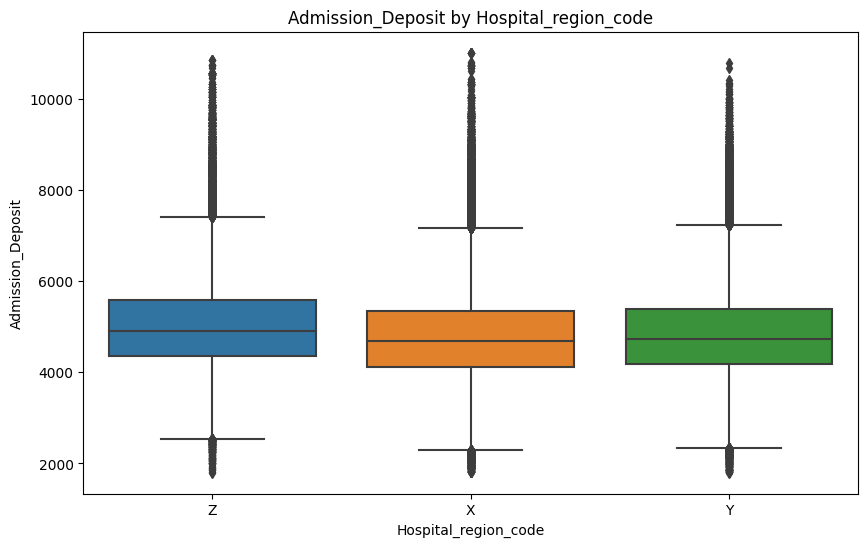

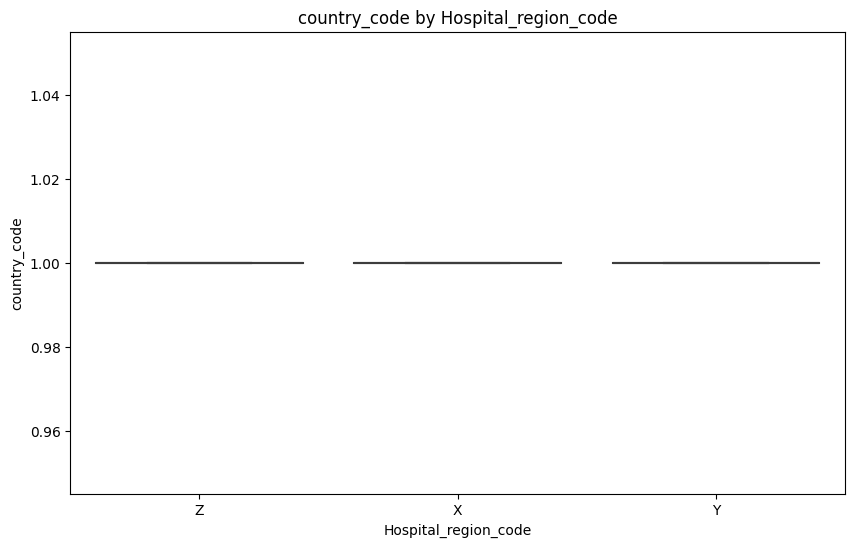

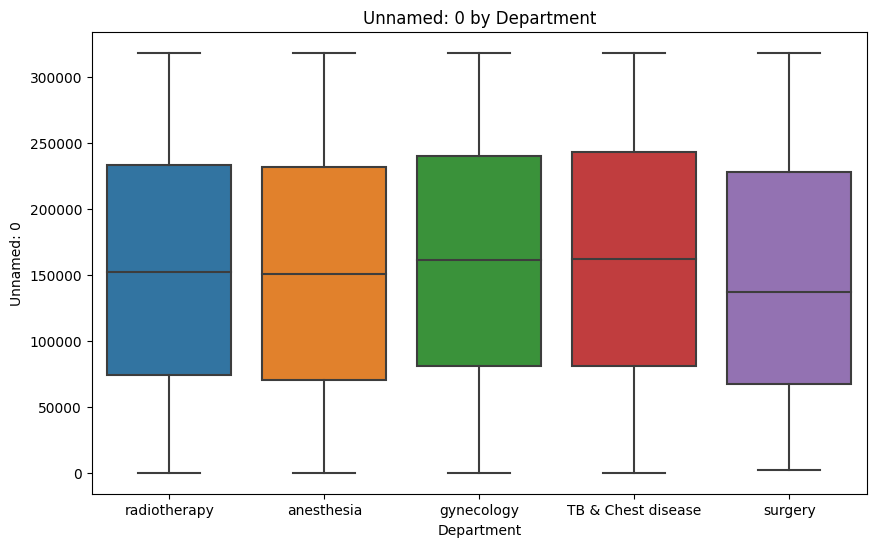

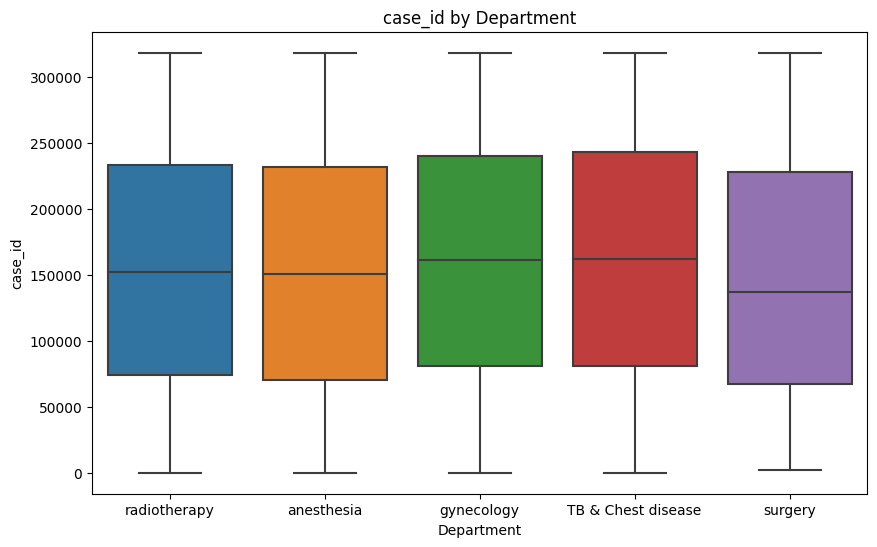

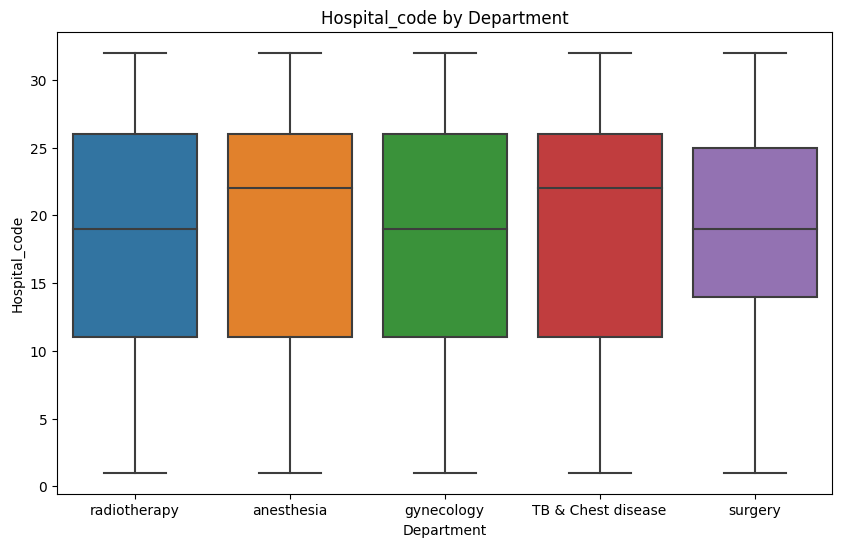

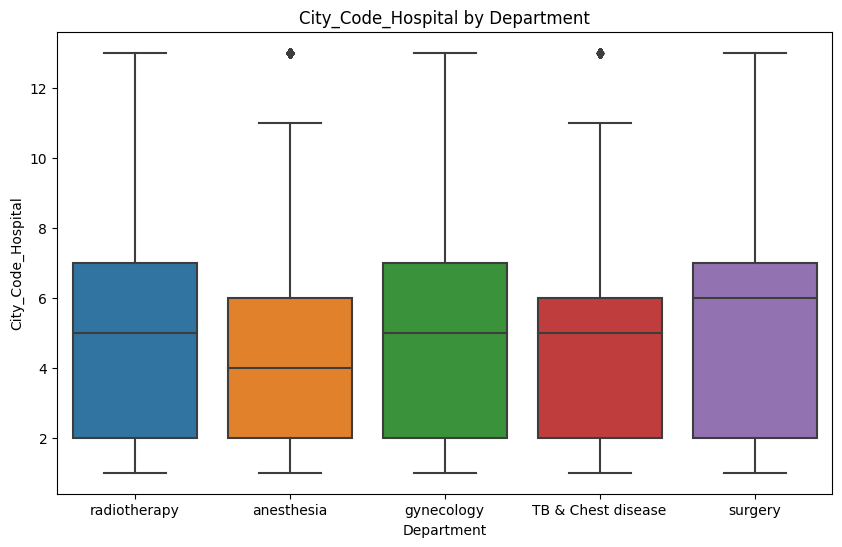

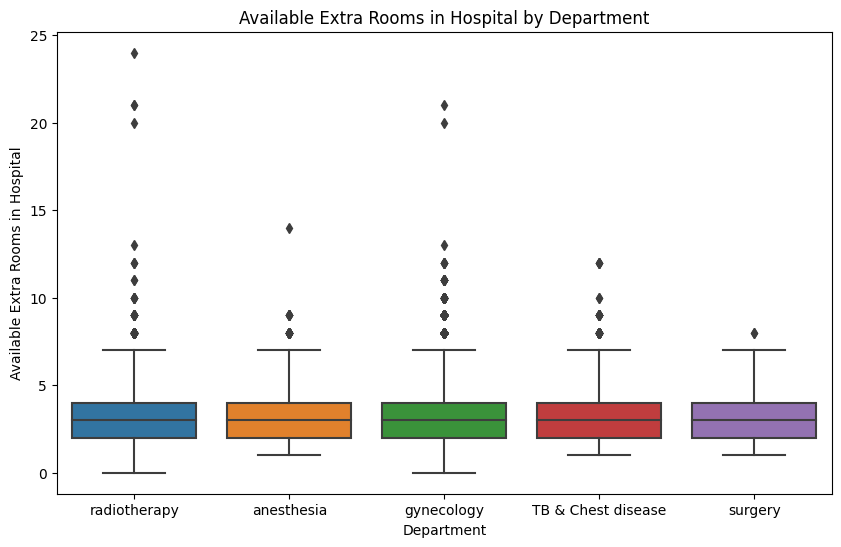

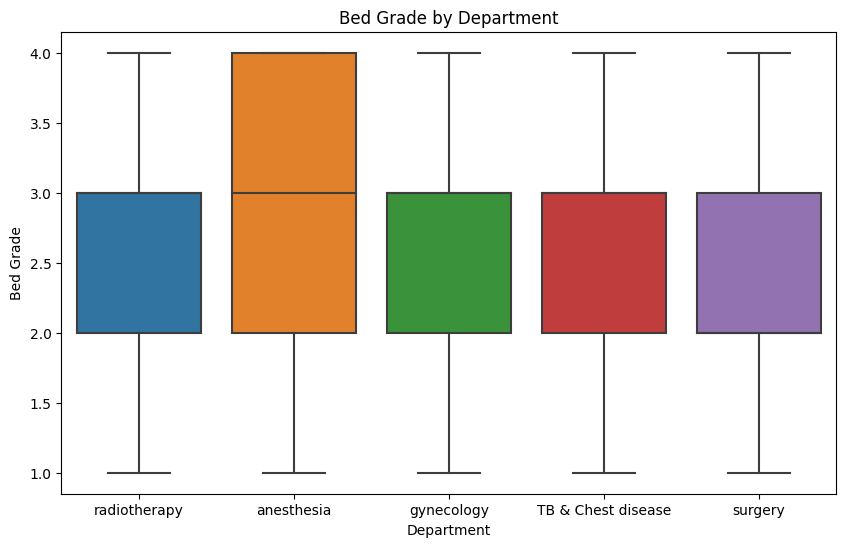

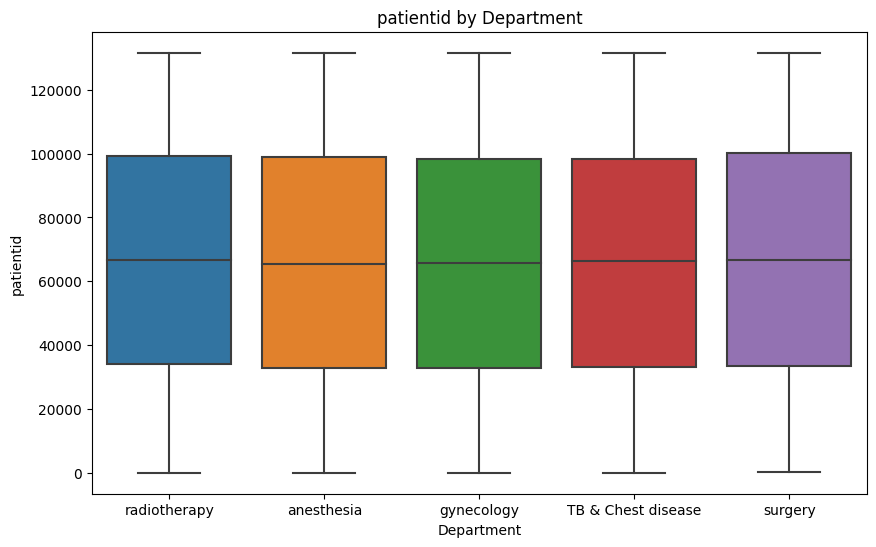

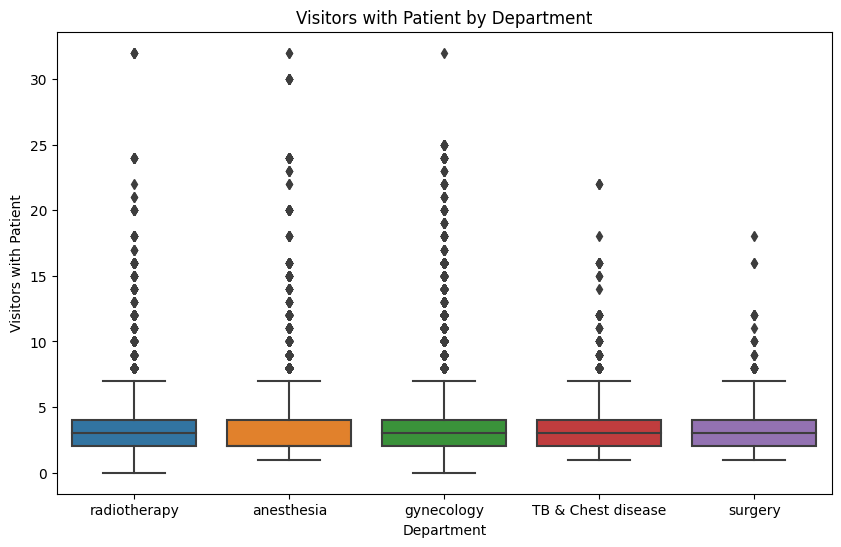

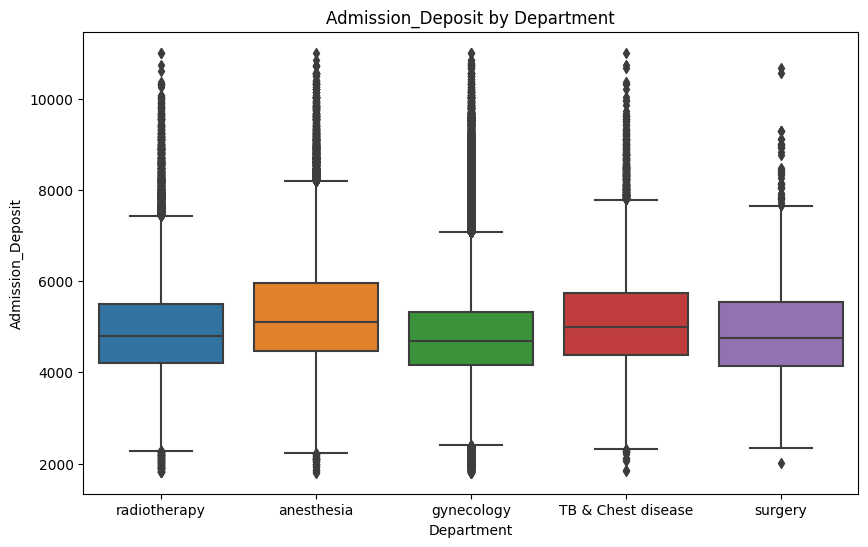

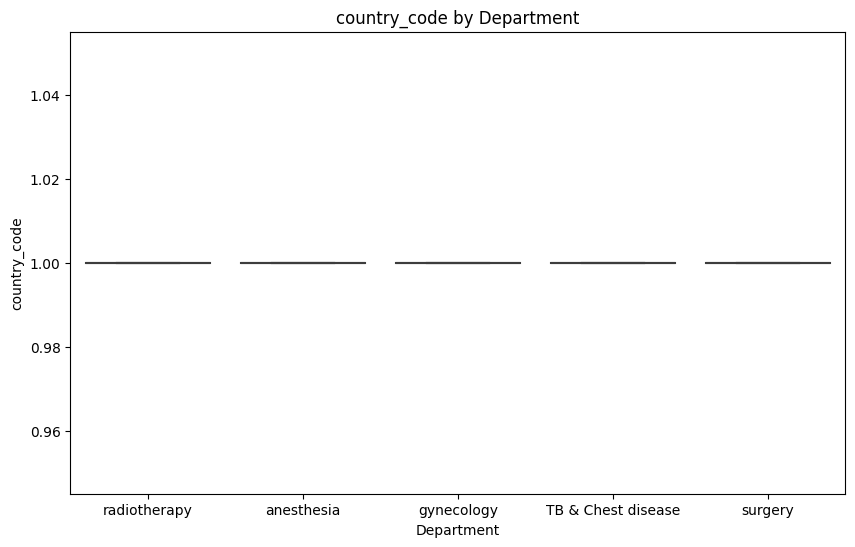

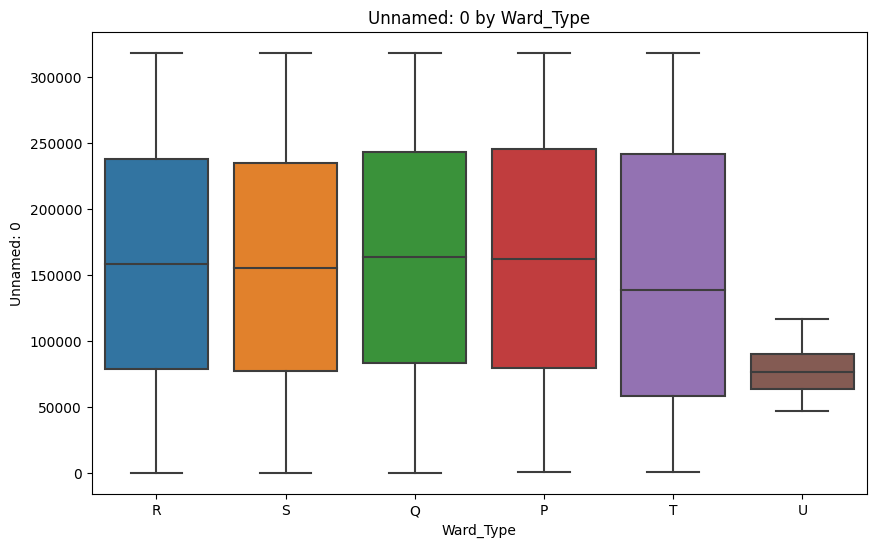

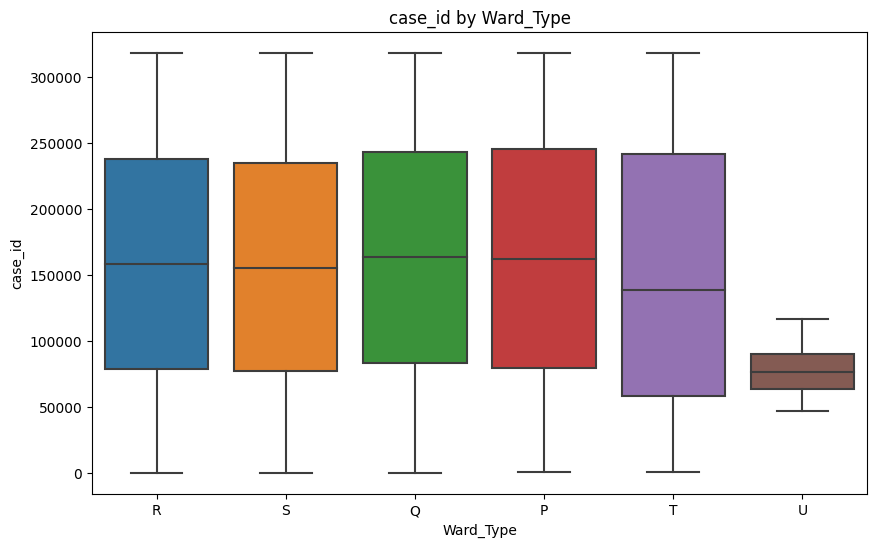

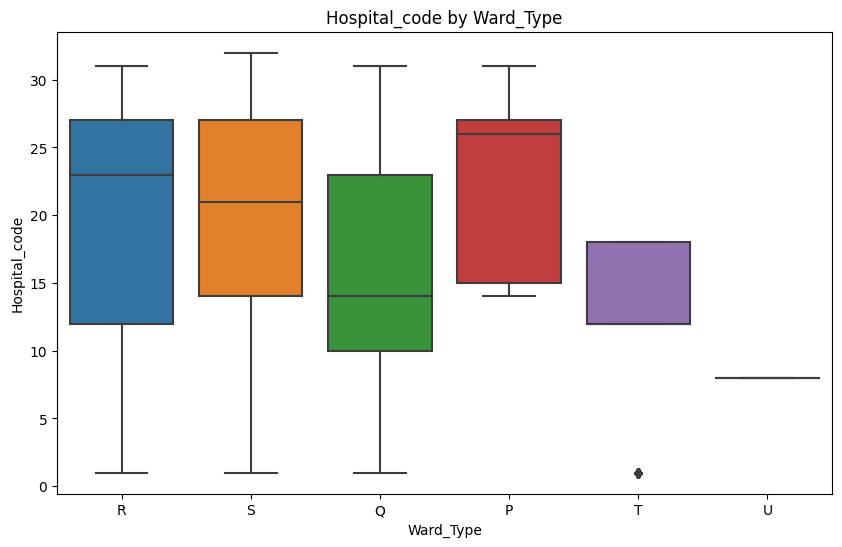

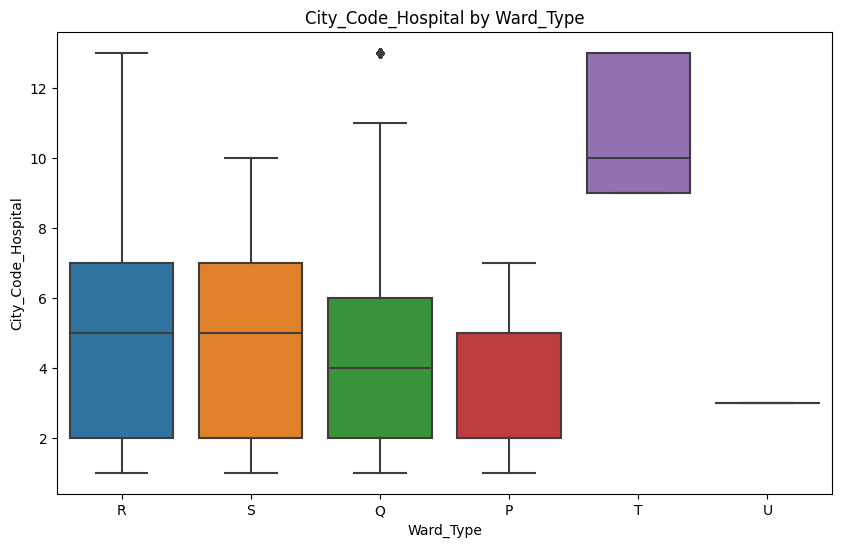

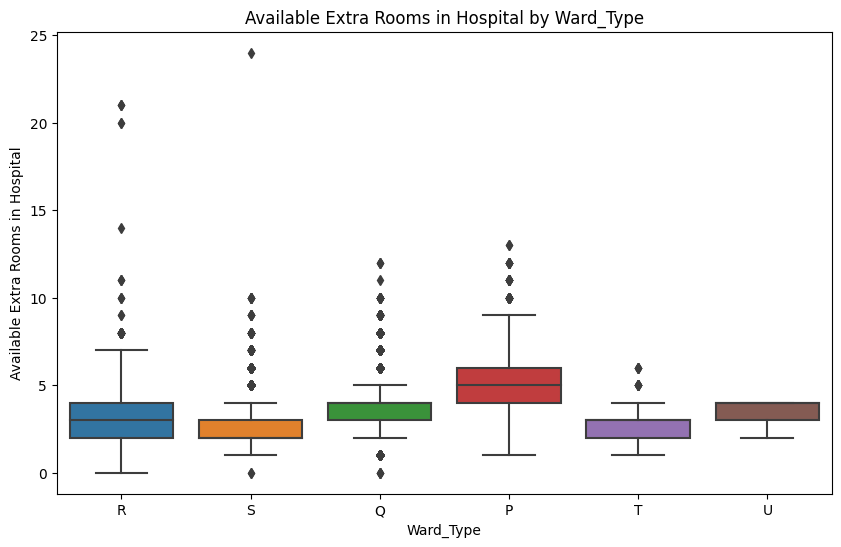

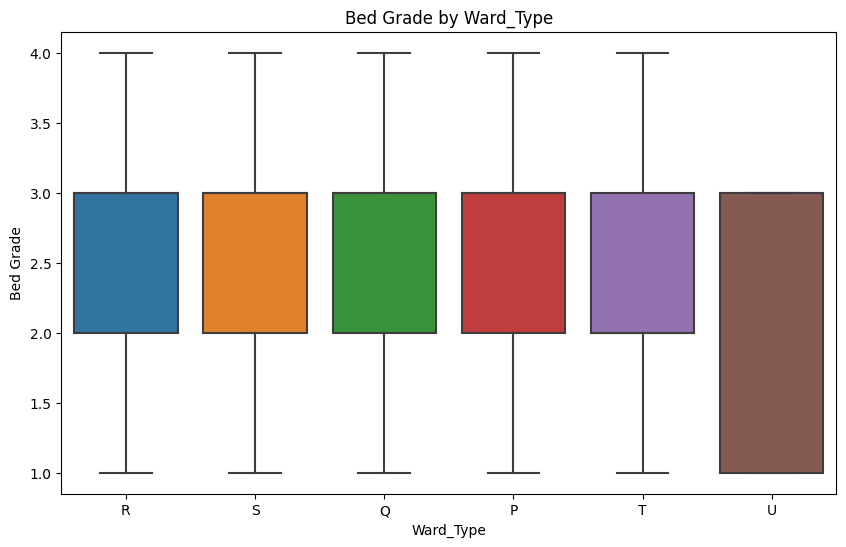

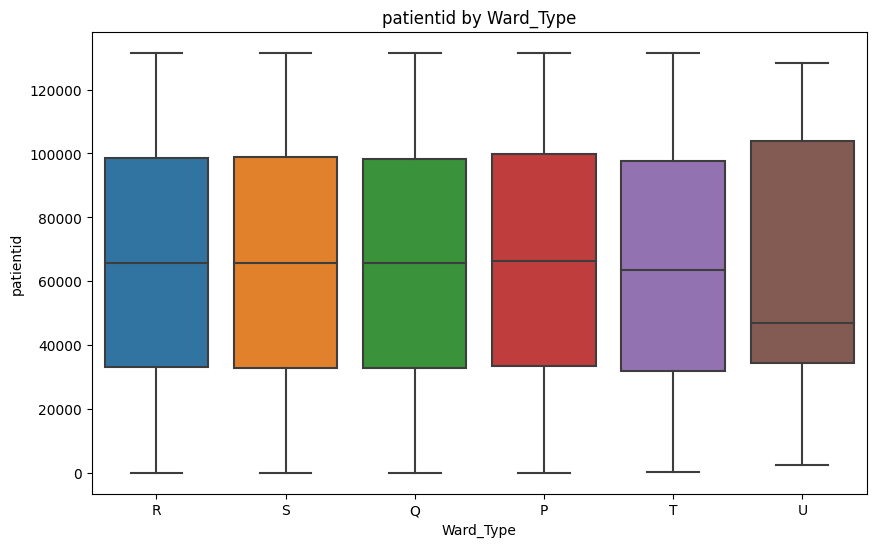

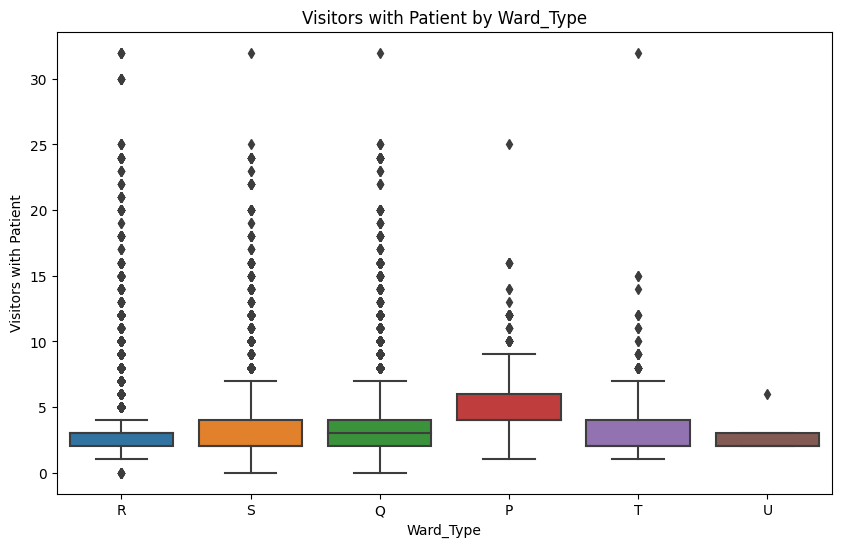

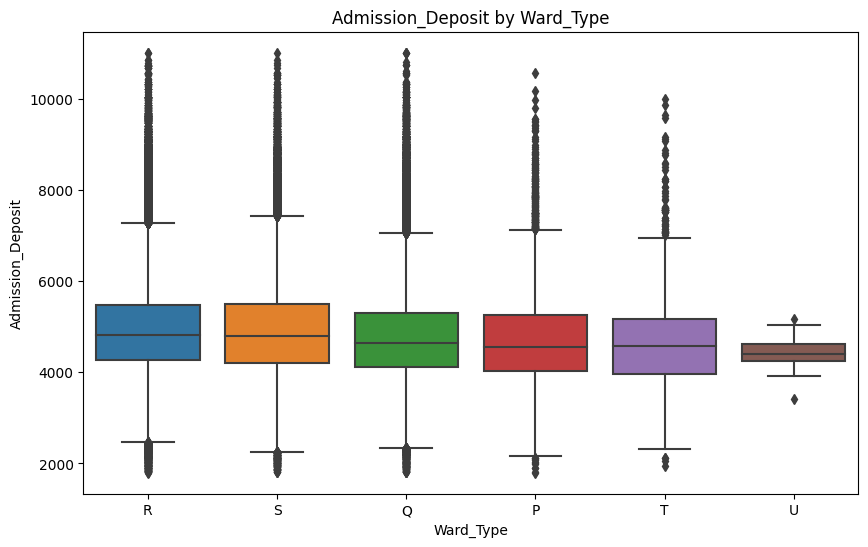

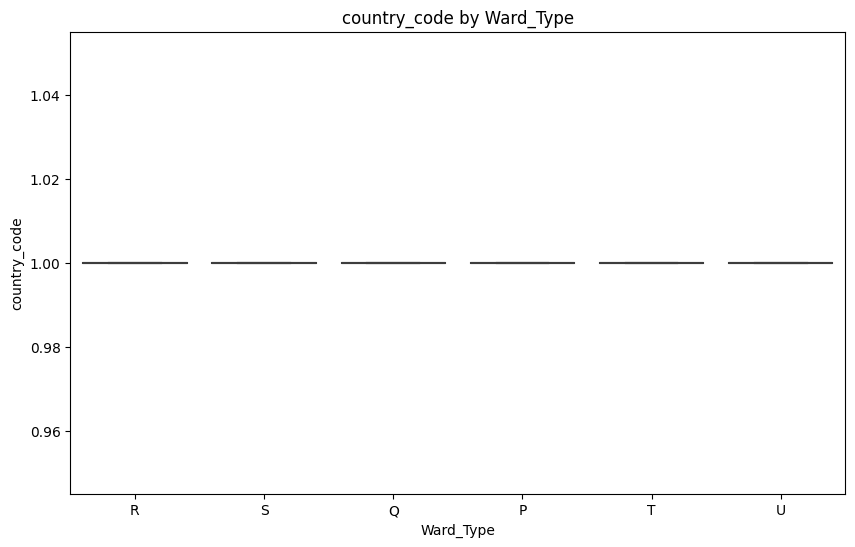

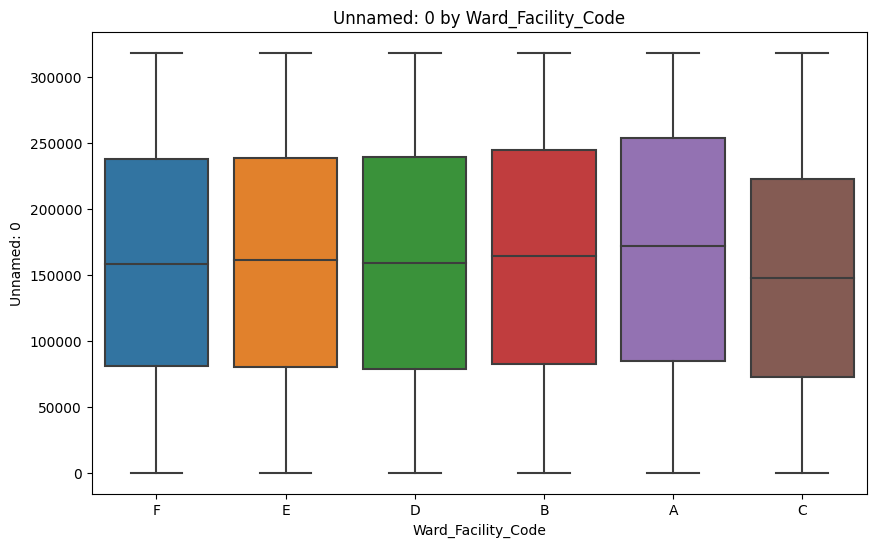

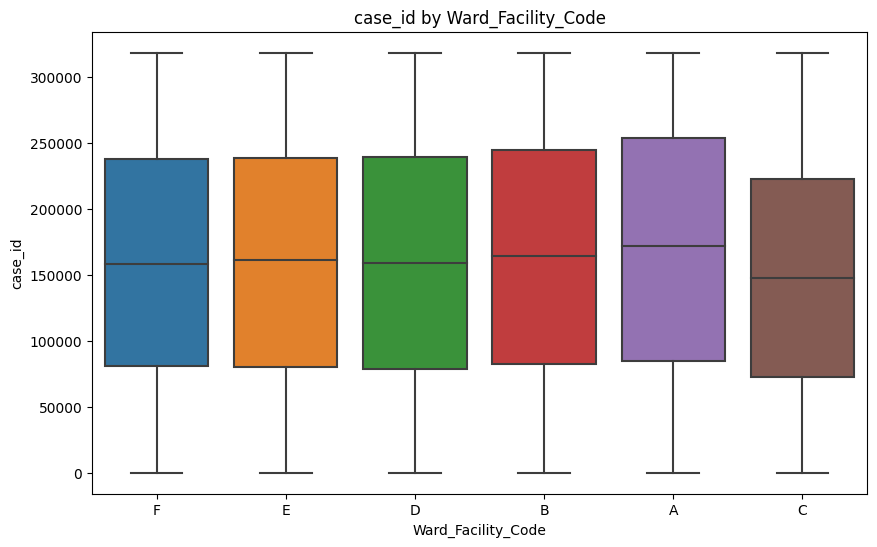

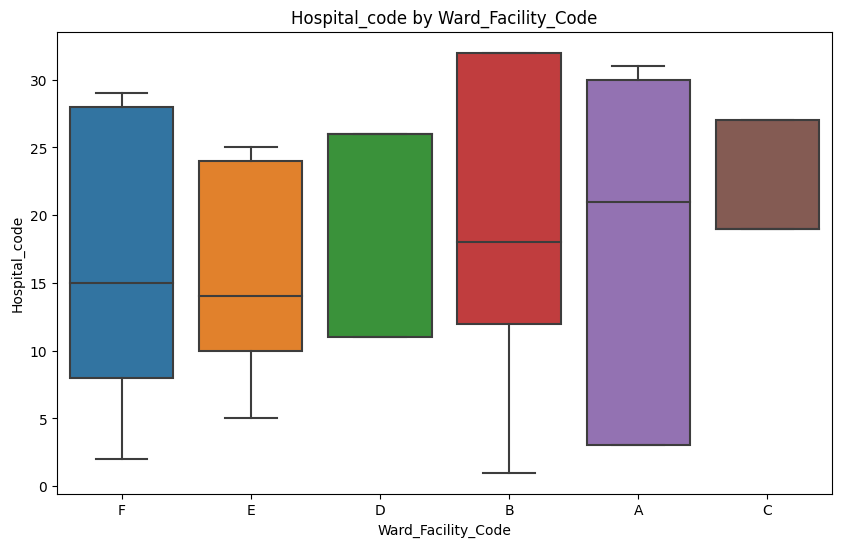

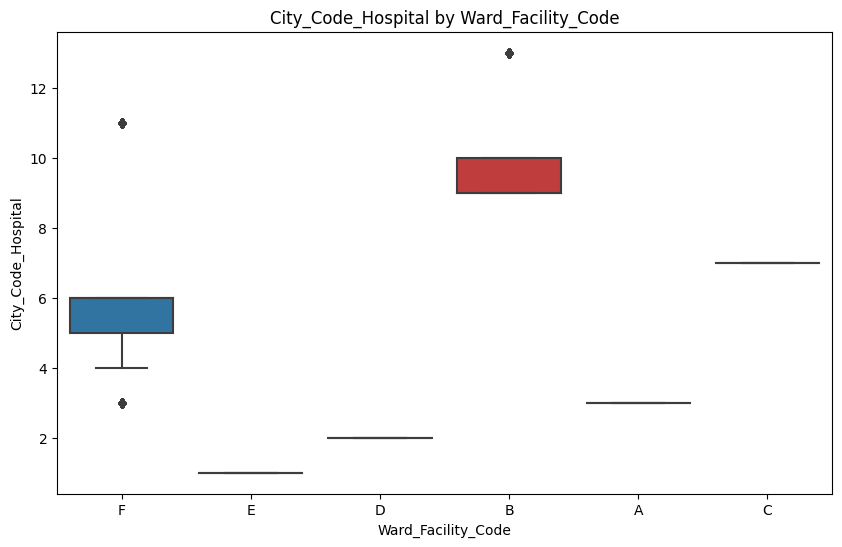

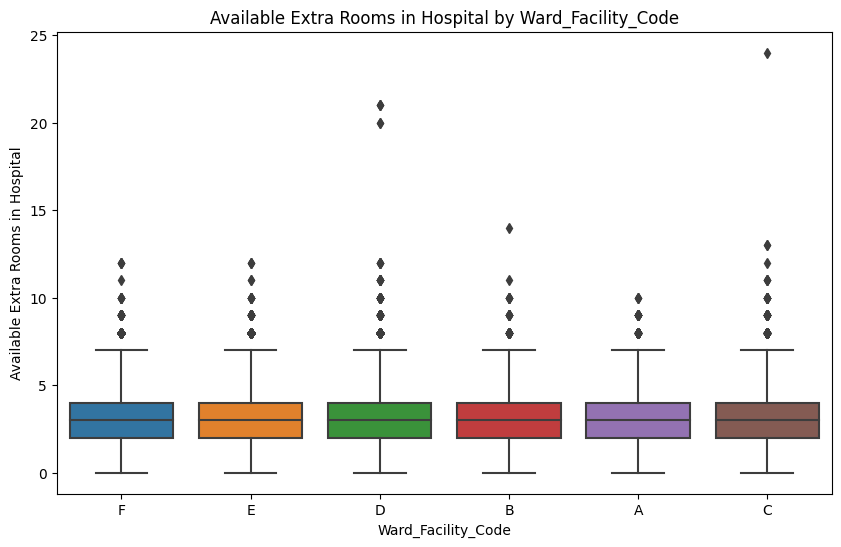

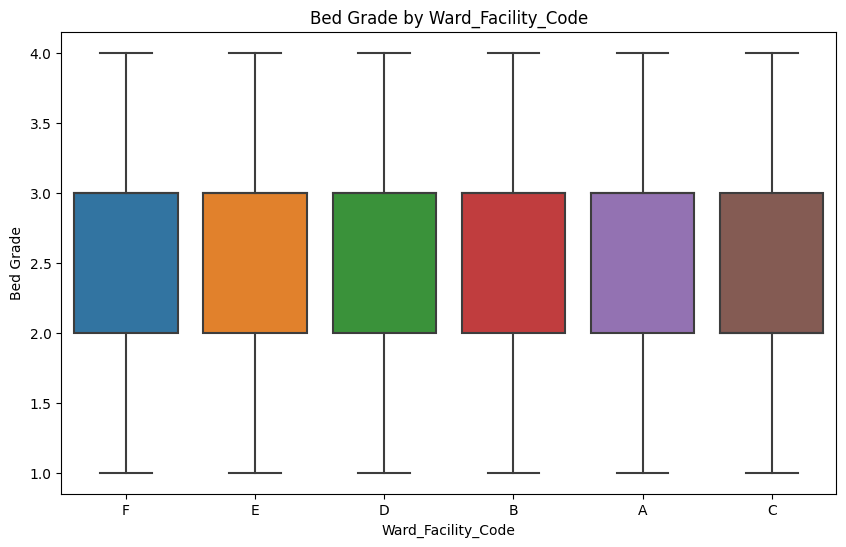

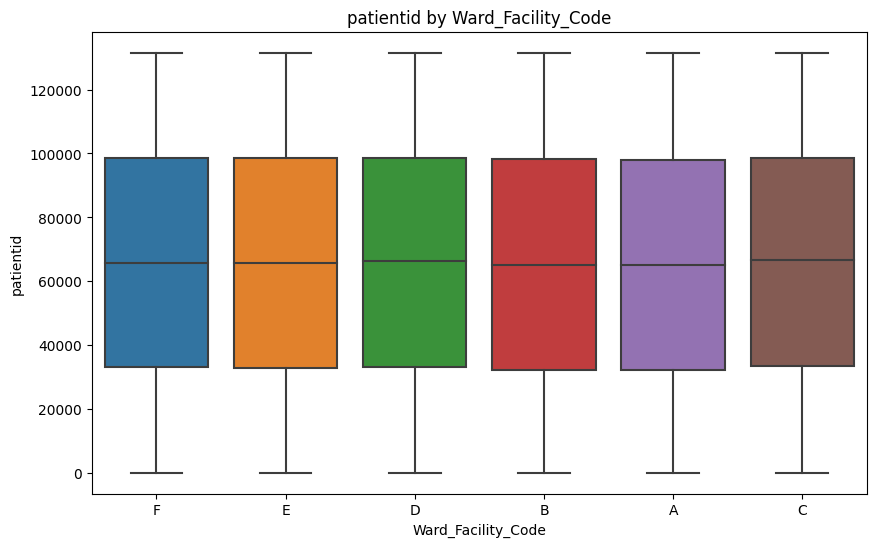

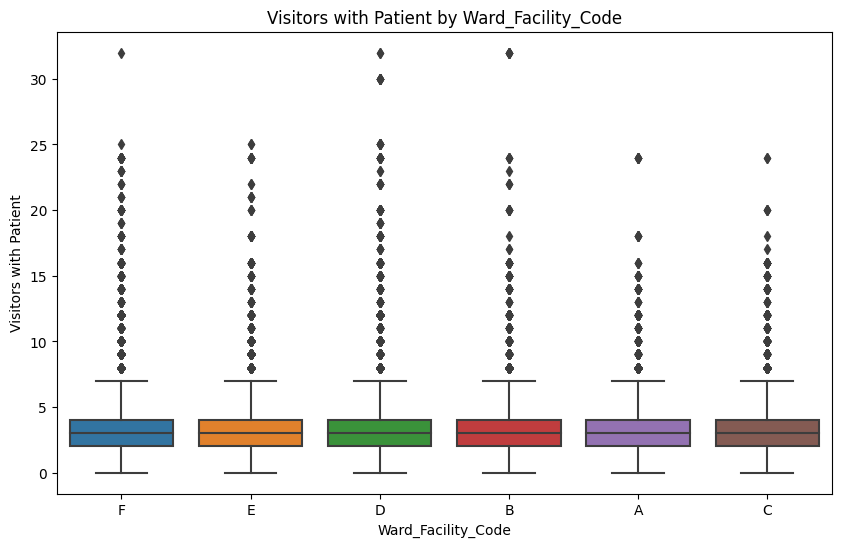

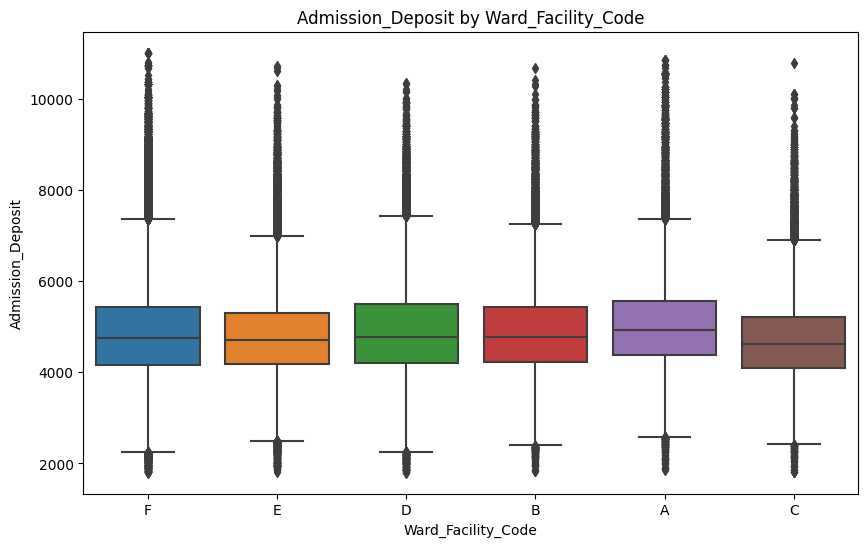

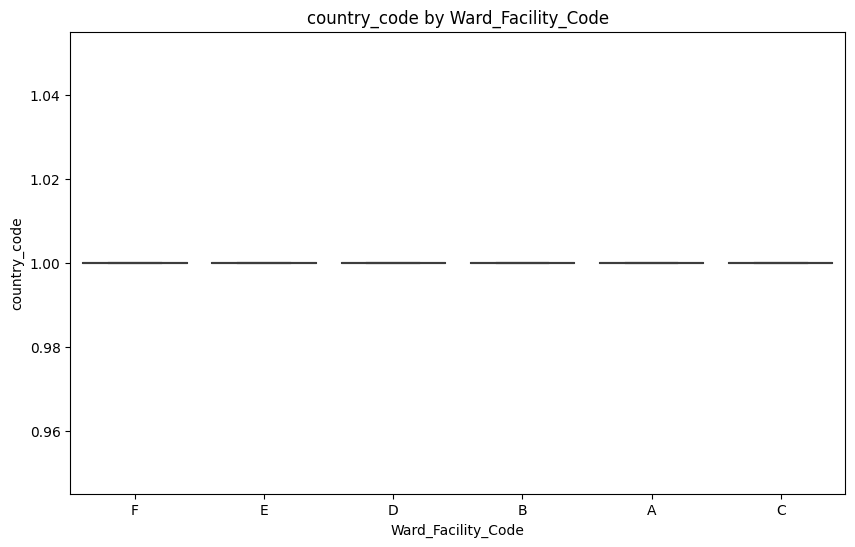

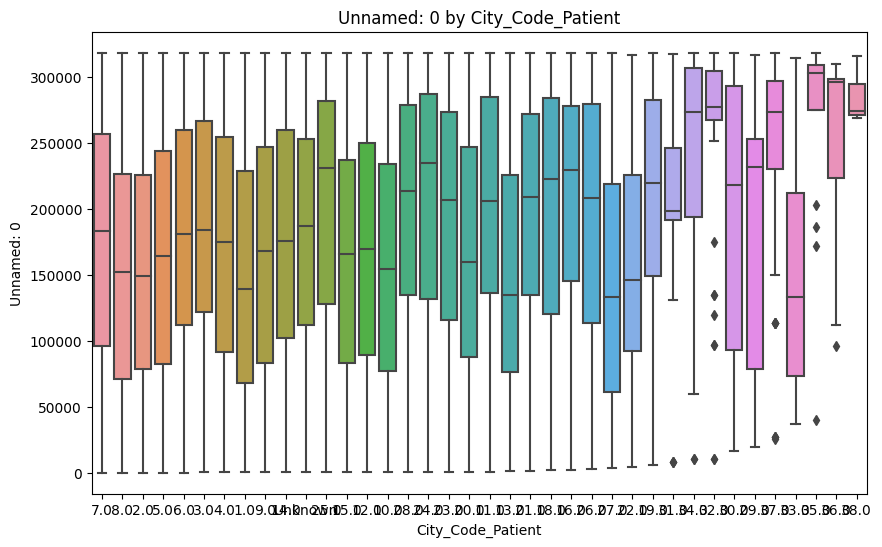

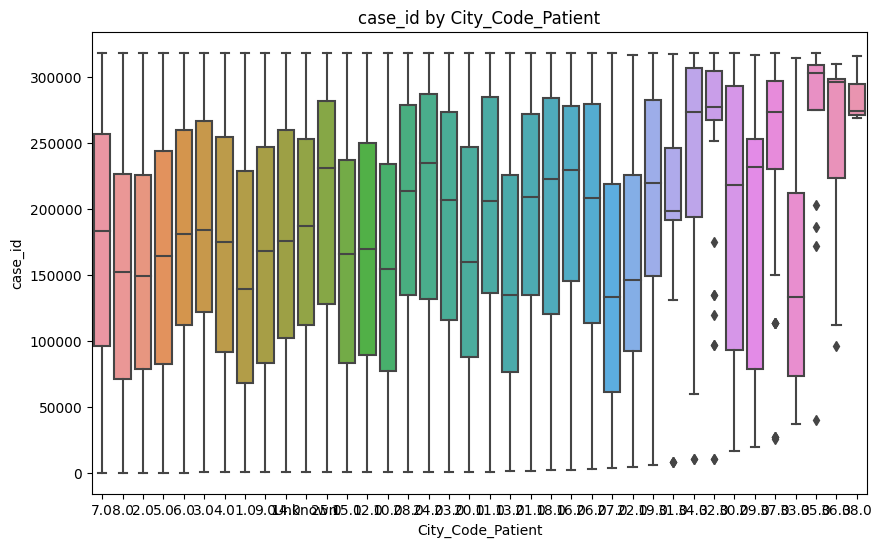

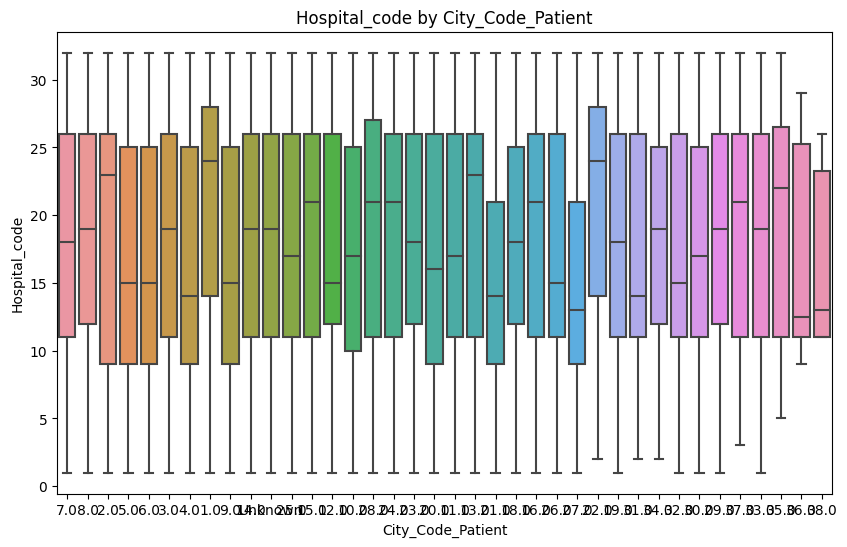

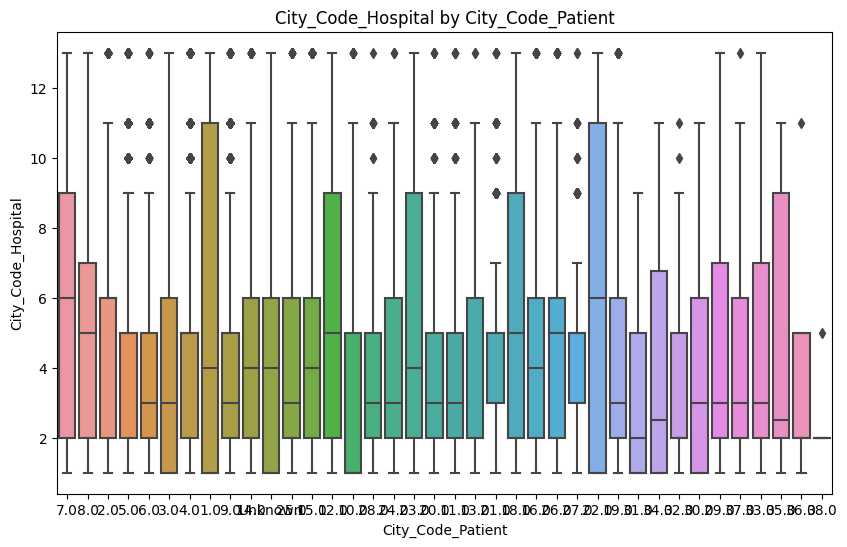

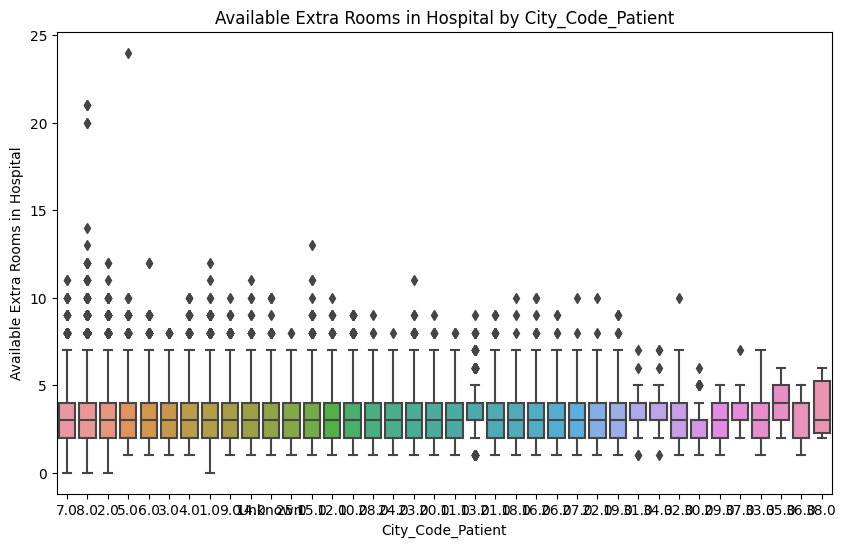

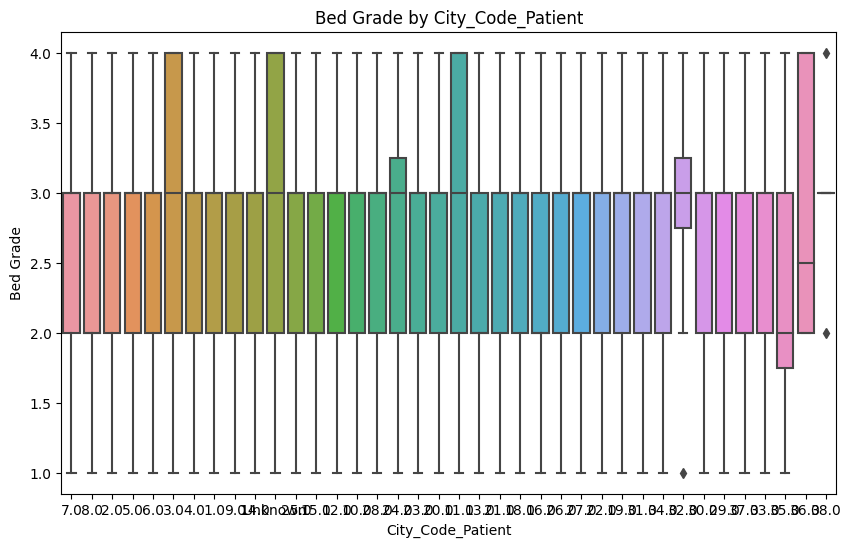

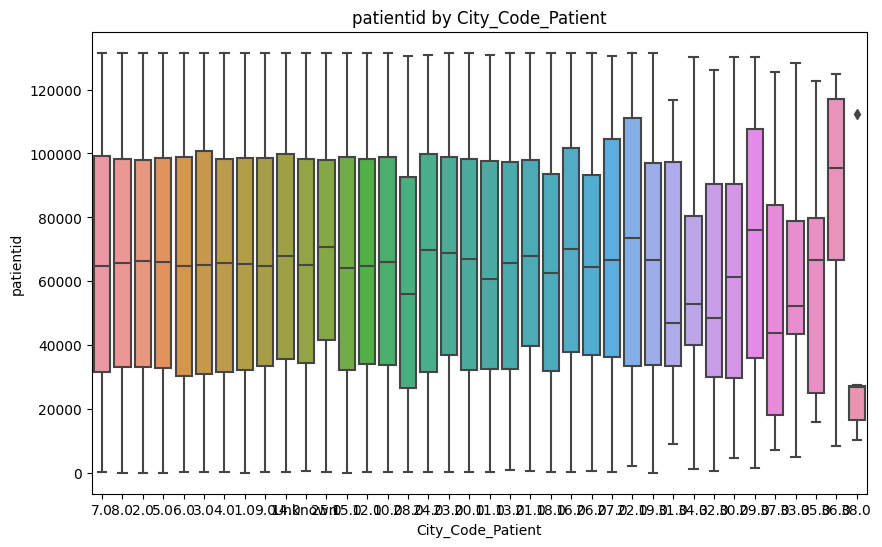

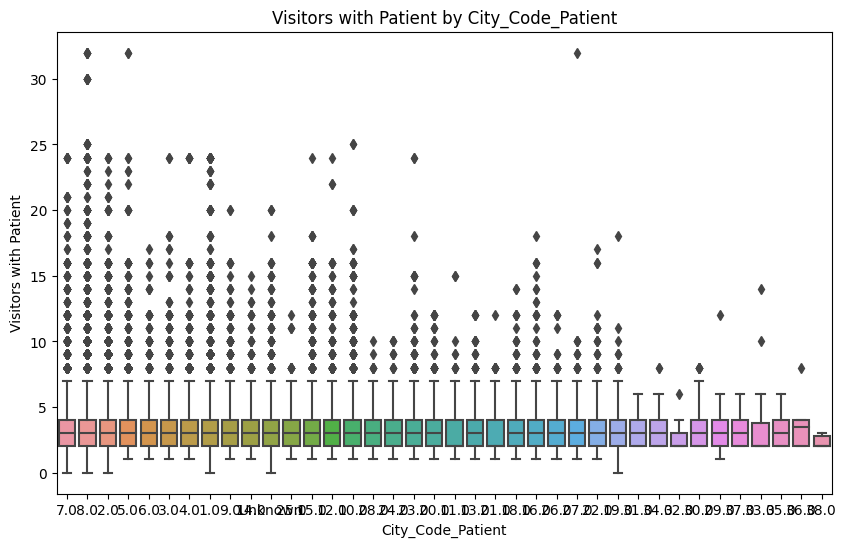

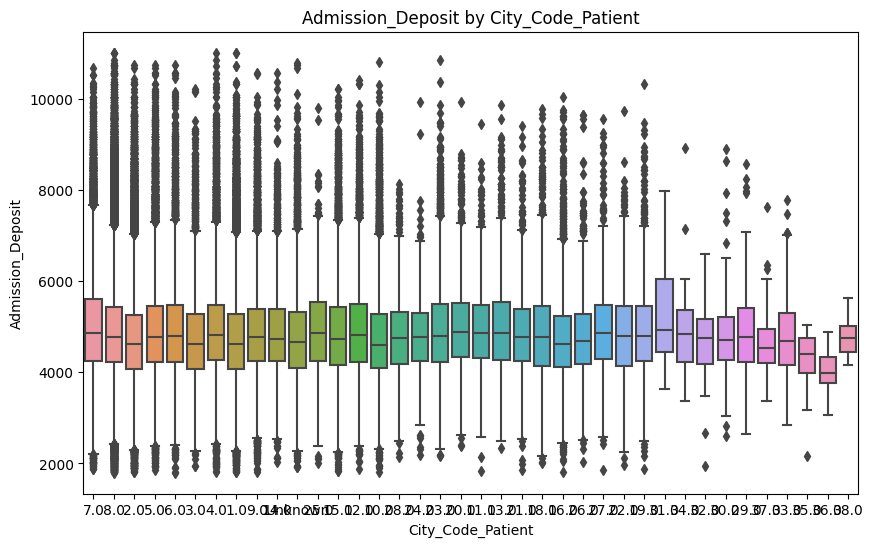

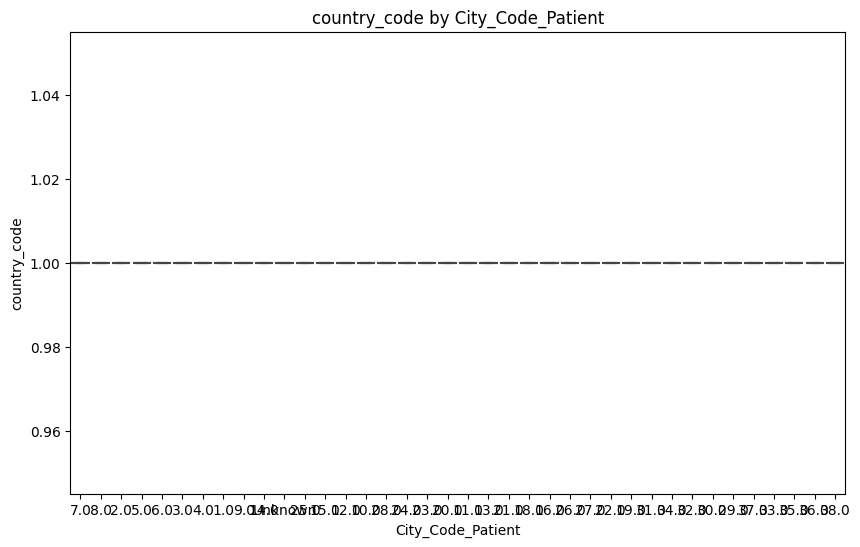

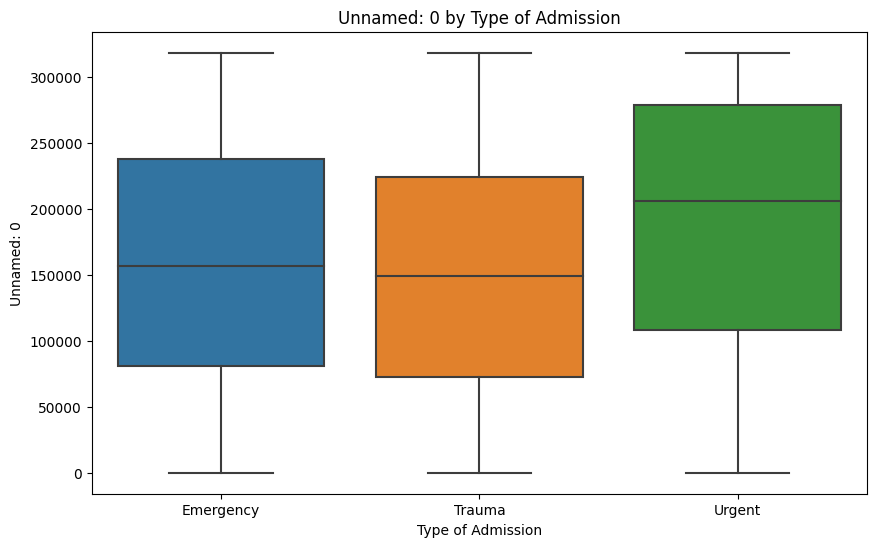

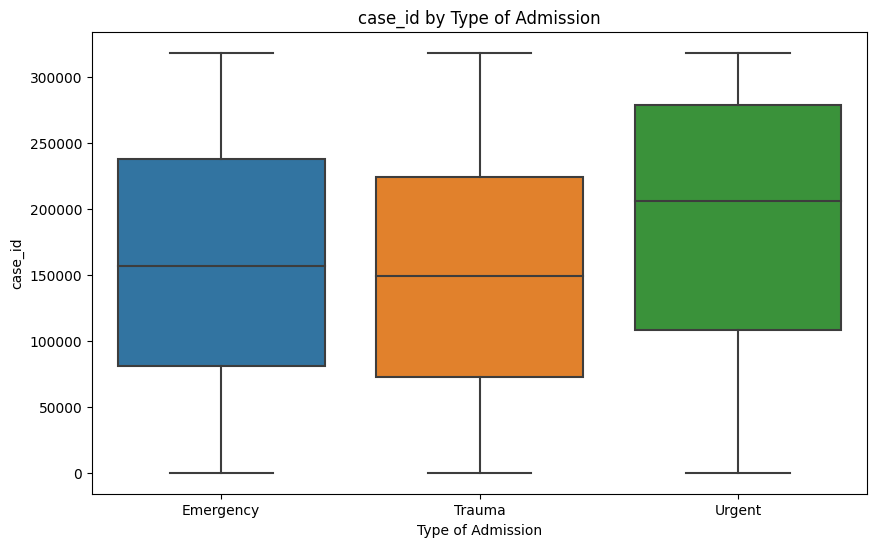

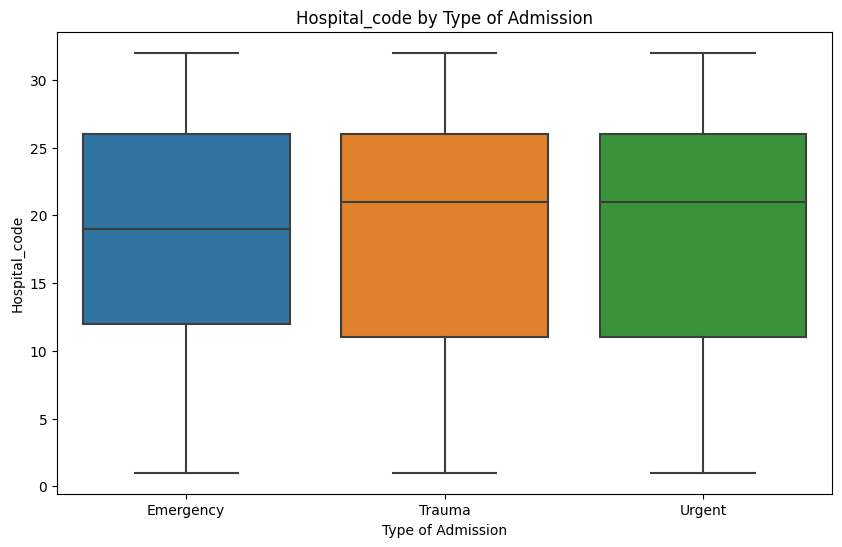

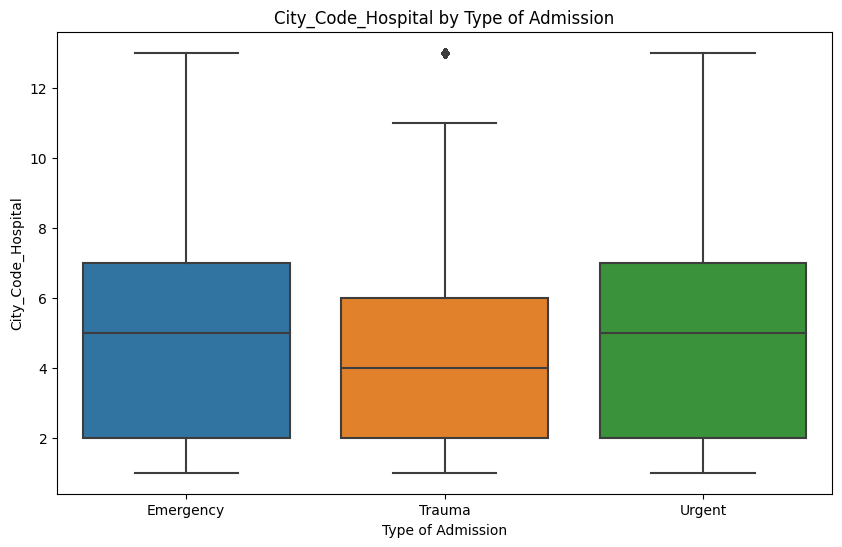

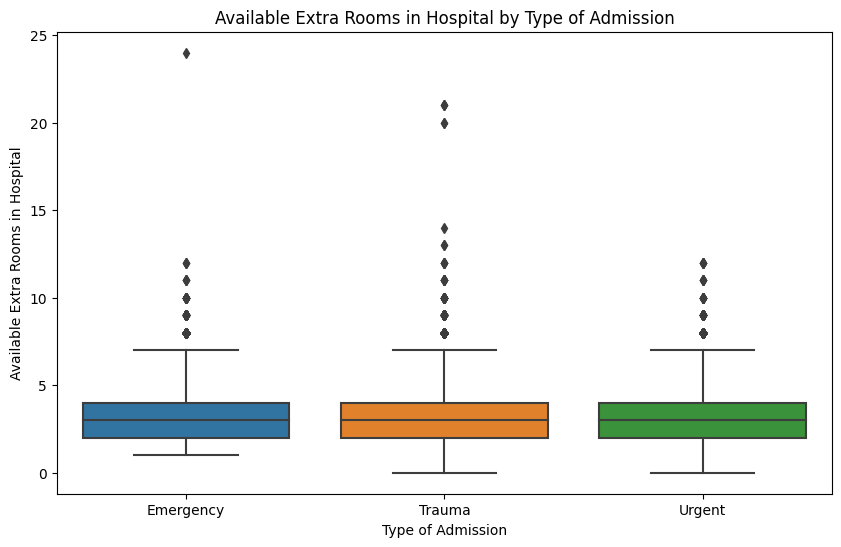

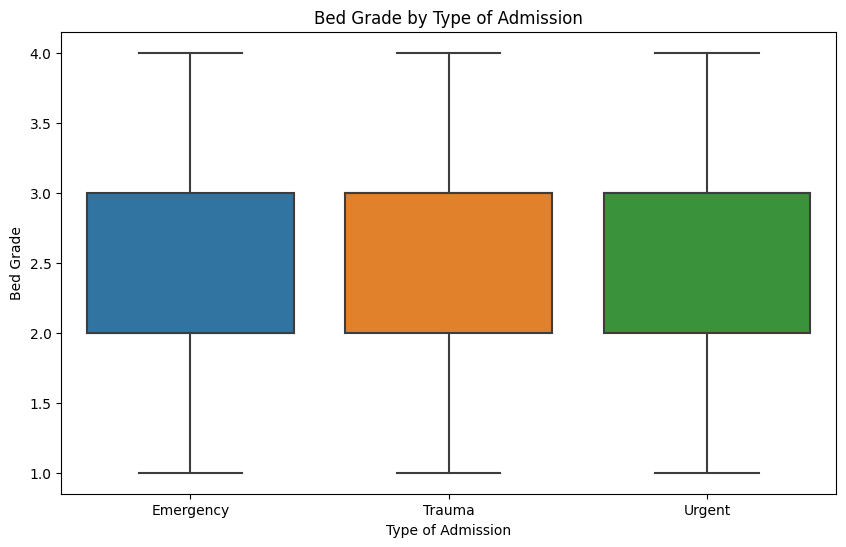

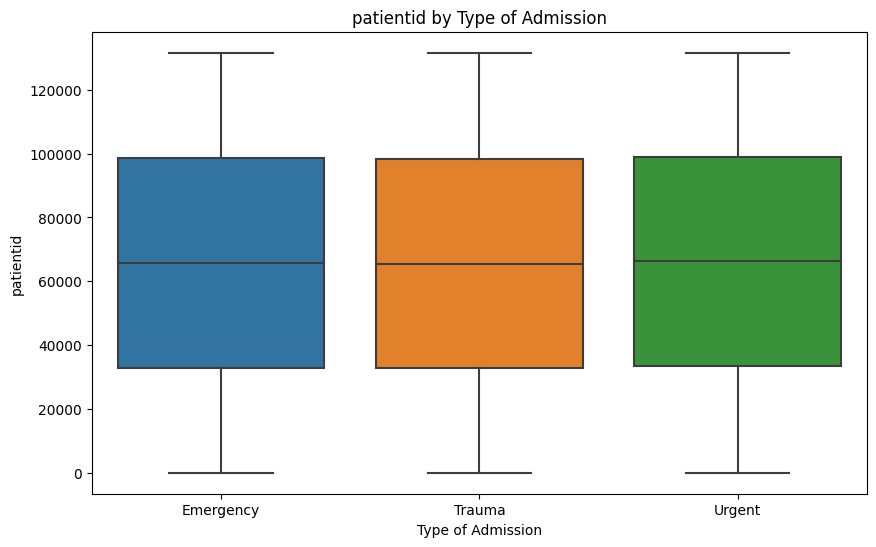

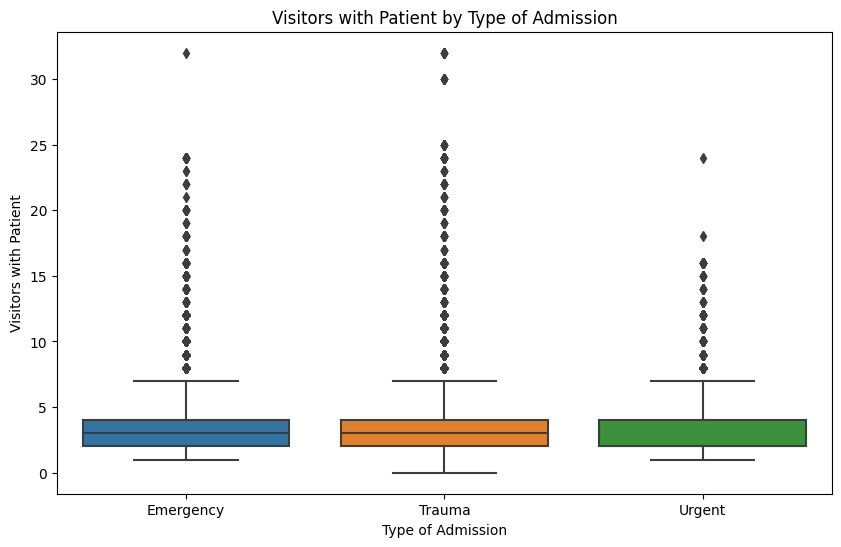

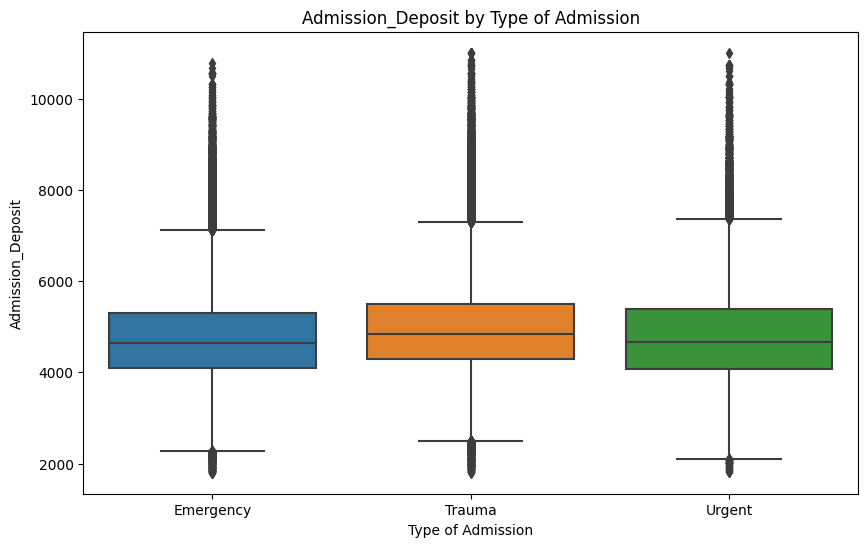

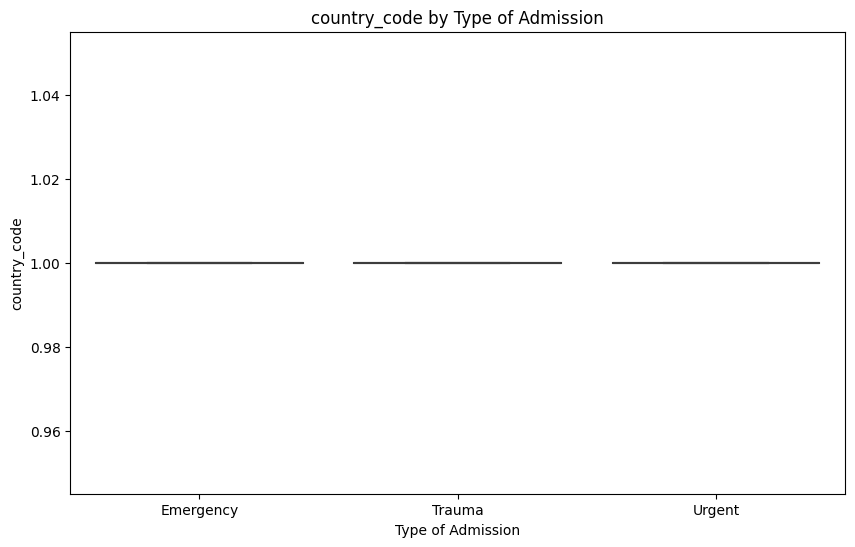

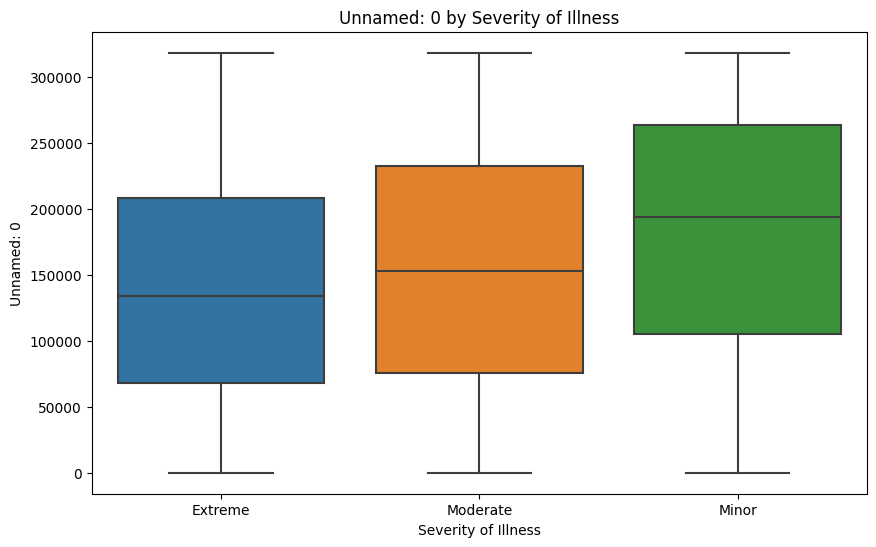

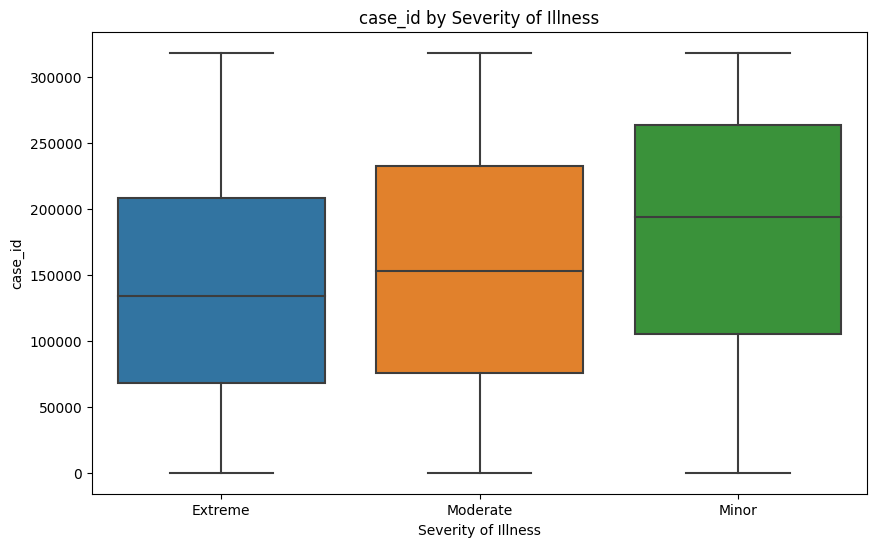

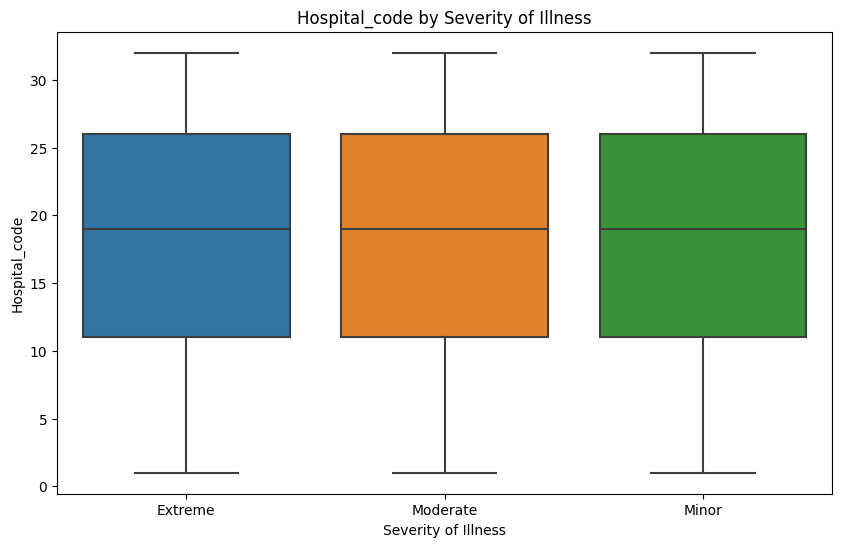

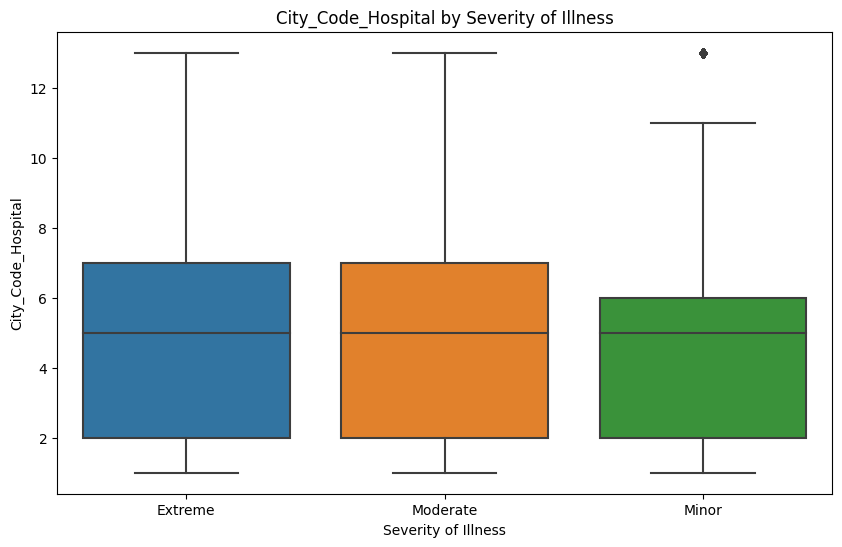

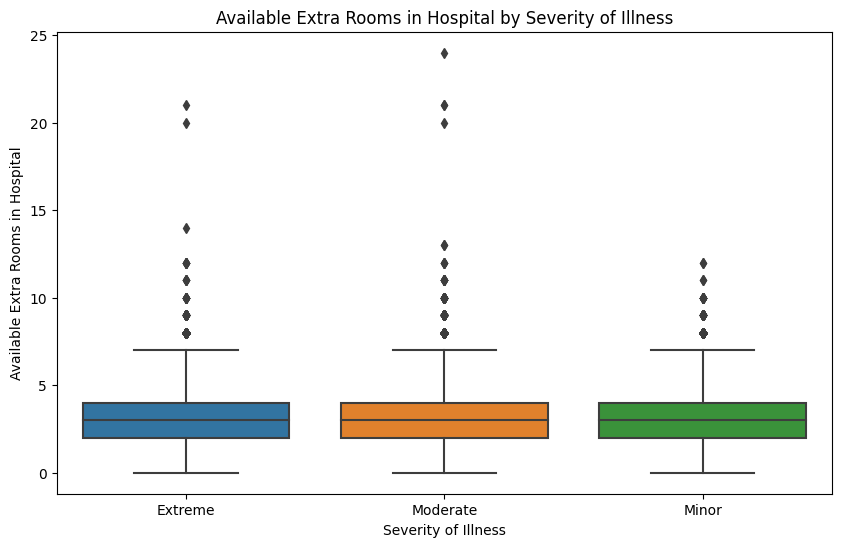

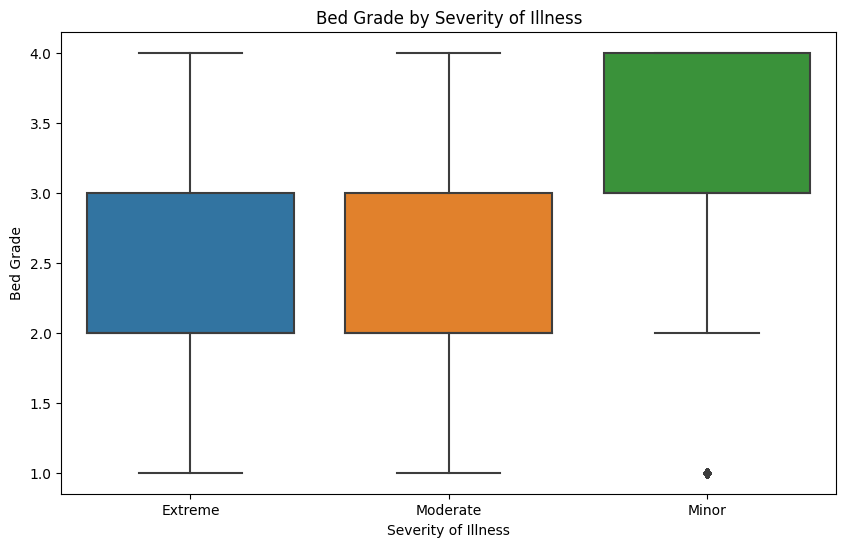

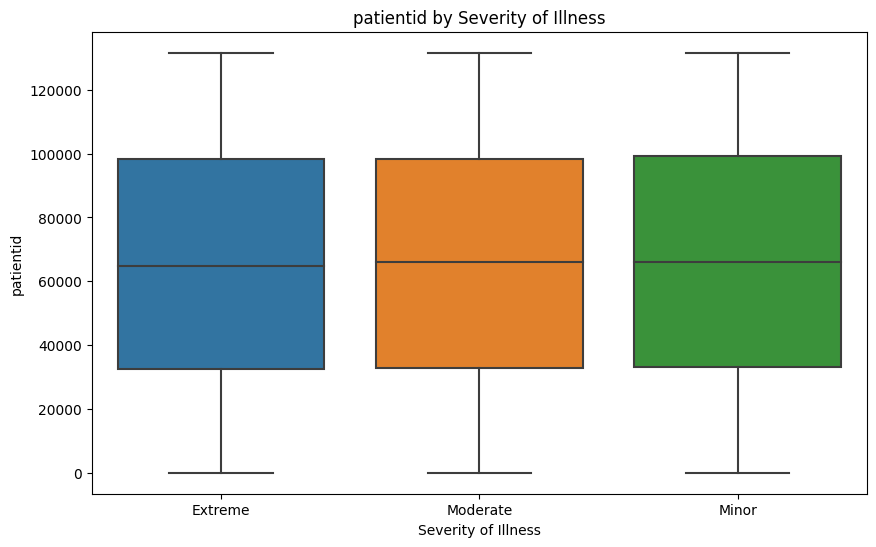

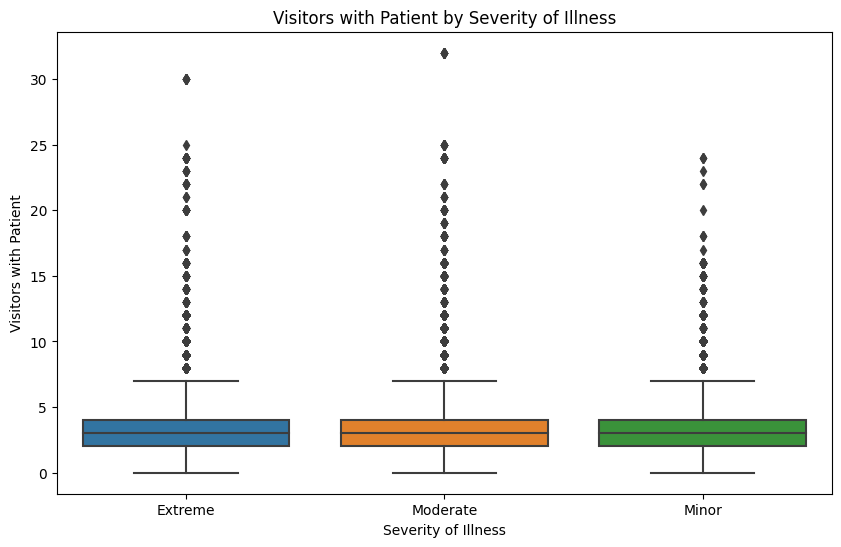

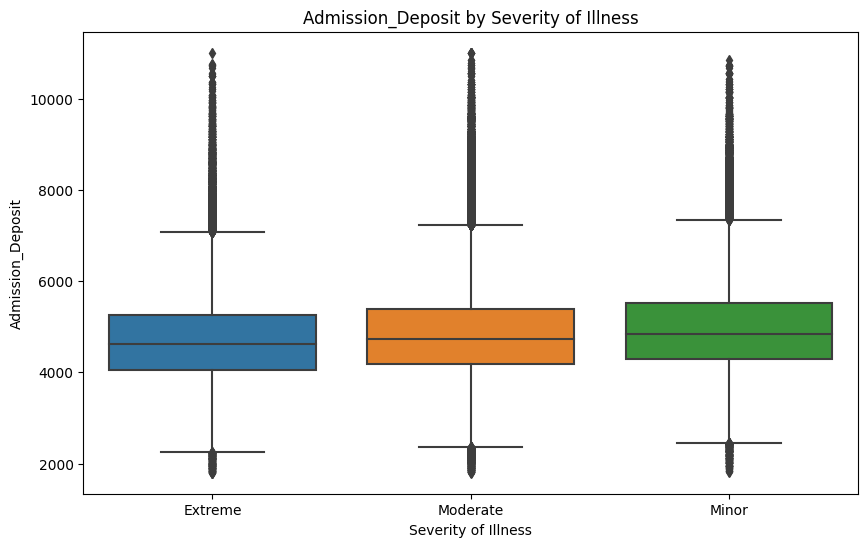

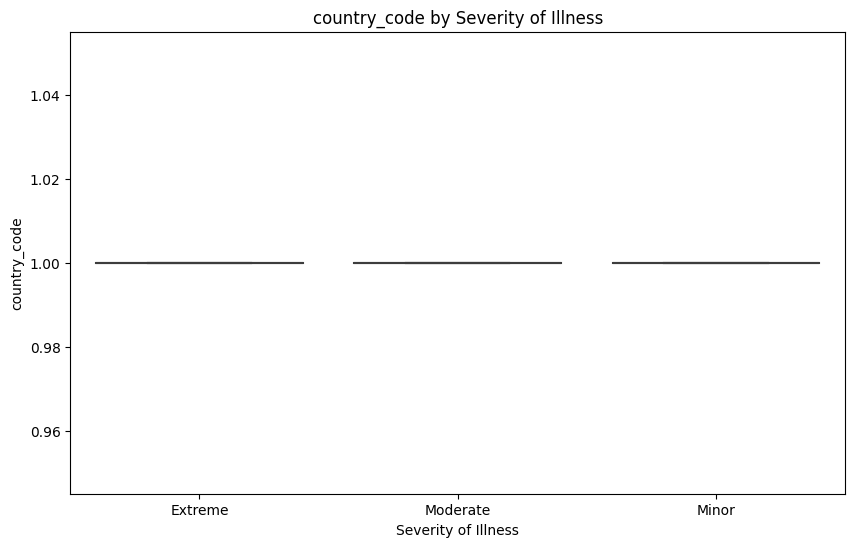

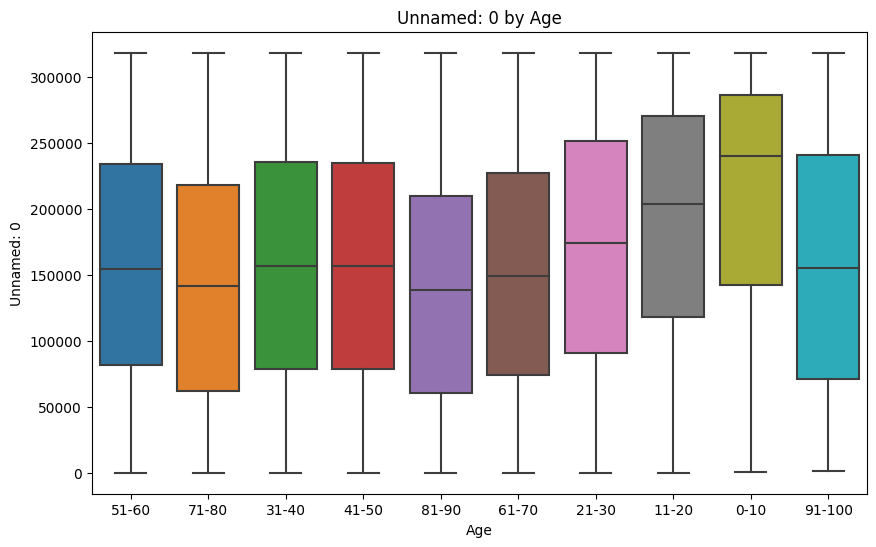

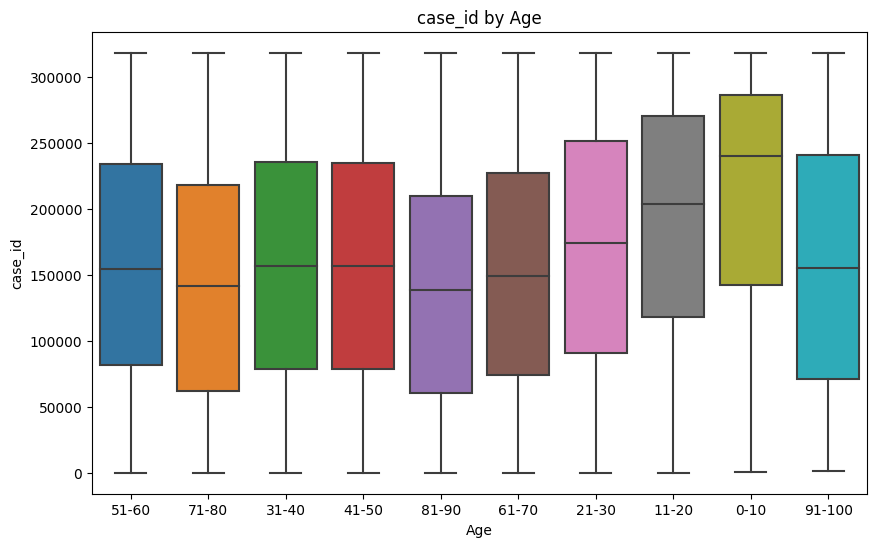

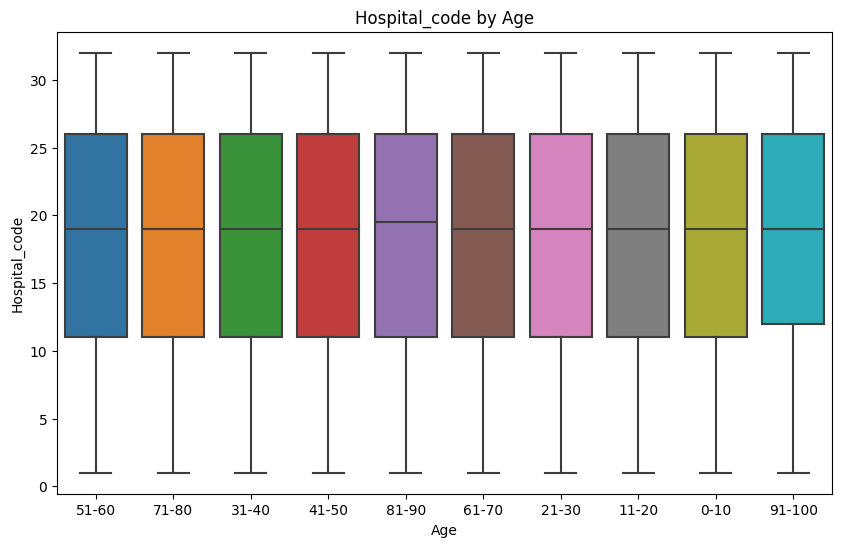

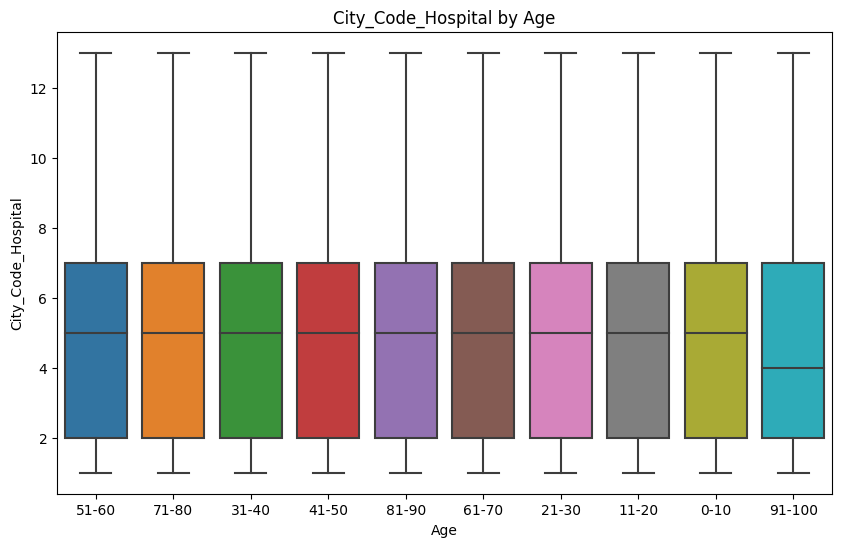

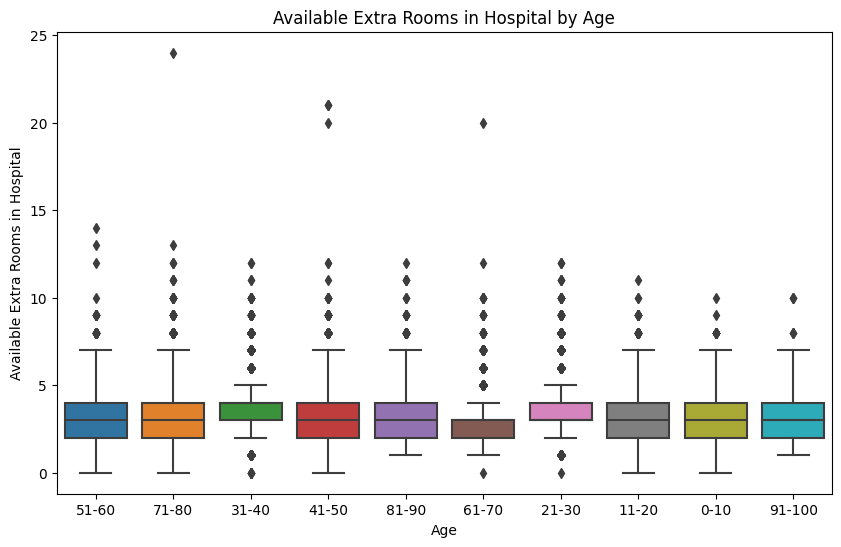

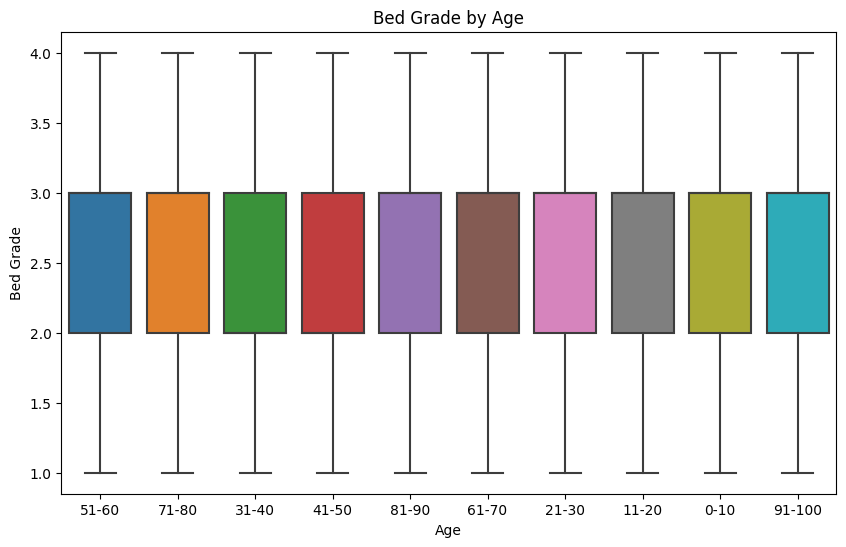

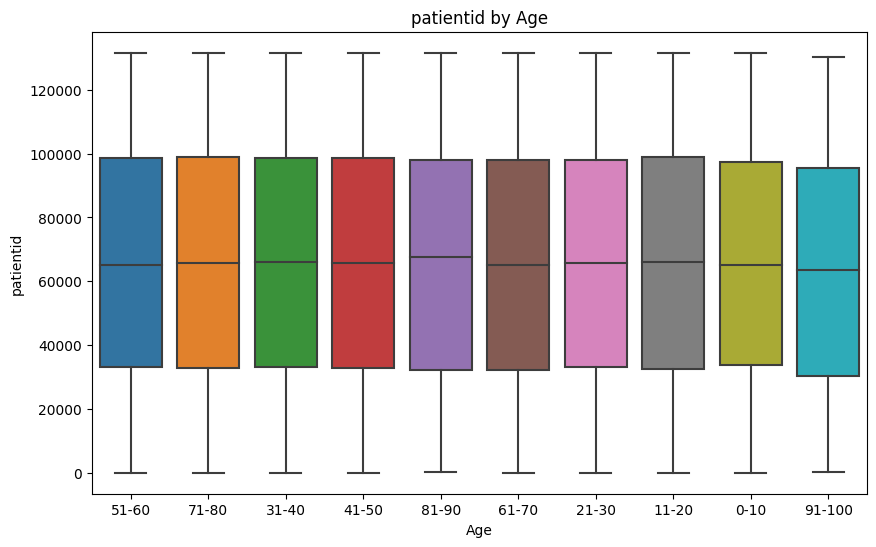

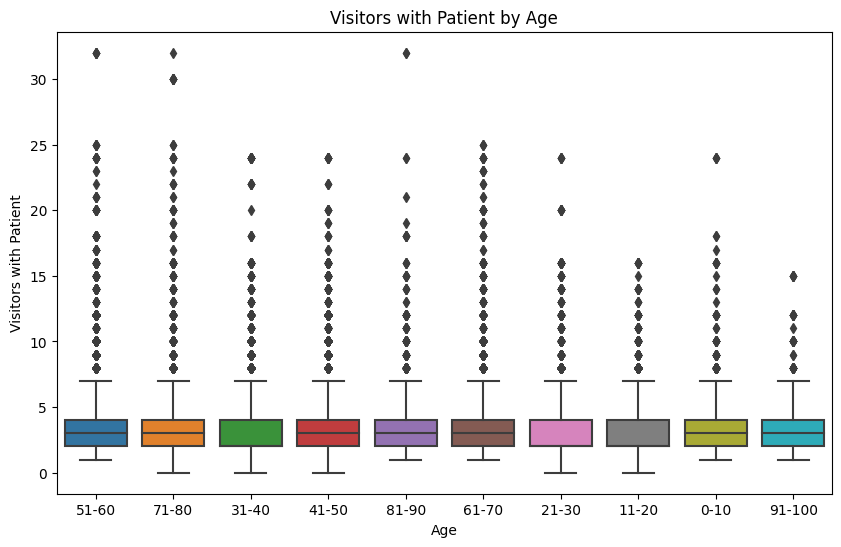

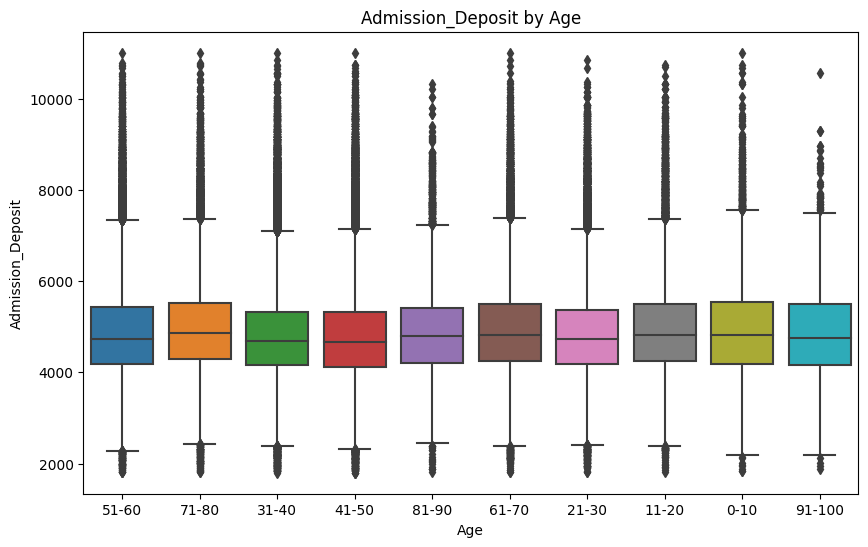

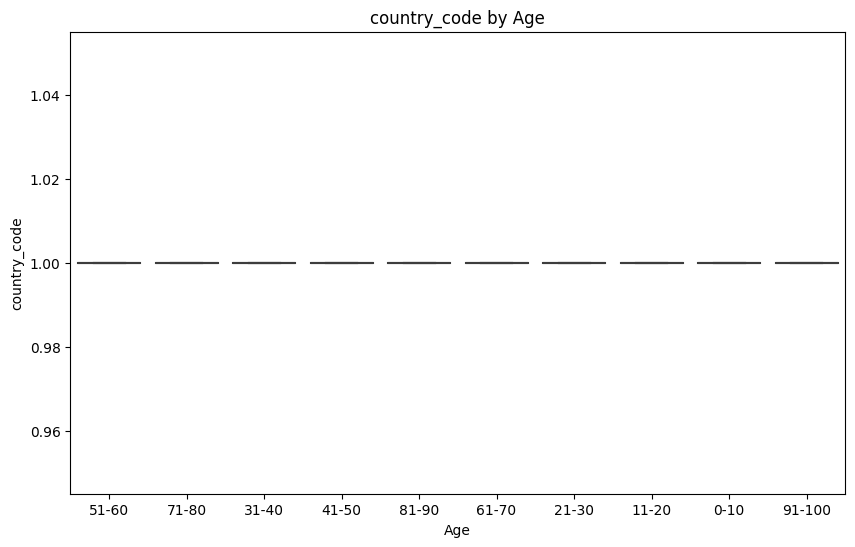

In [32]:
for cat_col in categorical_cols:
    if cat_col != 'Stay':
        for num_col in numerical_cols:
            plt.figure(figsize=(10, 6))
            sns.boxplot(x=data[cat_col], y=data[num_col])
            plt.title(f'{num_col} by {cat_col}')
            plt.show()

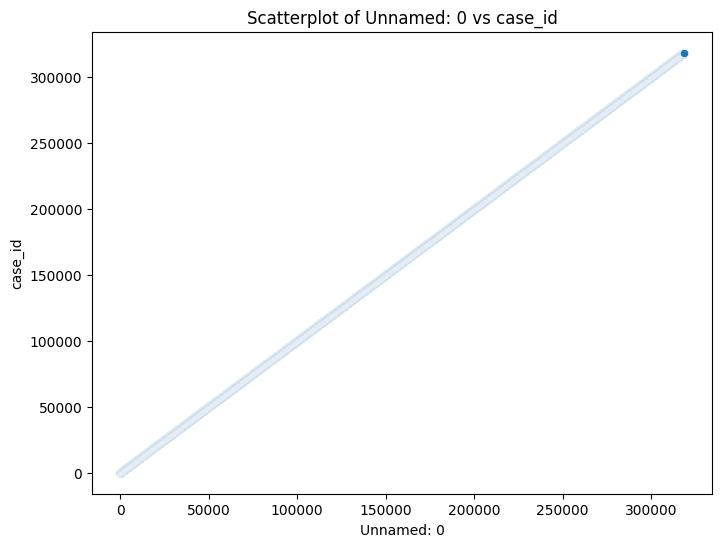

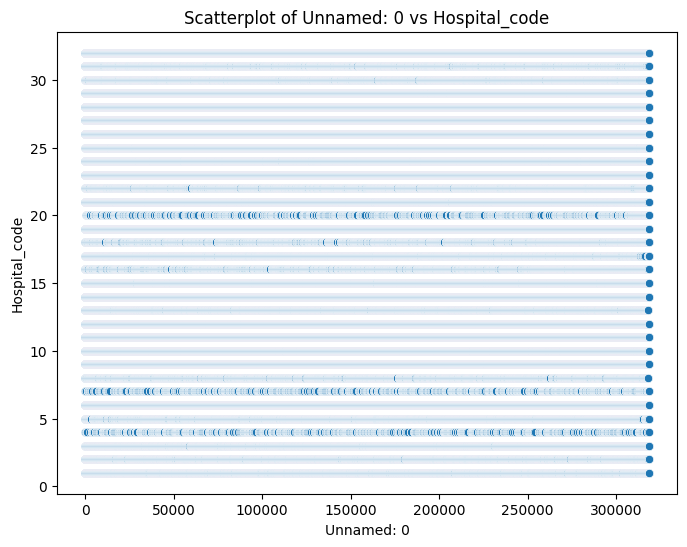

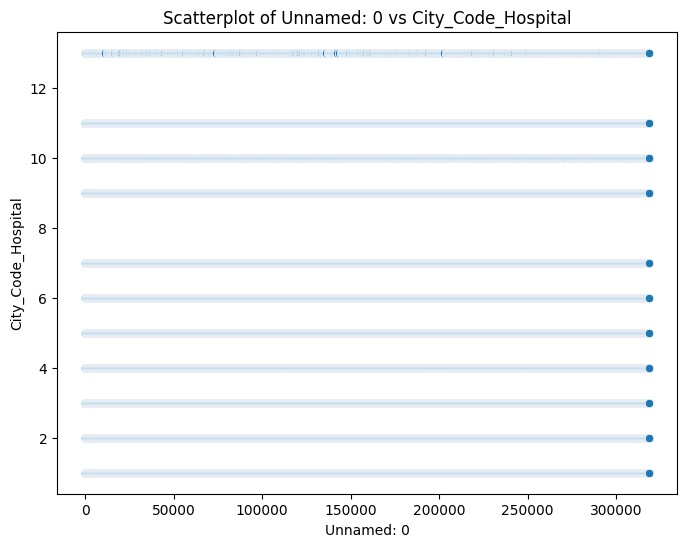

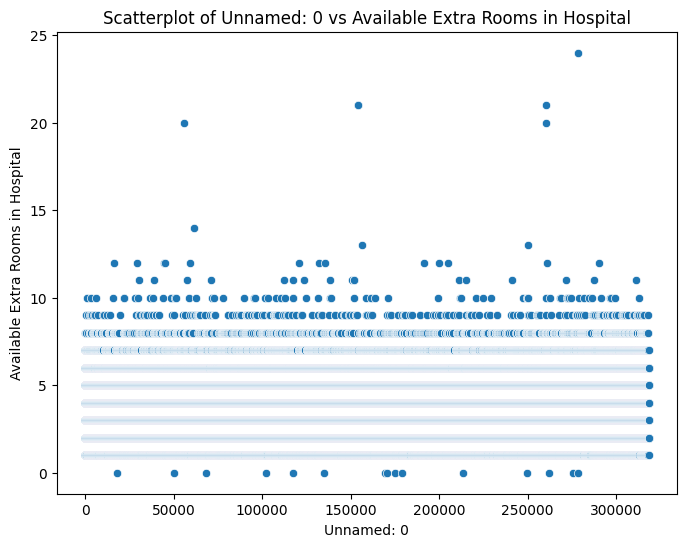

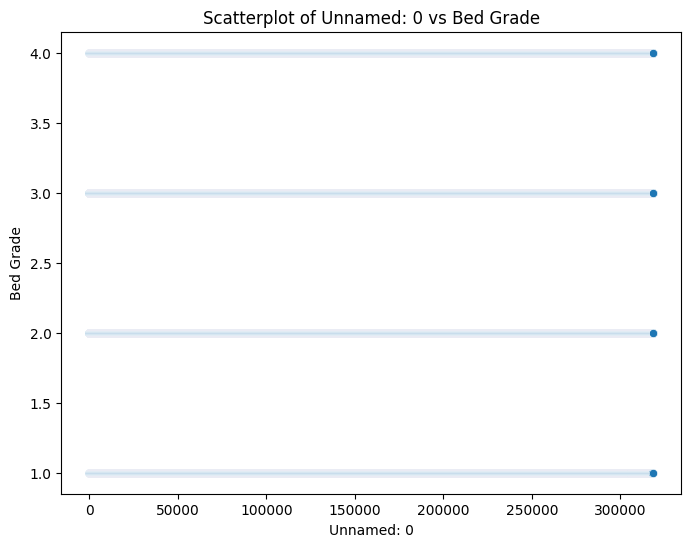

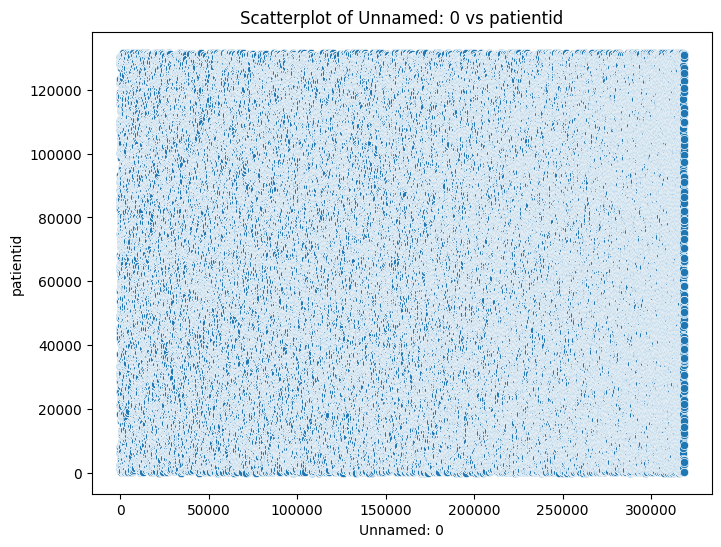

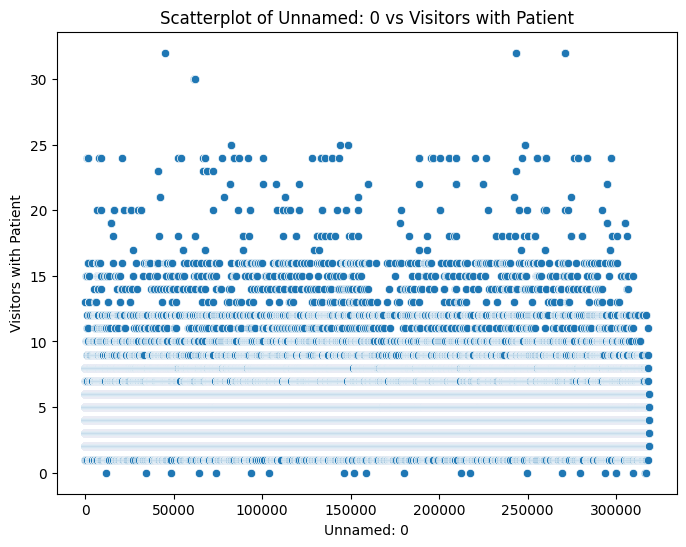

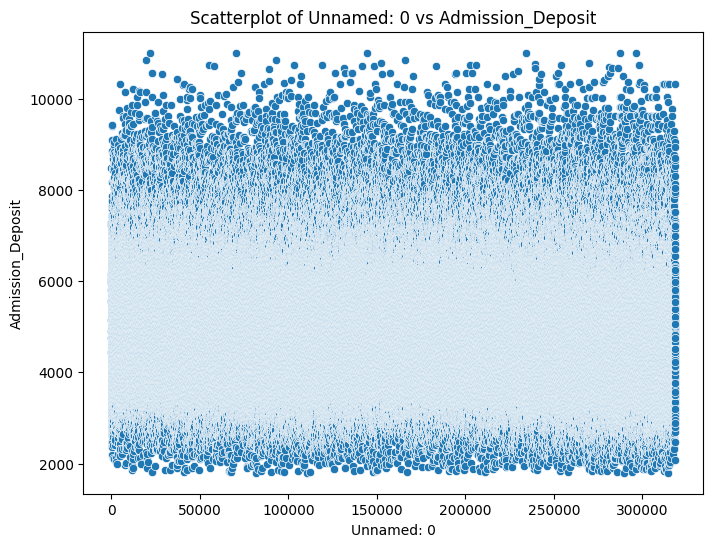

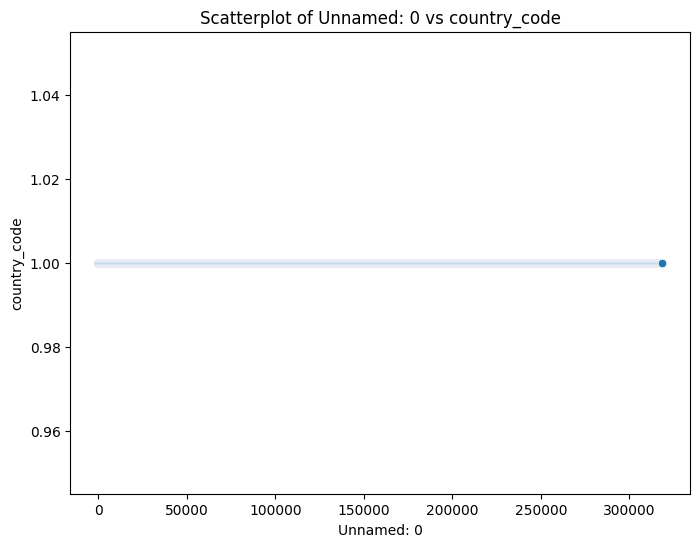

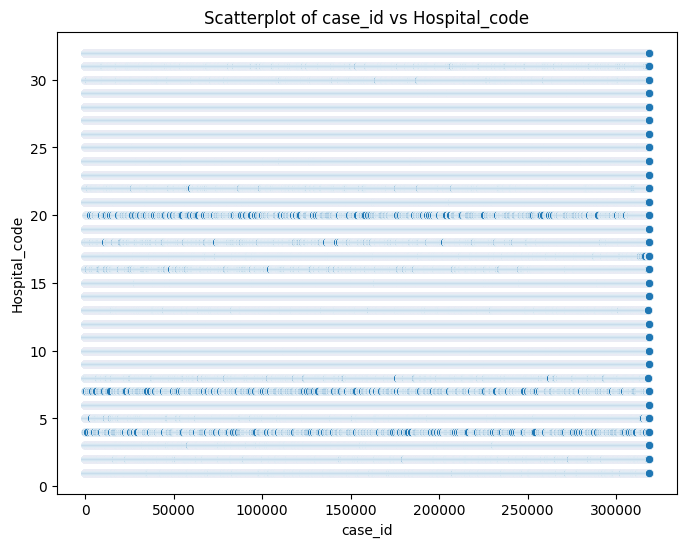

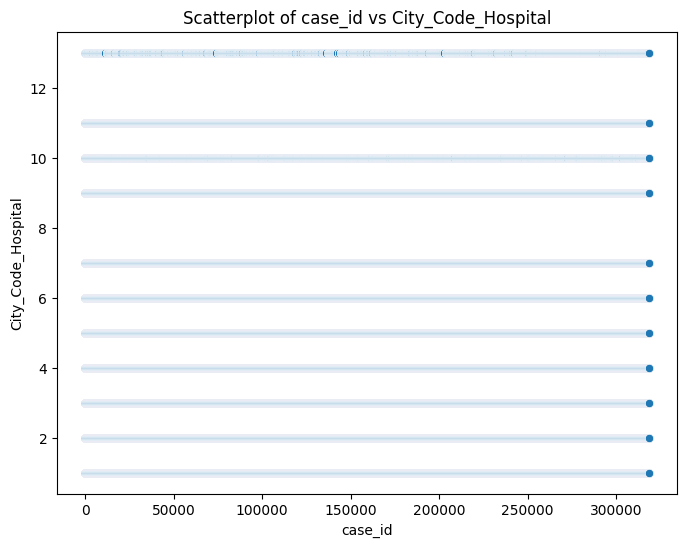

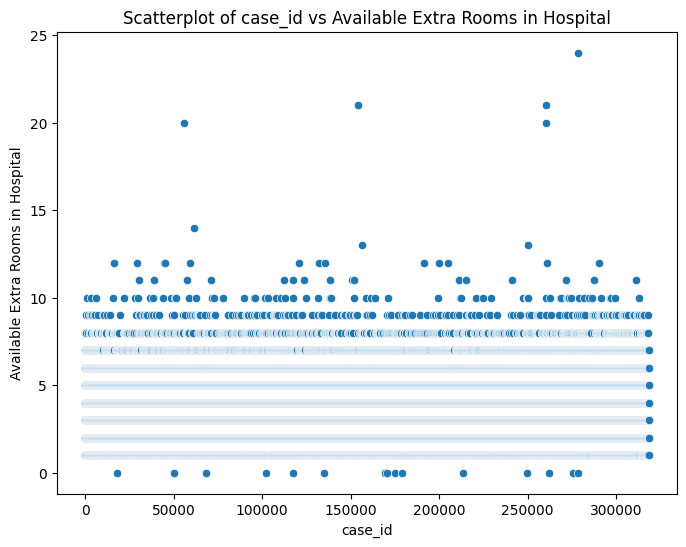

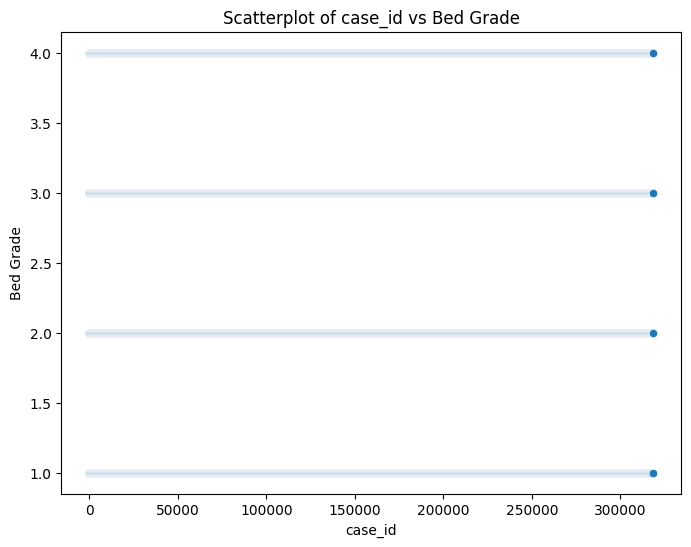

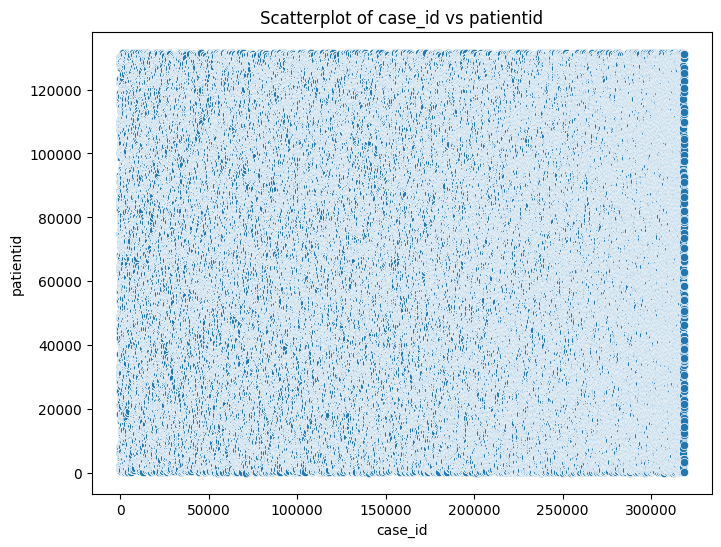

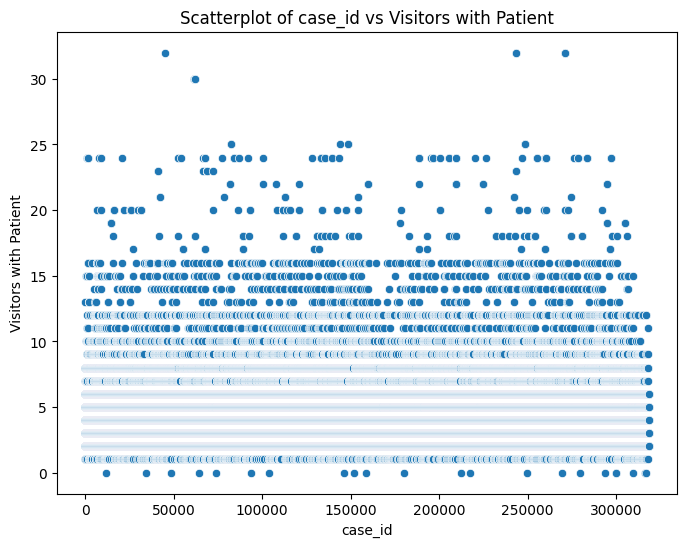

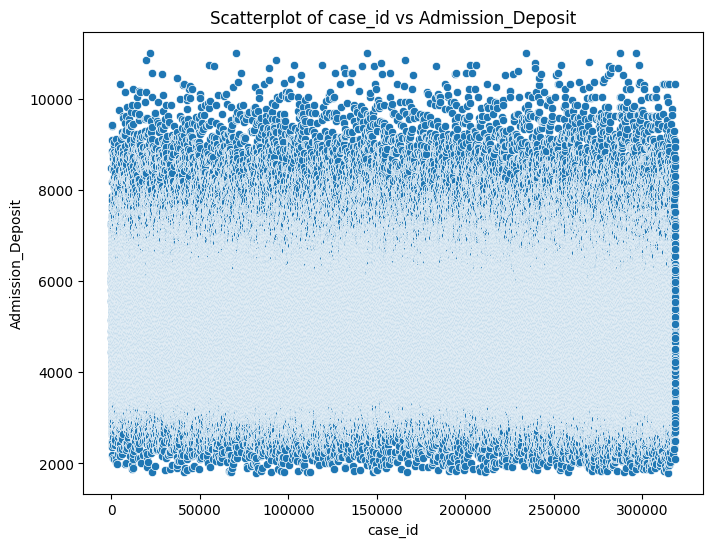

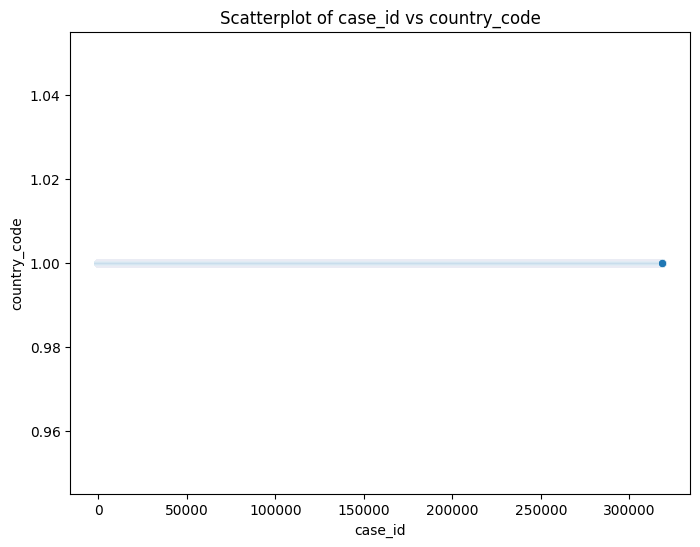

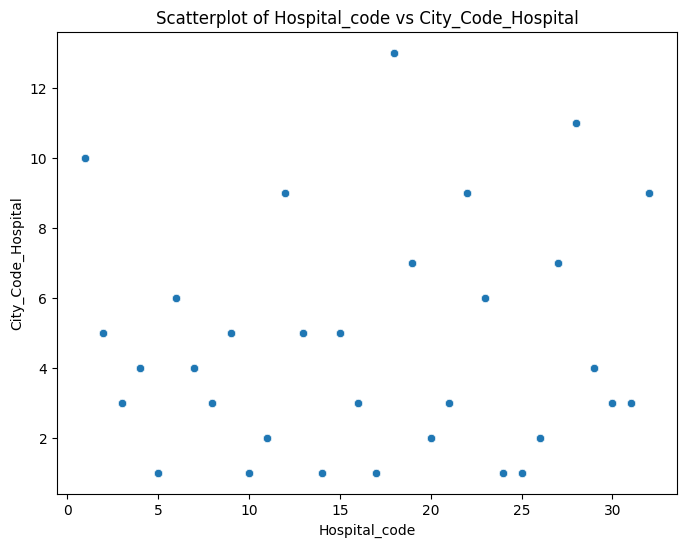

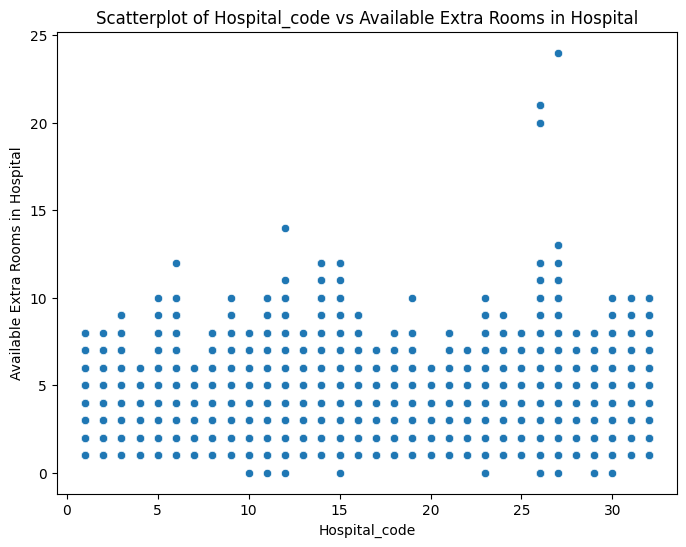

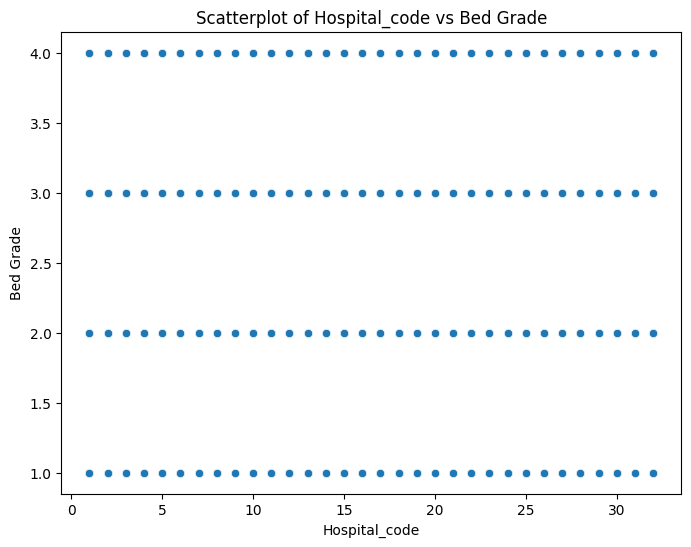

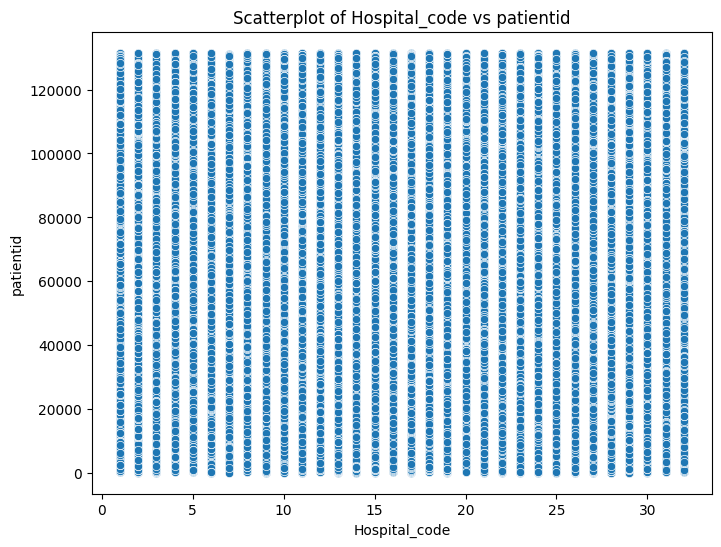

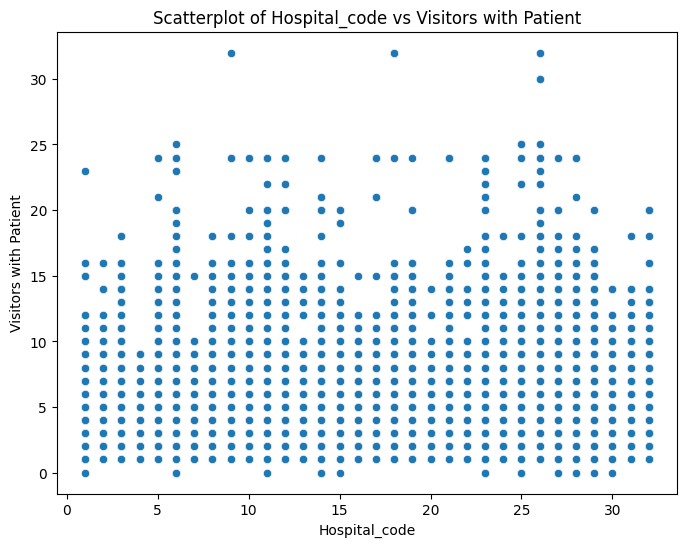

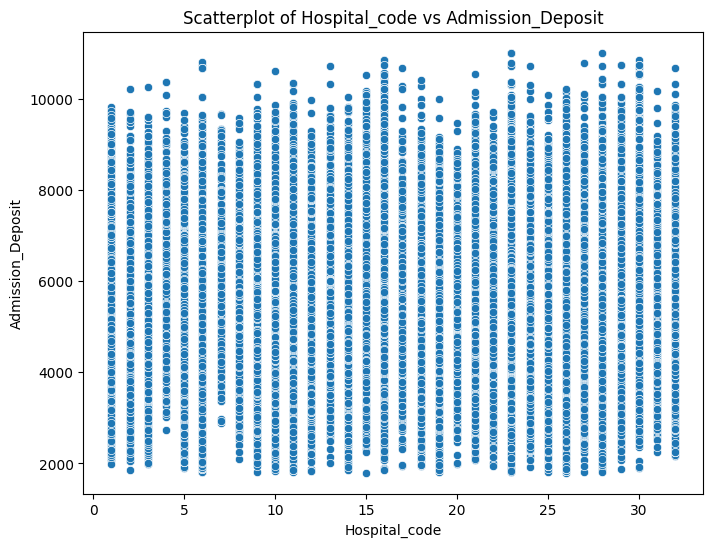

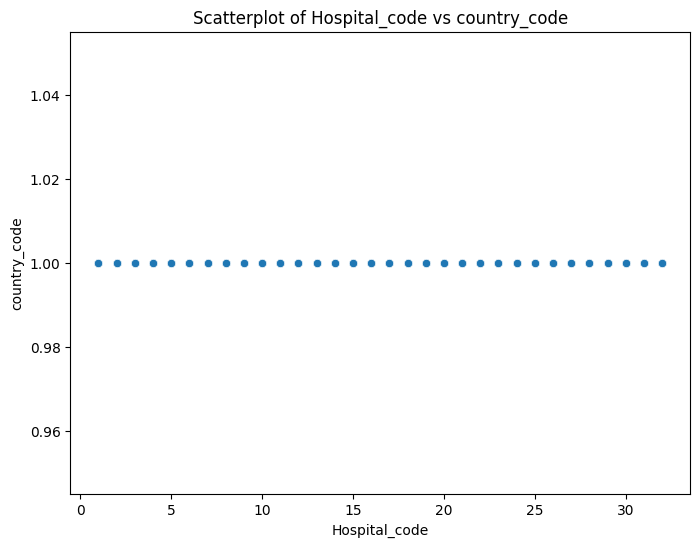

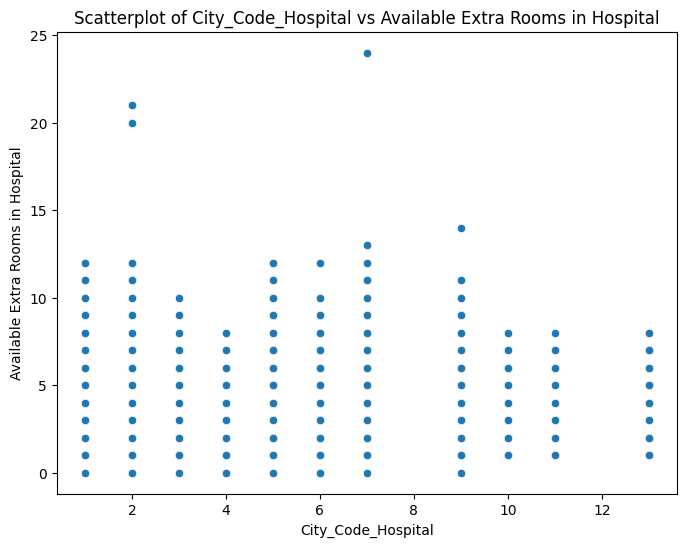

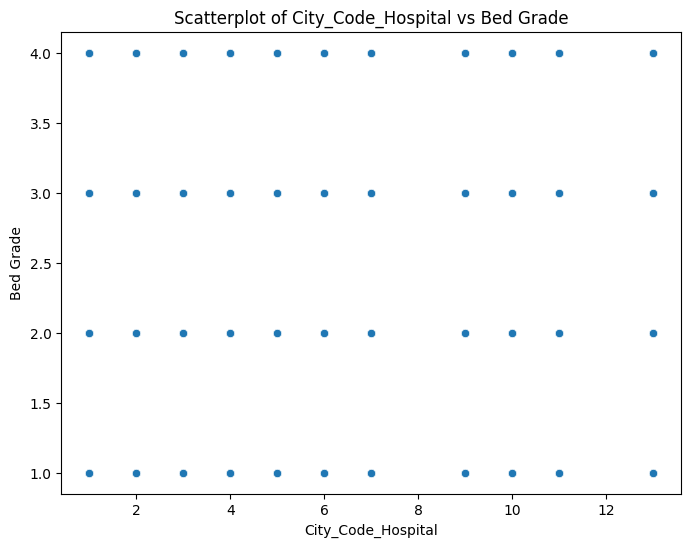

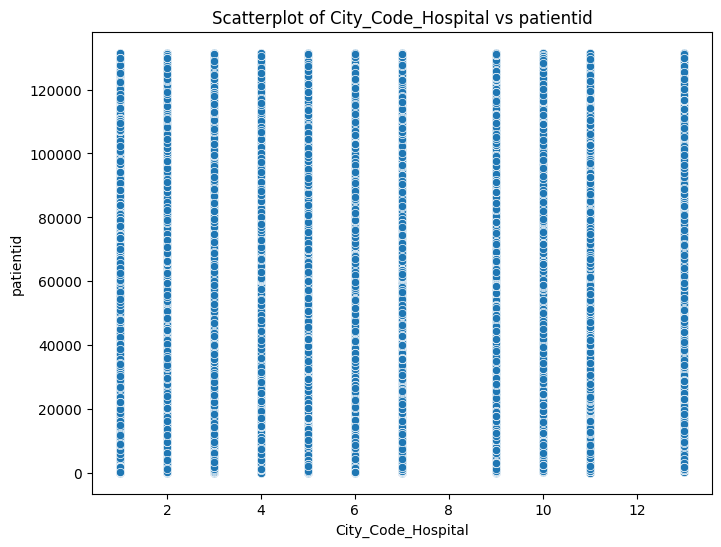

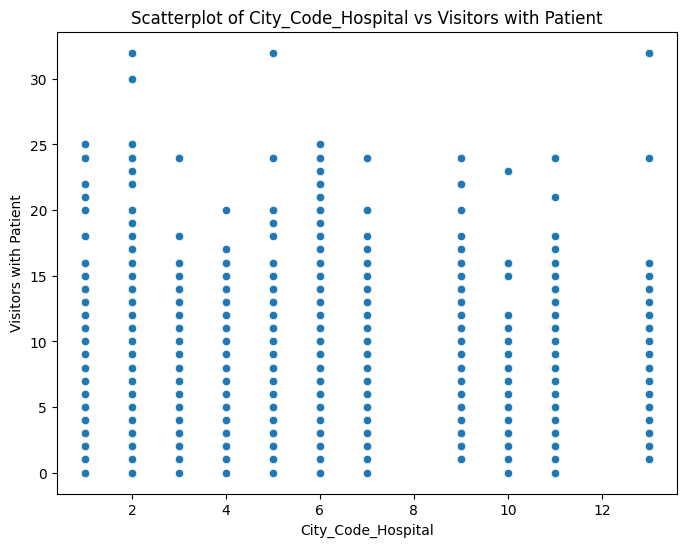

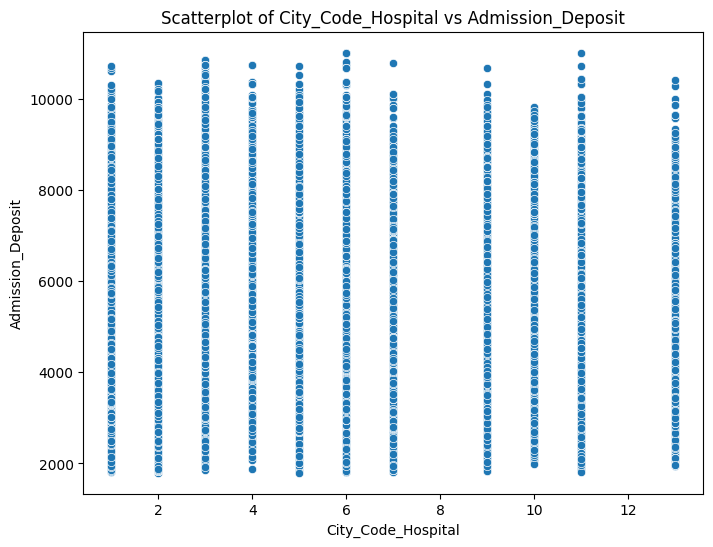

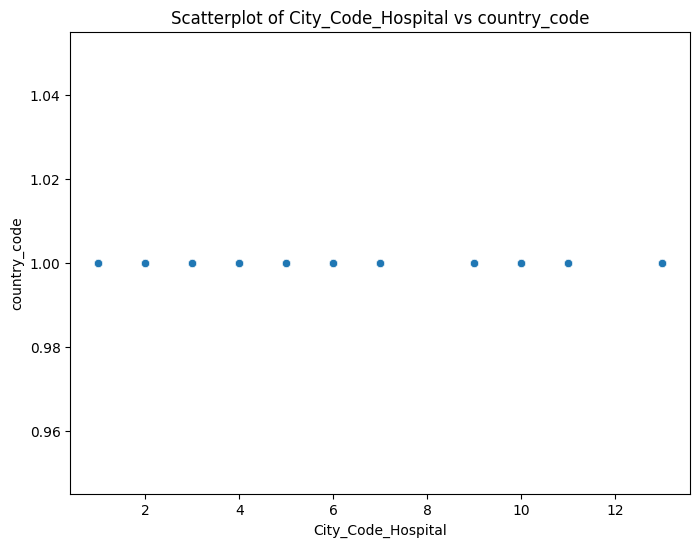

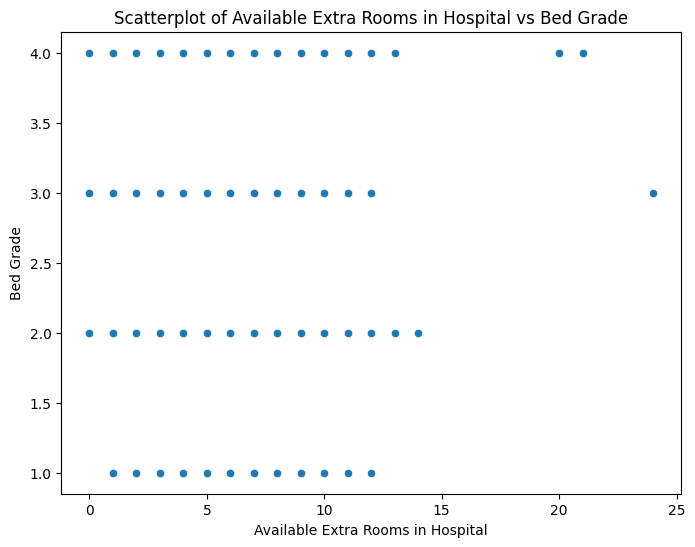

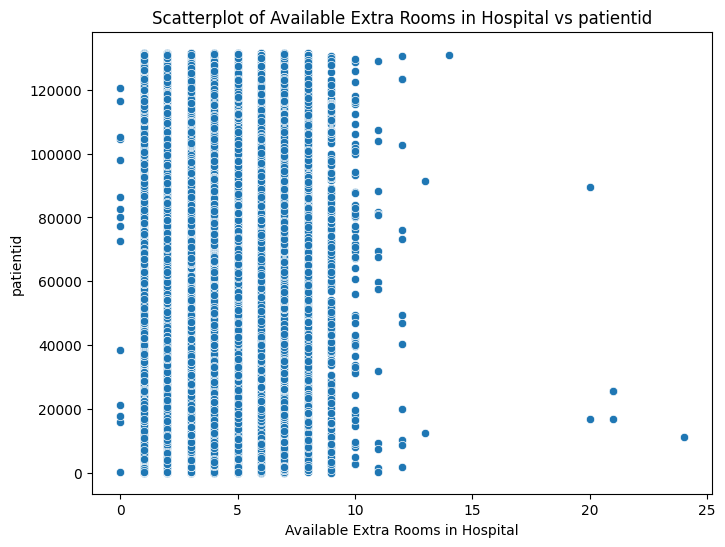

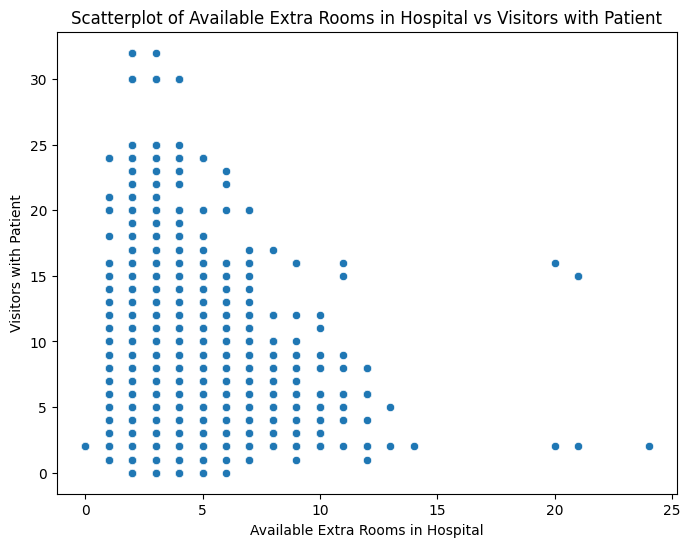

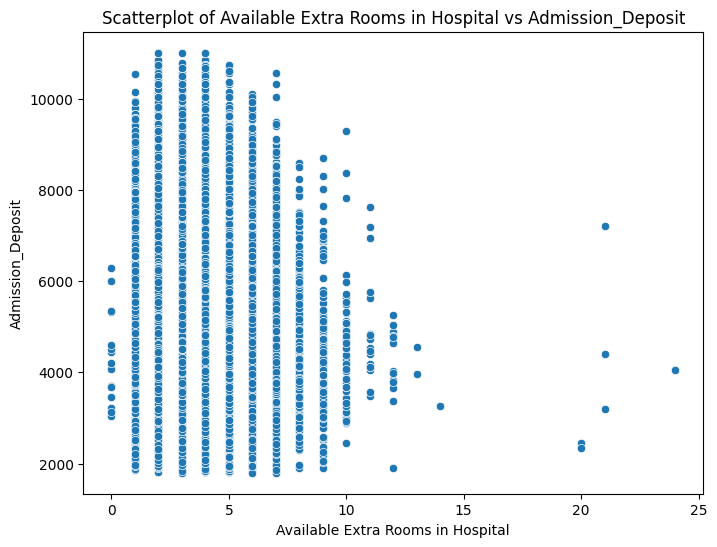

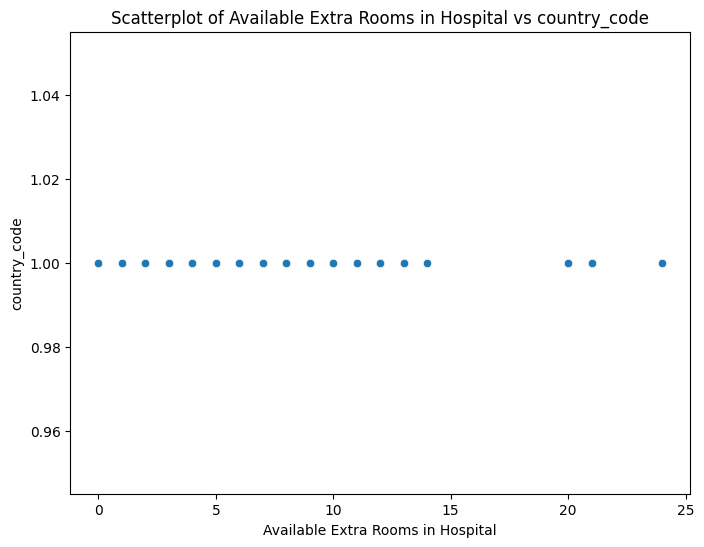

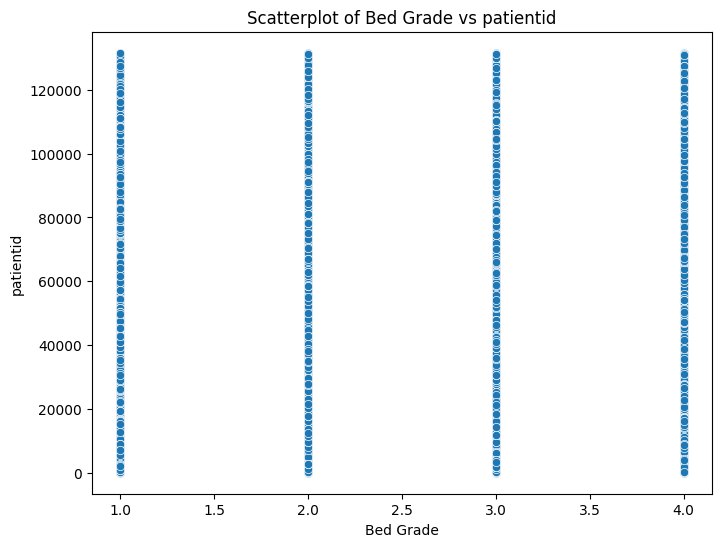

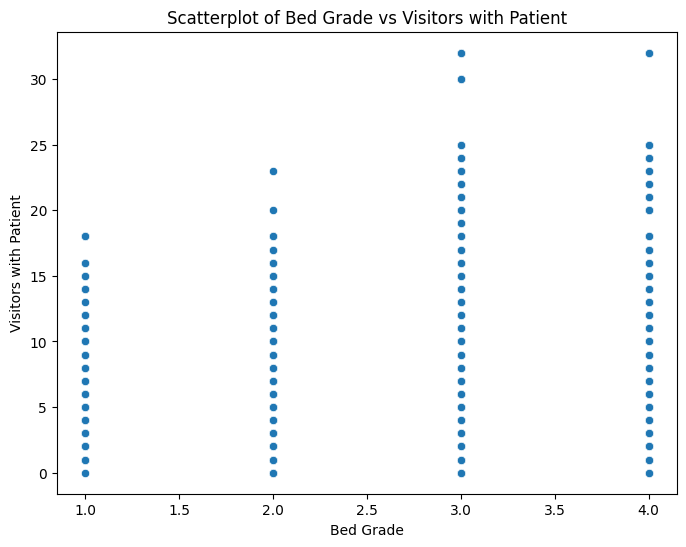

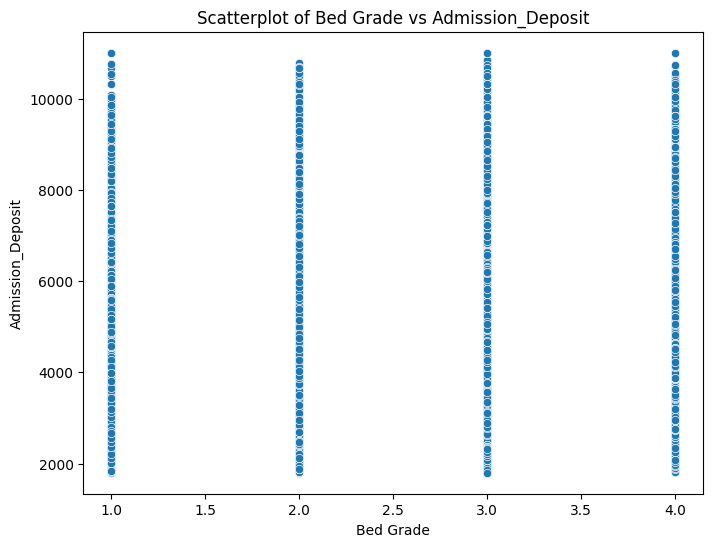

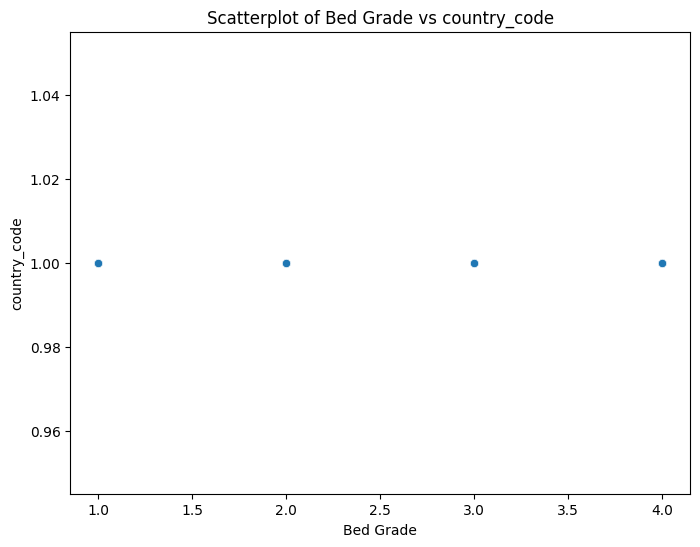

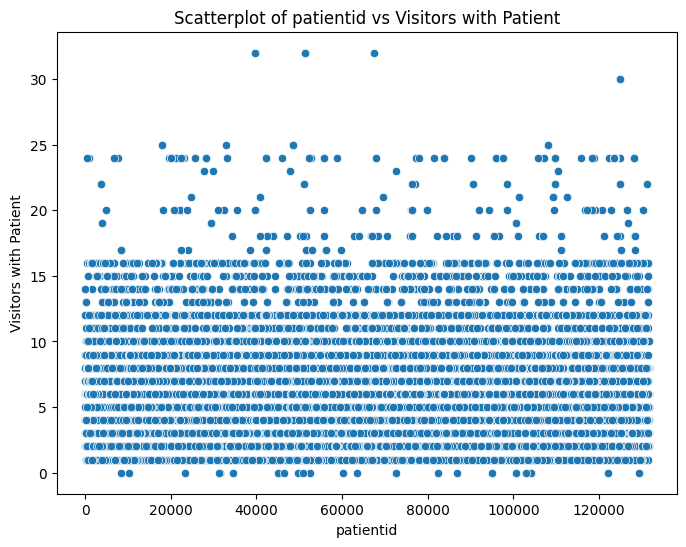

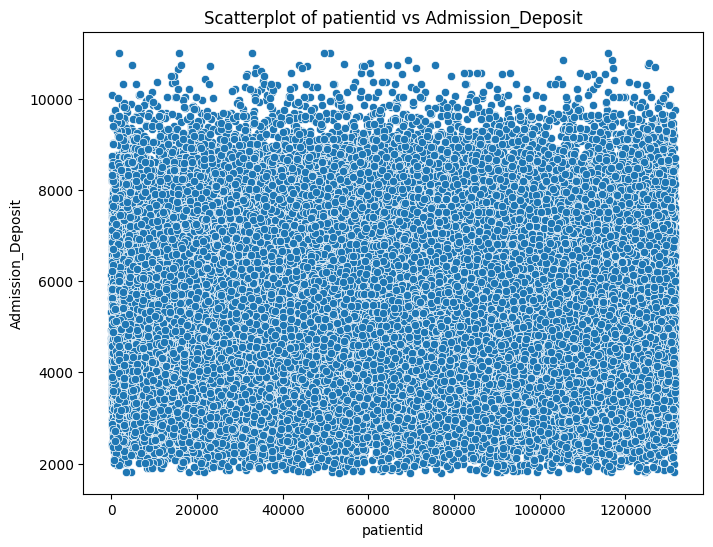

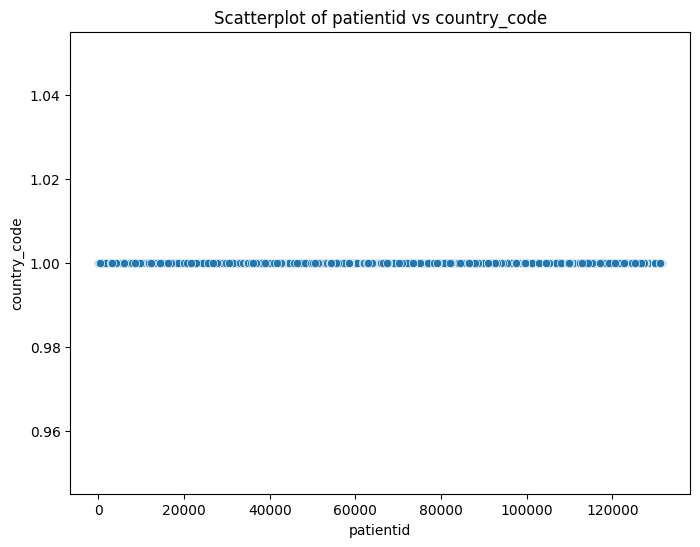

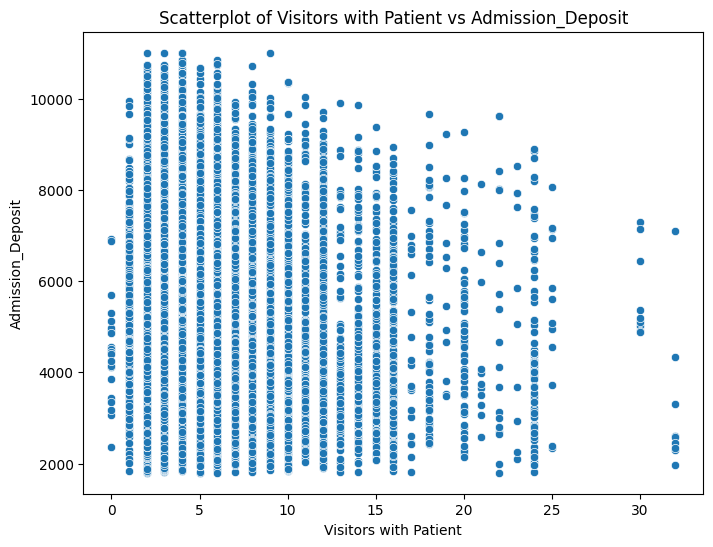

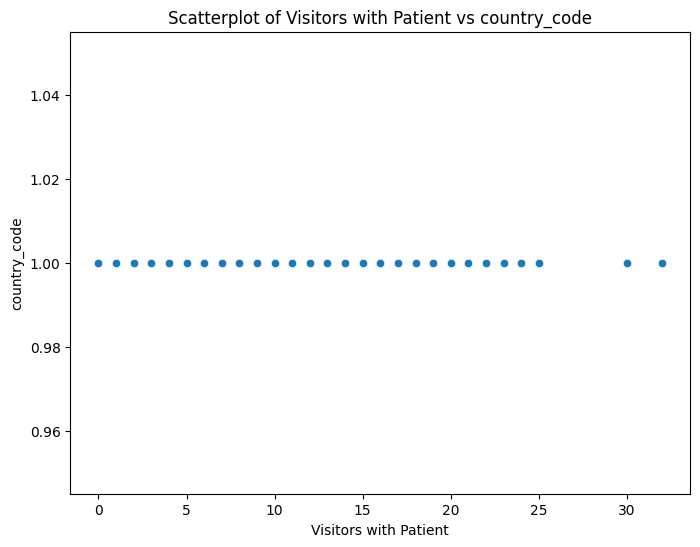

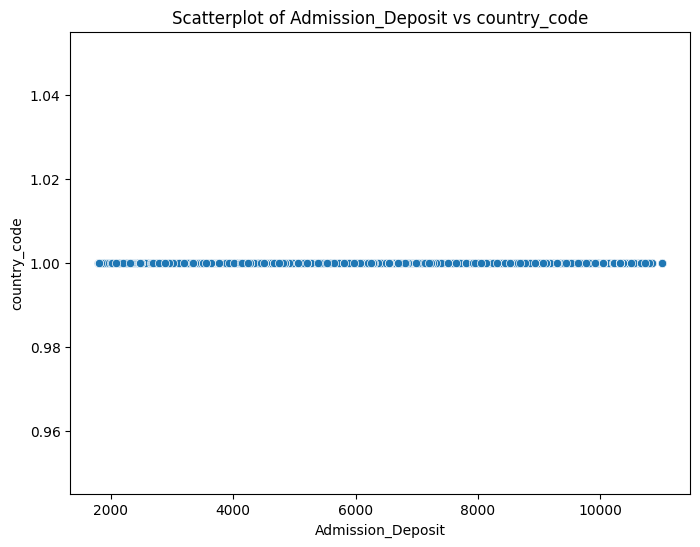

In [33]:
for i in range(len(numerical_cols)):
    for j in range(i + 1, len(numerical_cols)):
        plt.figure(figsize=(8, 6))
        sns.scatterplot(x=data[numerical_cols[i]], y=data[numerical_cols[j]])
        plt.title(f'Scatterplot of {numerical_cols[i]} vs {numerical_cols[j]}')
        plt.xlabel(numerical_cols[i])
        plt.ylabel(numerical_cols[j])
        plt.show()

In [35]:
import pandas as pd

data['Age'] = pd.to_numeric(data['Age'], errors='coerce')

data['Age'].fillna(data['Age'].median(), inplace=True)

def categorize_age(age):
    if age <= 18:
        return 'Молодший'
    elif 19 <= age <= 65:
        return 'Середній'
    else:
        return 'Старший'

data['Age_Category'] = data['Age'].apply(categorize_age)

def categorize_deposit(deposit):
    if deposit < 3000:
        return 'Низький'
    elif 3000 <= deposit <= 6000:
        return 'Середній'
    else:
        return 'Високий'

data['Deposit_Category'] = data['Admission_Deposit'].apply(categorize_deposit)

print(data[['Age', 'Age_Category', 'Admission_Deposit', 'Deposit_Category']].head())

/opt/conda/lib/python3.10/site-packages/numpy/lib/nanfunctions.py:1215: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
/tmp/ipykernel_36/1864009108.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['Age'].fillna(data['Age'].median(), inplace=True)


   Age Age_Category  Admission_Deposit Deposit_Category
0  NaN      Старший             4911.0         Середній
1  NaN      Старший             5954.0         Середній
2  NaN      Старший             4745.0         Середній
3  NaN      Старший             7272.0          Високий
4  NaN      Старший             5558.0         Середній


In [41]:
import pandas as pd

def calculate_stay_days(stay_range):
    try:
        min_days, max_days = map(int, stay_range.split('-'))
        return (min_days + max_days) / 2
    except ValueError:
        return None

data['Stay_Days'] = data['Stay'].apply(calculate_stay_days)

In [43]:
from sklearn.model_selection import train_test_split

features = data.drop(columns=['Stay', 'Stay_Days', 'case_id', 'patientid'])
target = data['Stay_Days']

features = pd.get_dummies(features)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

In [44]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline(steps=[
            ('imputer', SimpleImputer(strategy='mean')),
            ('scaler', StandardScaler())
        ]), X_train.columns)
    ]
)

In [46]:
print(data['Stay_Days'].isnull().sum())

6683


In [47]:
mean_stay_days = data['Stay_Days'].mean()
data['Stay_Days'].fillna(mean_stay_days, inplace=True)

In [48]:
print(data['Stay_Days'].isnull().sum())

0


In [50]:
print(f"NaN in y_train: {y_train.isnull().sum()}")
print(f"NaN in y_test: {y_test.isnull().sum()}")

NaN in y_train: 5392
NaN in y_test: 1291


In [51]:
mean_y_train = y_train.mean()
mean_y_test = y_test.mean()

y_train.fillna(mean_y_train, inplace=True)
y_test.fillna(mean_y_test, inplace=True)

In [52]:
print(f"NaN in y_train after cleaning: {y_train.isnull().sum()}")
print(f"NaN in y_test after cleaning: {y_test.isnull().sum()}")

NaN in y_train after cleaning: 0
NaN in y_test after cleaning: 0


In [53]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import joblib

model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
])

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [55]:
y_pred

array([23.56      , 56.86123114, 33.3       , ..., 30.        ,
       21.74      , 16.64      ])

In [56]:
y_pred = model.predict(X_test)

results = pd.DataFrame({
    'Actual Stay': y_test,
    'Predicted Stay': y_pred
})

print(results.head(10))

        Actual Stay  Predicted Stay
245328    55.500000       23.560000
239123    55.500000       56.861231
280646    25.500000       33.300000
89025     25.500000       28.065000
517       35.500000       33.995000
275285    35.500000       26.880000
221020    30.914772       51.744925
297989    15.500000       20.510000
128961     5.000000       21.890000
208348    15.500000       24.215000


In [57]:
print("Actual Stay Statistics:")
print(y_test.describe())

print("Predicted Stay Statistics:")
print(pd.Series(y_pred).describe())

Actual Stay Statistics:
count    63688.000000
mean        30.914772
std         18.674322
min          5.000000
25%         15.500000
50%         25.500000
75%         35.500000
max         95.500000
Name: Stay_Days, dtype: float64
Predicted Stay Statistics:
count    63688.000000
mean        31.133646
std         12.306032
min          5.630000
25%         22.485000
50%         26.963731
75%         37.795000
max         86.191181
dtype: float64


In [54]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
mae = mean_absolute_error(y_test, y_pred)

print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAE: {mae:.2f}")

MSE: 215.34
RMSE: 14.67
MAE: 10.87
